# __WOA7015 Alternative Assessment__
Group: __Learning Machine__

Final Model

## Import Needed Modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.models import resnet18, VGG16_Weights, ResNet18_Weights, AlexNet_Weights
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)
import pandas as pd
import logging
from datetime import datetime
import math
from typing import Optional, Tuple, List, Dict, Any
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Get Data

In [3]:
# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# dataset: https://drive.google.com/drive/folders/1d1ArqNswahfsmP6h-fm3WCvL47dVOpxA?usp=drive_link

# Define the base directory for data
base_data_dir = '/kaggle/input/brain-tumor-mri-dataset'

# Training and validation datasets and loaders
train_dataset = ImageFolder(f'{base_data_dir}/Training', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

val_dataset = ImageFolder(f'{base_data_dir}/Testing', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

## Pre-trained Model

In [8]:
def calculate_metrics_pretrained(true_labels, pred_labels, num_classes):
    # Calculate metrics
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Compute sensitivity for each class
    sensitivity = []
    for i in range(num_classes):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        sensitivity.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

    # Print metrics in a single line
    print(f"Metrics -> F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(f"Sensitivity -> {' '.join([f'Class {i}: {sens:.4f}' for i, sens in enumerate(sensitivity)])}")
    print(f"Confusion Matrix:\n{np.array(cm)}")

    return {
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'sensitivity': sensitivity,
        'confusion_matrix': cm.tolist()  # Save as list for JSON serialization
    }


In [9]:
def fine_tune_pretrained_models(train_loader, val_loader, num_classes, device):
    """
    Fine-tune multiple pre-trained models, compute metrics, and log accuracy/loss for plotting.
    """
    # Define pre-trained models
    model_dict = {
        'VGG16': {
            'model': models.vgg16(),
            'weights_path': '/kaggle/input/model/pytorch/default/1/vgg16-397923af.pth'
        },
        'ResNet18': {
            'model': models.resnet18(),
            'weights_path': '/kaggle/input/model/pytorch/default/1/resnet18-f37072fd.pth'
        },
        'AlexNet': {
            'model': models.alexnet(),
            'weights_path': '/kaggle/input/model/pytorch/default/1/alexnet-owt-7be5be79.pth'
        }
    }

    all_results = {}

    # Overall progress bar
    overall_progress = tqdm(total=len(model_dict), desc="Fine-tuning Models")

    for model_name, model_info in model_dict.items():
        print(f"Fine-tuning {model_name}")

        # Load model architecture and weights
        base_model = model_info['model']
        weights_path = model_info['weights_path']
        base_model.load_state_dict(torch.load(weights_path))

        # Replace the final classification layer
        if model_name in ['VGG16', 'AlexNet']:
            base_model.classifier[-1] = nn.Linear(base_model.classifier[-1].in_features, num_classes)
        elif model_name == 'ResNet18':
            base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)

        # Freeze all layers except the final layer
        for param in base_model.parameters():
            param.requires_grad = False
        # Unfreeze the final layer
        if model_name in ['VGG16', 'AlexNet']:
            for param in base_model.classifier[-1].parameters():
                param.requires_grad = True
        elif model_name == 'ResNet18':
            for param in base_model.fc.parameters():
                param.requires_grad = True

        # Move model to the specified device
        base_model = base_model.to(device)

        # Define training parameters
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, base_model.parameters()), lr=0.001)
        epochs = 100
        best_f1 = 0.0
        train_metrics, val_metrics = [], []
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        # Per-model training progress bar
        model_progress = tqdm(total=epochs, desc=f"Training {model_name}", leave=False)

        for epoch in range(epochs):
            # Training phase
            base_model.train()
            train_true, train_preds = [], []
            train_loss = 0.0
            correct_train, total_train = 0, 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = base_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Update loss
                train_loss += loss.item()

                # Update predictions
                _, predicted = torch.max(outputs, 1)
                train_preds.extend(predicted.cpu().numpy())
                train_true.extend(labels.cpu().numpy())
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)

            # Training metrics
            train_accuracy = correct_train / total_train
            train_losses.append(train_loss / len(train_loader))  # Average loss
            train_accuracies.append(train_accuracy)

            train_metrics_epoch = calculate_metrics_pretrained(np.array(train_true), np.array(train_preds), num_classes)
            train_metrics.append(train_metrics_epoch)

            # Validation phase
            base_model.eval()
            val_true, val_preds = [], []
            val_loss = 0.0
            correct_val, total_val = 0, 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = base_model(inputs)
                    loss = criterion(outputs, labels)

                    # Update loss
                    val_loss += loss.item()

                    # Update predictions
                    _, predicted = torch.max(outputs, 1)
                    val_preds.extend(predicted.cpu().numpy())
                    val_true.extend(labels.cpu().numpy())
                    correct_val += (predicted == labels).sum().item()
                    total_val += labels.size(0)

            # Validation metrics
            val_accuracy = correct_val / total_val
            val_losses.append(val_loss / len(val_loader))  # Average loss
            val_accuracies.append(val_accuracy)

            val_metrics_epoch = calculate_metrics_pretrained(np.array(val_true), np.array(val_preds), num_classes)
            val_metrics.append(val_metrics_epoch)

            # Print epoch metrics
            print(f"Epoch {epoch + 1}/{epochs} - {model_name}")
            print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
            print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")
            print(f"Train F1: {train_metrics_epoch['f1_score']:.4f}, Val F1: {val_metrics_epoch['f1_score']:.4f}")

            # Update the best model based on F1-score
            if val_metrics_epoch['f1_score'] > best_f1:
                best_f1 = val_metrics_epoch['f1_score']
                best_model_path = f'/kaggle/working/{model_name}_best.pth'
                torch.save(base_model.state_dict(), best_model_path)  # Save best weights
                print(f"Best model for {model_name} saved at {best_model_path} with F1-score: {best_f1:.4f}")

            # Update progress bar
            model_progress.update(1)

        # Save final model after training
        final_model_path = f'/kaggle/working/{model_name}_final.pth'
        torch.save(base_model.state_dict(), final_model_path)
        print(f"Final model for {model_name} saved at {final_model_path}")

        # Close progress bar for this model
        model_progress.close()

        # Save results for the current model
        all_results[model_name] = {
            'train_metrics': [{k: (v.tolist() if isinstance(v, np.ndarray) else v) for k, v in tm.items()} for tm in train_metrics],
            'val_metrics': [{k: (v.tolist() if isinstance(v, np.ndarray) else v) for k, v in vm.items()} for vm in val_metrics],
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies,
            'best_f1': best_f1
        }

    # Save all results to a JSON file
    with open("pretrained_models_results_with_metrics.json", "w") as f:
        json.dump(all_results, f, indent=4)

    print("Pre-trained models results with metrics saved.")
    return all_results


## Plot Function

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_and_display_results(all_results):
    for model_name, model_data in all_results.items():
        print(f"Results for {model_name}:")

        # Extract metrics, losses, and accuracies
        train_losses = model_data.get('train_losses', [])
        val_losses = model_data.get('val_losses', [])
        train_accuracies = model_data.get('train_accuracies', [])
        val_accuracies = model_data.get('val_accuracies', [])
        train_metrics = model_data.get('train_metrics', [])
        val_metrics = model_data.get('val_metrics', [])
        best_f1 = model_data.get('best_f1', 0.0)

        # Plot Loss Curve
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.title(f"{model_name} - Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        # Plot Accuracy Curve
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label="Train Accuracy")
        plt.plot(val_accuracies, label="Validation Accuracy")
        plt.title(f"{model_name} - Accuracy Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        # Display the plots
        plt.tight_layout()
        plt.show()

        # Display F1-Score, Precision, Recall
        print(f"Best F1-Score for {model_name}: {best_f1:.4f}")
        print(f"Final Train F1-Score: {train_metrics[-1]['f1_score']:.4f}" if train_metrics else "No Train Metrics")
        print(f"Final Validation F1-Score: {val_metrics[-1]['f1_score']:.4f}" if val_metrics else "No Validation Metrics")

        # Display Sensitivity and Confusion Matrix for Validation
        if val_metrics:
            sensitivity = val_metrics[-1].get('sensitivity', [])
            confusion_matrix = val_metrics[-1].get('confusion_matrix', [])
            print(f"Validation Sensitivity per Class for {model_name}: {sensitivity}")
            print(f"Validation Confusion Matrix for {model_name}:")
            print(np.array(confusion_matrix))

        print("-" * 50)

## Model Training

In [13]:
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

all_results = fine_tune_pretrained_models(train_loader, val_loader, num_classes, device)

Number of classes: 4


Fine-tuning Models:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-tuning VGG16



Training VGG16:   0%|          | 0/100 [00:00<?, ?it/s]

Metrics -> F1-Score: 0.6525, Precision: 0.6505, Recall: 0.6569
Sensitivity -> Class 0: 0.6117 Class 1: 0.4586 Class 2: 0.8313 Class 3: 0.6891
Confusion Matrix:
[[ 808  232  137  144]
 [ 257  614  182  286]
 [  55   84 1326  130]
 [ 142  233   78 1004]]
Metrics -> F1-Score: 0.7551, Precision: 0.7575, Recall: 0.7712
Sensitivity -> Class 0: 0.7367 Class 1: 0.4085 Class 2: 0.9457 Class 3: 0.9400
Confusion Matrix:
[[221  52   7  20]
 [ 50 125  78  53]
 [  7   9 383   6]
 [  5  10   3 282]]
Epoch 1/100 - VGG16
Train Loss: 0.8132, Train Accuracy: 0.6569
Val Loss: 0.6016, Val Accuracy: 0.7712
Train F1: 0.6525, Val F1: 0.7551



Training VGG16:   1%|          | 1/100 [01:18<2:10:07, 78.86s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.7551
Metrics -> F1-Score: 0.7958, Precision: 0.7950, Recall: 0.7978
Sensitivity -> Class 0: 0.7646 Class 1: 0.6221 Class 2: 0.9235 Class 3: 0.8518
Confusion Matrix:
[[1010  230   26   55]
 [ 163  833  122  221]
 [  25   54 1473   43]
 [  66  131   19 1241]]
Metrics -> F1-Score: 0.7758, Precision: 0.7778, Recall: 0.7872
Sensitivity -> Class 0: 0.7833 Class 1: 0.4608 Class 2: 0.9185 Class 3: 0.9467
Confusion Matrix:
[[235  43   2  20]
 [ 45 141  60  60]
 [ 10  18 372   5]
 [  6  10   0 284]]
Epoch 2/100 - VGG16
Train Loss: 0.5345, Train Accuracy: 0.7978
Val Loss: 0.5304, Val Accuracy: 0.7872
Train F1: 0.7958, Val F1: 0.7758



Training VGG16:   2%|▏         | 2/100 [02:37<2:08:50, 78.88s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.7758
Metrics -> F1-Score: 0.8065, Precision: 0.8058, Recall: 0.8076
Sensitivity -> Class 0: 0.7752 Class 1: 0.6505 Class 2: 0.9185 Class 3: 0.8600
Confusion Matrix:
[[1024  220   22   55]
 [ 183  871  111  174]
 [  28   62 1465   40]
 [  47  136   21 1253]]
Metrics -> F1-Score: 0.7977, Precision: 0.7966, Recall: 0.8047
Sensitivity -> Class 0: 0.7867 Class 1: 0.5392 Class 2: 0.9309 Class 3: 0.9233
Confusion Matrix:
[[236  54   2   8]
 [ 45 165  61  35]
 [ 13   9 377   6]
 [ 10  12   1 277]]
Epoch 3/100 - VGG16
Train Loss: 0.4983, Train Accuracy: 0.8076
Val Loss: 0.5006, Val Accuracy: 0.8047
Train F1: 0.8065, Val F1: 0.7977



Training VGG16:   3%|▎         | 3/100 [03:56<2:07:08, 78.64s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.7977
Metrics -> F1-Score: 0.8185, Precision: 0.8177, Recall: 0.8199
Sensitivity -> Class 0: 0.7880 Class 1: 0.6572 Class 2: 0.9310 Class 3: 0.8765
Confusion Matrix:
[[1041  219   17   44]
 [ 184  880   96  179]
 [  19   61 1485   30]
 [  42  114   24 1277]]
Metrics -> F1-Score: 0.8103, Precision: 0.8111, Recall: 0.8177
Sensitivity -> Class 0: 0.7600 Class 1: 0.5654 Class 2: 0.9556 Class 3: 0.9467
Confusion Matrix:
[[228  55   3  14]
 [ 35 173  59  39]
 [  6   6 387   6]
 [  7   7   2 284]]
Epoch 4/100 - VGG16
Train Loss: 0.4763, Train Accuracy: 0.8199
Val Loss: 0.4851, Val Accuracy: 0.8177
Train F1: 0.8185, Val F1: 0.8103



Training VGG16:   4%|▍         | 4/100 [05:14<2:05:55, 78.71s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.8103
Metrics -> F1-Score: 0.8265, Precision: 0.8260, Recall: 0.8283
Sensitivity -> Class 0: 0.7843 Class 1: 0.6669 Class 2: 0.9348 Class 3: 0.8998
Confusion Matrix:
[[1036  211   21   53]
 [ 177  893   90  179]
 [  24   48 1491   32]
 [  23  106   17 1311]]



Training VGG16:   5%|▌         | 5/100 [06:31<2:03:16, 77.86s/it]

Metrics -> F1-Score: 0.8090, Precision: 0.8104, Recall: 0.8169
Sensitivity -> Class 0: 0.7733 Class 1: 0.5490 Class 2: 0.9457 Class 3: 0.9600
Confusion Matrix:
[[232  56   0  12]
 [ 29 168  62  47]
 [ 10   6 383   6]
 [  5   7   0 288]]
Epoch 5/100 - VGG16
Train Loss: 0.4528, Train Accuracy: 0.8283
Val Loss: 0.4685, Val Accuracy: 0.8169
Train F1: 0.8265, Val F1: 0.8090
Metrics -> F1-Score: 0.8334, Precision: 0.8331, Recall: 0.8346
Sensitivity -> Class 0: 0.7956 Class 1: 0.6871 Class 2: 0.9386 Class 3: 0.8916
Confusion Matrix:
[[1051  203   19   48]
 [ 157  920   83  179]
 [  21   54 1497   23]
 [  32  111   15 1299]]



Training VGG16:   6%|▌         | 6/100 [07:48<2:01:38, 77.65s/it]

Metrics -> F1-Score: 0.8051, Precision: 0.8110, Recall: 0.8169
Sensitivity -> Class 0: 0.8200 Class 1: 0.4902 Class 2: 0.9580 Class 3: 0.9567
Confusion Matrix:
[[246  41   1  12]
 [ 48 150  55  53]
 [  8   5 388   4]
 [  8   2   3 287]]
Epoch 6/100 - VGG16
Train Loss: 0.4361, Train Accuracy: 0.8346
Val Loss: 0.4474, Val Accuracy: 0.8169
Train F1: 0.8334, Val F1: 0.8051
Metrics -> F1-Score: 0.8393, Precision: 0.8389, Recall: 0.8403
Sensitivity -> Class 0: 0.8168 Class 1: 0.6938 Class 2: 0.9411 Class 3: 0.8861
Confusion Matrix:
[[1079  186   21   35]
 [ 158  929   69  183]
 [  16   47 1501   31]
 [  40  113   13 1291]]
Metrics -> F1-Score: 0.8186, Precision: 0.8217, Recall: 0.8284
Sensitivity -> Class 0: 0.8200 Class 1: 0.5294 Class 2: 0.9654 Class 3: 0.9567
Confusion Matrix:
[[246  43   3   8]
 [ 43 162  65  36]
 [  6   5 391   3]
 [  7   4   2 287]]
Epoch 7/100 - VGG16
Train Loss: 0.4279, Train Accuracy: 0.8403
Val Loss: 0.4343, Val Accuracy: 0.8284
Train F1: 0.8393, Val F1: 0.8186



Training VGG16:   7%|▋         | 7/100 [09:07<2:00:51, 77.97s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.8186
Metrics -> F1-Score: 0.8373, Precision: 0.8364, Recall: 0.8388
Sensitivity -> Class 0: 0.8070 Class 1: 0.6848 Class 2: 0.9530 Class 3: 0.8840
Confusion Matrix:
[[1066  193   20   42]
 [ 182  917   82  158]
 [  13   37 1520   25]
 [  39  115   15 1288]]



Training VGG16:   8%|▊         | 8/100 [10:24<1:59:01, 77.62s/it]

Metrics -> F1-Score: 0.8145, Precision: 0.8178, Recall: 0.8238
Sensitivity -> Class 0: 0.7933 Class 1: 0.5359 Class 2: 0.9506 Class 3: 0.9767
Confusion Matrix:
[[238  47   2  13]
 [ 41 164  54  47]
 [  7   6 385   7]
 [  2   3   2 293]]
Epoch 8/100 - VGG16
Train Loss: 0.4373, Train Accuracy: 0.8388
Val Loss: 0.4238, Val Accuracy: 0.8238
Train F1: 0.8373, Val F1: 0.8145
Metrics -> F1-Score: 0.8366, Precision: 0.8360, Recall: 0.8382
Sensitivity -> Class 0: 0.8138 Class 1: 0.6751 Class 2: 0.9455 Class 3: 0.8929
Confusion Matrix:
[[1075  179   21   46]
 [ 182  904   74  179]
 [  11   40 1508   36]
 [  30  113   13 1301]]
Metrics -> F1-Score: 0.8335, Precision: 0.8326, Recall: 0.8375
Sensitivity -> Class 0: 0.7767 Class 1: 0.6373 Class 2: 0.9506 Class 3: 0.9500
Confusion Matrix:
[[233  57   0  10]
 [ 35 195  43  33]
 [  7   9 385   4]
 [  6   8   1 285]]
Epoch 9/100 - VGG16
Train Loss: 0.4293, Train Accuracy: 0.8382
Val Loss: 0.4257, Val Accuracy: 0.8375
Train F1: 0.8366, Val F1: 0.8335



Training VGG16:   9%|▉         | 9/100 [11:42<1:58:01, 77.82s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.8335
Metrics -> F1-Score: 0.8425, Precision: 0.8418, Recall: 0.8437
Sensitivity -> Class 0: 0.8168 Class 1: 0.6953 Class 2: 0.9492 Class 3: 0.8888
Confusion Matrix:
[[1079  189   13   40]
 [ 179  931   68  161]
 [  19   38 1514   24]
 [  34  107   21 1295]]
Metrics -> F1-Score: 0.8339, Precision: 0.8348, Recall: 0.8391
Sensitivity -> Class 0: 0.7633 Class 1: 0.6209 Class 2: 0.9630 Class 3: 0.9700
Confusion Matrix:
[[229  61   0  10]
 [ 28 190  49  39]
 [  3   9 390   3]
 [  1   7   1 291]]
Epoch 10/100 - VGG16
Train Loss: 0.4126, Train Accuracy: 0.8437
Val Loss: 0.4174, Val Accuracy: 0.8391
Train F1: 0.8425, Val F1: 0.8339



Training VGG16:  10%|█         | 10/100 [13:00<1:56:59, 78.00s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.8339
Metrics -> F1-Score: 0.8467, Precision: 0.8466, Recall: 0.8473
Sensitivity -> Class 0: 0.7979 Class 1: 0.7222 Class 2: 0.9473 Class 3: 0.8977
Confusion Matrix:
[[1054  207   22   38]
 [ 143  967   76  153]
 [  17   40 1511   27]
 [  34  112    3 1308]]



Training VGG16:  11%|█         | 11/100 [14:19<1:55:51, 78.11s/it]

Metrics -> F1-Score: 0.8306, Precision: 0.8344, Recall: 0.8383
Sensitivity -> Class 0: 0.7833 Class 1: 0.5784 Class 2: 0.9704 Class 3: 0.9800
Confusion Matrix:
[[235  48   0  17]
 [ 35 177  45  49]
 [  5   3 393   4]
 [  3   2   1 294]]
Epoch 11/100 - VGG16
Train Loss: 0.3998, Train Accuracy: 0.8473
Val Loss: 0.3925, Val Accuracy: 0.8383
Train F1: 0.8467, Val F1: 0.8306
Metrics -> F1-Score: 0.8448, Precision: 0.8444, Recall: 0.8461
Sensitivity -> Class 0: 0.8213 Class 1: 0.6863 Class 2: 0.9486 Class 3: 0.9032
Confusion Matrix:
[[1085  186   15   35]
 [ 185  919   59  176]
 [  14   43 1513   25]
 [  30  105    6 1316]]
Metrics -> F1-Score: 0.8466, Precision: 0.8464, Recall: 0.8505
Sensitivity -> Class 0: 0.7733 Class 1: 0.6634 Class 2: 0.9753 Class 3: 0.9500
Confusion Matrix:
[[232  60   1   7]
 [ 30 203  46  27]
 [  4   4 395   2]
 [  3   9   3 285]]
Epoch 12/100 - VGG16
Train Loss: 0.4018, Train Accuracy: 0.8461
Val Loss: 0.3857, Val Accuracy: 0.8505
Train F1: 0.8448, Val F1: 0.8466



Training VGG16:  12%|█▏        | 12/100 [15:38<1:55:00, 78.42s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.8466
Metrics -> F1-Score: 0.8501, Precision: 0.8499, Recall: 0.8512
Sensitivity -> Class 0: 0.8107 Class 1: 0.7087 Class 2: 0.9511 Class 3: 0.9094
Confusion Matrix:
[[1071  204    6   40]
 [ 145  949   75  170]
 [  12   40 1517   26]
 [  30   91   11 1325]]
Metrics -> F1-Score: 0.8494, Precision: 0.8489, Recall: 0.8535
Sensitivity -> Class 0: 0.8133 Class 1: 0.6503 Class 2: 0.9728 Class 3: 0.9400
Confusion Matrix:
[[244  50   0   6]
 [ 31 199  47  29]
 [  2   7 394   2]
 [  8   8   2 282]]
Epoch 13/100 - VGG16
Train Loss: 0.4002, Train Accuracy: 0.8512
Val Loss: 0.3873, Val Accuracy: 0.8535
Train F1: 0.8501, Val F1: 0.8494



Training VGG16:  13%|█▎        | 13/100 [16:56<1:53:53, 78.54s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.8494
Metrics -> F1-Score: 0.8461, Precision: 0.8455, Recall: 0.8472
Sensitivity -> Class 0: 0.8183 Class 1: 0.7035 Class 2: 0.9480 Class 3: 0.8950
Confusion Matrix:
[[1081  186   19   35]
 [ 161  942   78  158]
 [  16   45 1512   22]
 [  38  107    8 1304]]



Training VGG16:  14%|█▍        | 14/100 [18:13<1:51:46, 77.99s/it]

Metrics -> F1-Score: 0.8284, Precision: 0.8322, Recall: 0.8375
Sensitivity -> Class 0: 0.8333 Class 1: 0.5425 Class 2: 0.9630 Class 3: 0.9733
Confusion Matrix:
[[250  40   0  10]
 [ 50 166  45  45]
 [  7   5 390   3]
 [  4   3   1 292]]
Epoch 14/100 - VGG16
Train Loss: 0.4025, Train Accuracy: 0.8472
Val Loss: 0.3810, Val Accuracy: 0.8375
Train F1: 0.8461, Val F1: 0.8284
Metrics -> F1-Score: 0.8487, Precision: 0.8482, Recall: 0.8498
Sensitivity -> Class 0: 0.8236 Class 1: 0.7050 Class 2: 0.9480 Class 3: 0.8991
Confusion Matrix:
[[1088  186   17   30]
 [ 173  944   64  158]
 [  14   35 1512   34]
 [  26  106   15 1310]]



Training VGG16:  15%|█▌        | 15/100 [19:30<1:50:03, 77.68s/it]

Metrics -> F1-Score: 0.8384, Precision: 0.8384, Recall: 0.8444
Sensitivity -> Class 0: 0.8100 Class 1: 0.6046 Class 2: 0.9679 Class 3: 0.9567
Confusion Matrix:
[[243  49   1   7]
 [ 35 185  52  34]
 [  4   7 392   2]
 [  6   6   1 287]]
Epoch 15/100 - VGG16
Train Loss: 0.3967, Train Accuracy: 0.8498
Val Loss: 0.3926, Val Accuracy: 0.8444
Train F1: 0.8487, Val F1: 0.8384
Metrics -> F1-Score: 0.8494, Precision: 0.8490, Recall: 0.8503
Sensitivity -> Class 0: 0.8191 Class 1: 0.7125 Class 2: 0.9505 Class 3: 0.8957
Confusion Matrix:
[[1082  179   14   46]
 [ 149  954   73  163]
 [  14   46 1516   19]
 [  32  108   12 1305]]



Training VGG16:  16%|█▌        | 16/100 [20:46<1:48:10, 77.27s/it]

Metrics -> F1-Score: 0.8480, Precision: 0.8472, Recall: 0.8497
Sensitivity -> Class 0: 0.7933 Class 1: 0.6993 Class 2: 0.9432 Class 3: 0.9333
Confusion Matrix:
[[238  57   0   5]
 [ 31 214  39  22]
 [  5  12 382   6]
 [  9   9   2 280]]
Epoch 16/100 - VGG16
Train Loss: 0.3851, Train Accuracy: 0.8503
Val Loss: 0.4139, Val Accuracy: 0.8497
Train F1: 0.8494, Val F1: 0.8480
Metrics -> F1-Score: 0.8542, Precision: 0.8538, Recall: 0.8549
Sensitivity -> Class 0: 0.8312 Class 1: 0.7267 Class 2: 0.9473 Class 3: 0.8929
Confusion Matrix:
[[1098  179   11   33]
 [ 142  973   76  148]
 [  15   40 1511   29]
 [  34  109   13 1301]]



Training VGG16:  17%|█▋        | 17/100 [22:03<1:46:22, 76.90s/it]

Metrics -> F1-Score: 0.8400, Precision: 0.8437, Recall: 0.8467
Sensitivity -> Class 0: 0.7967 Class 1: 0.6046 Class 2: 0.9654 Class 3: 0.9833
Confusion Matrix:
[[239  43   0  18]
 [ 32 185  47  42]
 [  6   4 391   4]
 [  3   2   0 295]]
Epoch 17/100 - VGG16
Train Loss: 0.3804, Train Accuracy: 0.8549
Val Loss: 0.3895, Val Accuracy: 0.8467
Train F1: 0.8542, Val F1: 0.8400
Metrics -> F1-Score: 0.8452, Precision: 0.8446, Recall: 0.8466
Sensitivity -> Class 0: 0.8055 Class 1: 0.7043 Class 2: 0.9492 Class 3: 0.9025
Confusion Matrix:
[[1064  187   19   51]
 [ 169  943   84  143]
 [  15   39 1514   27]
 [  30   98   14 1315]]



Training VGG16:  18%|█▊        | 18/100 [23:18<1:44:35, 76.53s/it]

Metrics -> F1-Score: 0.8445, Precision: 0.8437, Recall: 0.8490
Sensitivity -> Class 0: 0.8033 Class 1: 0.6373 Class 2: 0.9605 Class 3: 0.9600
Confusion Matrix:
[[241  52   1   6]
 [ 38 195  45  28]
 [  4   9 389   3]
 [  4   6   2 288]]
Epoch 18/100 - VGG16
Train Loss: 0.4045, Train Accuracy: 0.8466
Val Loss: 0.3746, Val Accuracy: 0.8490
Train F1: 0.8452, Val F1: 0.8445
Metrics -> F1-Score: 0.8587, Precision: 0.8581, Recall: 0.8596
Sensitivity -> Class 0: 0.8372 Class 1: 0.7214 Class 2: 0.9486 Class 3: 0.9094
Confusion Matrix:
[[1106  175   11   29]
 [ 161  966   69  143]
 [  20   42 1513   20]
 [  22   96   14 1325]]



Training VGG16:  19%|█▉        | 19/100 [24:35<1:43:25, 76.61s/it]

Metrics -> F1-Score: 0.8479, Precision: 0.8492, Recall: 0.8520
Sensitivity -> Class 0: 0.7933 Class 1: 0.6569 Class 2: 0.9605 Class 3: 0.9633
Confusion Matrix:
[[238  50   0  12]
 [ 23 201  43  39]
 [  4   8 389   4]
 [  5   5   1 289]]
Epoch 19/100 - VGG16
Train Loss: 0.3822, Train Accuracy: 0.8596
Val Loss: 0.3520, Val Accuracy: 0.8520
Train F1: 0.8587, Val F1: 0.8479
Metrics -> F1-Score: 0.8418, Precision: 0.8413, Recall: 0.8424
Sensitivity -> Class 0: 0.8047 Class 1: 0.7110 Class 2: 0.9461 Class 3: 0.8840
Confusion Matrix:
[[1063  197   16   45]
 [ 160  952   75  152]
 [  17   47 1509   22]
 [  45  112   12 1288]]
Metrics -> F1-Score: 0.8512, Precision: 0.8530, Recall: 0.8574
Sensitivity -> Class 0: 0.8600 Class 1: 0.6078 Class 2: 0.9679 Class 3: 0.9600
Confusion Matrix:
[[258  35   1   6]
 [ 45 186  50  25]
 [  5   6 392   2]
 [  5   6   1 288]]
Epoch 20/100 - VGG16
Train Loss: 0.3926, Train Accuracy: 0.8424
Val Loss: 0.3640, Val Accuracy: 0.8574
Train F1: 0.8418, Val F1: 0.8512



Training VGG16:  20%|██        | 20/100 [25:54<1:42:56, 77.21s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.8512
Metrics -> F1-Score: 0.8459, Precision: 0.8451, Recall: 0.8472
Sensitivity -> Class 0: 0.8213 Class 1: 0.6916 Class 2: 0.9524 Class 3: 0.8984
Confusion Matrix:
[[1085  195   11   30]
 [ 171  926   82  160]
 [  12   41 1519   23]
 [  25  109   14 1309]]



Training VGG16:  21%|██        | 21/100 [27:10<1:41:12, 76.86s/it]

Metrics -> F1-Score: 0.8234, Precision: 0.8351, Recall: 0.8368
Sensitivity -> Class 0: 0.8833 Class 1: 0.4804 Class 2: 0.9778 Class 3: 0.9633
Confusion Matrix:
[[265  28   1   6]
 [ 70 147  53  36]
 [  3   4 396   2]
 [  8   1   2 289]]
Epoch 21/100 - VGG16
Train Loss: 0.3993, Train Accuracy: 0.8472
Val Loss: 0.4009, Val Accuracy: 0.8368
Train F1: 0.8459, Val F1: 0.8234
Metrics -> F1-Score: 0.8549, Precision: 0.8543, Recall: 0.8557
Sensitivity -> Class 0: 0.8191 Class 1: 0.7184 Class 2: 0.9574 Class 3: 0.9039
Confusion Matrix:
[[1082  193   16   30]
 [ 172  962   69  136]
 [  13   37 1527   18]
 [  26  106    8 1317]]
Metrics -> F1-Score: 0.8570, Precision: 0.8565, Recall: 0.8604
Sensitivity -> Class 0: 0.8100 Class 1: 0.6797 Class 2: 0.9704 Class 3: 0.9467
Confusion Matrix:
[[243  49   1   7]
 [ 31 208  40  27]
 [  6   4 393   2]
 [  6   7   3 284]]
Epoch 22/100 - VGG16
Train Loss: 0.3779, Train Accuracy: 0.8557
Val Loss: 0.3561, Val Accuracy: 0.8604
Train F1: 0.8549, Val F1: 0.8570



Training VGG16:  22%|██▏       | 22/100 [28:28<1:40:23, 77.23s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.8570
Metrics -> F1-Score: 0.8611, Precision: 0.8606, Recall: 0.8620
Sensitivity -> Class 0: 0.8365 Class 1: 0.7304 Class 2: 0.9524 Class 3: 0.9073
Confusion Matrix:
[[1105  168   15   33]
 [ 151  978   69  141]
 [  10   45 1519   21]
 [  30   92   13 1322]]
Metrics -> F1-Score: 0.8650, Precision: 0.8645, Recall: 0.8680
Sensitivity -> Class 0: 0.8333 Class 1: 0.6895 Class 2: 0.9679 Class 3: 0.9500
Confusion Matrix:
[[250  44   1   5]
 [ 33 211  35  27]
 [  5   5 392   3]
 [  8   7   0 285]]
Epoch 23/100 - VGG16
Train Loss: 0.3729, Train Accuracy: 0.8620
Val Loss: 0.3497, Val Accuracy: 0.8680
Train F1: 0.8611, Val F1: 0.8650



Training VGG16:  23%|██▎       | 23/100 [29:46<1:39:30, 77.54s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.8650
Metrics -> F1-Score: 0.8576, Precision: 0.8569, Recall: 0.8587
Sensitivity -> Class 0: 0.8198 Class 1: 0.7222 Class 2: 0.9630 Class 3: 0.9053
Confusion Matrix:
[[1083  182   18   38]
 [ 168  967   62  142]
 [  10   32 1536   17]
 [  32   95   11 1319]]
Metrics -> F1-Score: 0.8746, Precision: 0.8762, Recall: 0.8764
Sensitivity -> Class 0: 0.7867 Class 1: 0.7549 Class 2: 0.9605 Class 3: 0.9767
Confusion Matrix:
[[236  54   1   9]
 [ 16 231  30  29]
 [  5  10 389   1]
 [  2   4   1 293]]
Epoch 24/100 - VGG16
Train Loss: 0.3785, Train Accuracy: 0.8587
Val Loss: 0.3476, Val Accuracy: 0.8764
Train F1: 0.8576, Val F1: 0.8746



Training VGG16:  24%|██▍       | 24/100 [31:04<1:38:17, 77.60s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.8746
Metrics -> F1-Score: 0.8513, Precision: 0.8510, Recall: 0.8521
Sensitivity -> Class 0: 0.8145 Class 1: 0.7184 Class 2: 0.9480 Class 3: 0.9039
Confusion Matrix:
[[1076  191   11   43]
 [ 162  962   68  147]
 [  21   42 1512   20]
 [  30  103    7 1317]]



Training VGG16:  25%|██▌       | 25/100 [32:20<1:36:30, 77.21s/it]

Metrics -> F1-Score: 0.8636, Precision: 0.8664, Recall: 0.8673
Sensitivity -> Class 0: 0.7667 Class 1: 0.7059 Class 2: 0.9827 Class 3: 0.9767
Confusion Matrix:
[[230  56   1  13]
 [ 18 216  46  26]
 [  1   3 398   3]
 [  1   5   1 293]]
Epoch 25/100 - VGG16
Train Loss: 0.3900, Train Accuracy: 0.8521
Val Loss: 0.3466, Val Accuracy: 0.8673
Train F1: 0.8513, Val F1: 0.8636
Metrics -> F1-Score: 0.8504, Precision: 0.8497, Recall: 0.8515
Sensitivity -> Class 0: 0.8251 Class 1: 0.7080 Class 2: 0.9517 Class 3: 0.8977
Confusion Matrix:
[[1090  181   15   35]
 [ 169  948   76  146]
 [  13   44 1518   20]
 [  27  103   19 1308]]



Training VGG16:  26%|██▌       | 26/100 [33:36<1:34:52, 76.92s/it]

Metrics -> F1-Score: 0.8484, Precision: 0.8494, Recall: 0.8543
Sensitivity -> Class 0: 0.8167 Class 1: 0.6176 Class 2: 0.9778 Class 3: 0.9667
Confusion Matrix:
[[245  48   0   7]
 [ 32 189  48  37]
 [  2   4 396   3]
 [  2   5   3 290]]
Epoch 26/100 - VGG16
Train Loss: 0.3970, Train Accuracy: 0.8515
Val Loss: 0.3568, Val Accuracy: 0.8543
Train F1: 0.8504, Val F1: 0.8484
Metrics -> F1-Score: 0.8511, Precision: 0.8504, Recall: 0.8522
Sensitivity -> Class 0: 0.8282 Class 1: 0.7020 Class 2: 0.9505 Class 3: 0.9046
Confusion Matrix:
[[1094  181   12   34]
 [ 180  940   75  144]
 [  15   44 1516   20]
 [  23  106   10 1318]]



Training VGG16:  27%|██▋       | 27/100 [34:53<1:33:38, 76.97s/it]

Metrics -> F1-Score: 0.8620, Precision: 0.8638, Recall: 0.8635
Sensitivity -> Class 0: 0.7633 Class 1: 0.7418 Class 2: 0.9605 Class 3: 0.9567
Confusion Matrix:
[[229  63   2   6]
 [ 22 227  30  27]
 [  3   9 389   4]
 [  2  11   0 287]]
Epoch 27/100 - VGG16
Train Loss: 0.3859, Train Accuracy: 0.8522
Val Loss: 0.3711, Val Accuracy: 0.8635
Train F1: 0.8511, Val F1: 0.8620
Metrics -> F1-Score: 0.8464, Precision: 0.8461, Recall: 0.8477
Sensitivity -> Class 0: 0.8160 Class 1: 0.6960 Class 2: 0.9517 Class 3: 0.9019
Confusion Matrix:
[[1078  193    9   41]
 [ 158  932   68  181]
 [   9   37 1518   31]
 [  29   99   15 1314]]
Metrics -> F1-Score: 0.8753, Precision: 0.8749, Recall: 0.8780
Sensitivity -> Class 0: 0.8367 Class 1: 0.7124 Class 2: 0.9753 Class 3: 0.9567
Confusion Matrix:
[[251  43   1   5]
 [ 29 218  37  22]
 [  3   5 395   2]
 [  2  10   1 287]]
Epoch 28/100 - VGG16
Train Loss: 0.4016, Train Accuracy: 0.8477
Val Loss: 0.3441, Val Accuracy: 0.8780
Train F1: 0.8464, Val F1: 0.8753



Training VGG16:  28%|██▊       | 28/100 [36:12<1:33:01, 77.52s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.8753
Metrics -> F1-Score: 0.8506, Precision: 0.8501, Recall: 0.8514
Sensitivity -> Class 0: 0.8206 Class 1: 0.7192 Class 2: 0.9530 Class 3: 0.8895
Confusion Matrix:
[[1084  180   19   38]
 [ 188  963   61  127]
 [  17   35 1520   23]
 [  34  113   14 1296]]



Training VGG16:  29%|██▉       | 29/100 [37:29<1:31:29, 77.31s/it]

Metrics -> F1-Score: 0.8486, Precision: 0.8499, Recall: 0.8535
Sensitivity -> Class 0: 0.8000 Class 1: 0.6373 Class 2: 0.9704 Class 3: 0.9700
Confusion Matrix:
[[240  51   0   9]
 [ 28 195  39  44]
 [  4   4 393   4]
 [  3   5   1 291]]
Epoch 29/100 - VGG16
Train Loss: 0.3867, Train Accuracy: 0.8514
Val Loss: 0.3621, Val Accuracy: 0.8535
Train F1: 0.8506, Val F1: 0.8486
Metrics -> F1-Score: 0.8448, Precision: 0.8442, Recall: 0.8456
Sensitivity -> Class 0: 0.8145 Class 1: 0.7087 Class 2: 0.9530 Class 3: 0.8819
Confusion Matrix:
[[1076  188   14   43]
 [ 161  949   77  152]
 [  17   35 1520   23]
 [  39  124    9 1285]]



Training VGG16:  30%|███       | 30/100 [38:46<1:30:09, 77.27s/it]

Metrics -> F1-Score: 0.8595, Precision: 0.8609, Recall: 0.8635
Sensitivity -> Class 0: 0.8067 Class 1: 0.6699 Class 2: 0.9630 Class 3: 0.9833
Confusion Matrix:
[[242  50   0   8]
 [ 23 205  41  37]
 [  2   9 390   4]
 [  2   2   1 295]]
Epoch 30/100 - VGG16
Train Loss: 0.3977, Train Accuracy: 0.8456
Val Loss: 0.3383, Val Accuracy: 0.8635
Train F1: 0.8448, Val F1: 0.8595
Metrics -> F1-Score: 0.8551, Precision: 0.8548, Recall: 0.8561
Sensitivity -> Class 0: 0.8160 Class 1: 0.7177 Class 2: 0.9530 Class 3: 0.9135
Confusion Matrix:
[[1078  191   10   42]
 [ 159  961   69  150]
 [  11   39 1520   25]
 [  20   98    8 1331]]



Training VGG16:  31%|███       | 31/100 [40:03<1:28:51, 77.27s/it]

Metrics -> F1-Score: 0.8556, Precision: 0.8561, Recall: 0.8596
Sensitivity -> Class 0: 0.8033 Class 1: 0.6667 Class 2: 0.9778 Class 3: 0.9533
Confusion Matrix:
[[241  50   1   8]
 [ 25 204  43  34]
 [  4   3 396   2]
 [  3   9   2 286]]
Epoch 31/100 - VGG16
Train Loss: 0.3749, Train Accuracy: 0.8561
Val Loss: 0.3483, Val Accuracy: 0.8596
Train F1: 0.8551, Val F1: 0.8556
Metrics -> F1-Score: 0.8591, Precision: 0.8584, Recall: 0.8603
Sensitivity -> Class 0: 0.8266 Class 1: 0.7214 Class 2: 0.9599 Class 3: 0.9094
Confusion Matrix:
[[1092  191   10   28]
 [ 153  966   85  135]
 [  12   37 1531   15]
 [  28   87   17 1325]]



Training VGG16:  32%|███▏      | 32/100 [41:21<1:27:41, 77.38s/it]

Metrics -> F1-Score: 0.8708, Precision: 0.8739, Recall: 0.8711
Sensitivity -> Class 0: 0.7733 Class 1: 0.7876 Class 2: 0.9506 Class 3: 0.9467
Confusion Matrix:
[[232  62   1   5]
 [ 14 241  28  23]
 [  5  12 385   3]
 [  3  12   1 284]]
Epoch 32/100 - VGG16
Train Loss: 0.3691, Train Accuracy: 0.8603
Val Loss: 0.3381, Val Accuracy: 0.8711
Train F1: 0.8591, Val F1: 0.8708
Metrics -> F1-Score: 0.8528, Precision: 0.8524, Recall: 0.8540
Sensitivity -> Class 0: 0.8153 Class 1: 0.7147 Class 2: 0.9492 Class 3: 0.9128
Confusion Matrix:
[[1077  189   14   41]
 [ 158  957   68  156]
 [  15   44 1514   22]
 [  27   84   16 1330]]



Training VGG16:  33%|███▎      | 33/100 [42:38<1:26:16, 77.25s/it]

Metrics -> F1-Score: 0.8613, Precision: 0.8612, Recall: 0.8650
Sensitivity -> Class 0: 0.8333 Class 1: 0.6732 Class 2: 0.9704 Class 3: 0.9500
Confusion Matrix:
[[250  43   1   6]
 [ 30 206  45  25]
 [  5   5 393   2]
 [  6   7   2 285]]
Epoch 33/100 - VGG16
Train Loss: 0.3784, Train Accuracy: 0.8540
Val Loss: 0.3554, Val Accuracy: 0.8650
Train F1: 0.8528, Val F1: 0.8613
Metrics -> F1-Score: 0.8485, Precision: 0.8477, Recall: 0.8498
Sensitivity -> Class 0: 0.8244 Class 1: 0.6908 Class 2: 0.9549 Class 3: 0.9039
Confusion Matrix:
[[1089  194   10   28]
 [ 191  925   67  156]
 [  12   43 1523   17]
 [  25  100   15 1317]]



Training VGG16:  34%|███▍      | 34/100 [43:55<1:24:49, 77.12s/it]

Metrics -> F1-Score: 0.8583, Precision: 0.8590, Recall: 0.8635
Sensitivity -> Class 0: 0.8433 Class 1: 0.6373 Class 2: 0.9802 Class 3: 0.9567
Confusion Matrix:
[[253  42   1   4]
 [ 42 195  40  29]
 [  3   3 397   2]
 [  7   4   2 287]]
Epoch 34/100 - VGG16
Train Loss: 0.3778, Train Accuracy: 0.8498
Val Loss: 0.3464, Val Accuracy: 0.8635
Train F1: 0.8485, Val F1: 0.8583
Metrics -> F1-Score: 0.8548, Precision: 0.8541, Recall: 0.8557
Sensitivity -> Class 0: 0.8327 Class 1: 0.7095 Class 2: 0.9536 Class 3: 0.9039
Confusion Matrix:
[[1100  180   16   25]
 [ 167  950   69  153]
 [   9   45 1521   20]
 [  25  107    8 1317]]
Metrics -> F1-Score: 0.8780, Precision: 0.8787, Recall: 0.8795
Sensitivity -> Class 0: 0.8000 Class 1: 0.7647 Class 2: 0.9753 Class 3: 0.9467
Confusion Matrix:
[[240  55   0   5]
 [ 18 234  36  18]
 [  2   4 395   4]
 [  6   8   2 284]]
Epoch 35/100 - VGG16
Train Loss: 0.3775, Train Accuracy: 0.8557
Val Loss: 0.3316, Val Accuracy: 0.8795
Train F1: 0.8548, Val F1: 0.8780



Training VGG16:  35%|███▌      | 35/100 [45:13<1:23:53, 77.43s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.8780
Metrics -> F1-Score: 0.8553, Precision: 0.8550, Recall: 0.8559
Sensitivity -> Class 0: 0.8221 Class 1: 0.7274 Class 2: 0.9542 Class 3: 0.8970
Confusion Matrix:
[[1086  191   13   31]
 [ 153  974   68  144]
 [   7   42 1522   24]
 [  25  109   16 1307]]



Training VGG16:  36%|███▌      | 36/100 [46:30<1:22:35, 77.43s/it]

Metrics -> F1-Score: 0.8467, Precision: 0.8467, Recall: 0.8513
Sensitivity -> Class 0: 0.7900 Class 1: 0.6503 Class 2: 0.9679 Class 3: 0.9600
Confusion Matrix:
[[237  53   0  10]
 [ 35 199  40  32]
 [  6   3 392   4]
 [  4   5   3 288]]
Epoch 36/100 - VGG16
Train Loss: 0.3684, Train Accuracy: 0.8559
Val Loss: 0.3506, Val Accuracy: 0.8513
Train F1: 0.8553, Val F1: 0.8467
Metrics -> F1-Score: 0.8556, Precision: 0.8553, Recall: 0.8563
Sensitivity -> Class 0: 0.8229 Class 1: 0.7282 Class 2: 0.9473 Class 3: 0.9046
Confusion Matrix:
[[1087  190   13   31]
 [ 153  975   68  143]
 [  16   43 1511   25]
 [  33   97    9 1318]]



Training VGG16:  37%|███▋      | 37/100 [47:47<1:21:11, 77.32s/it]

Metrics -> F1-Score: 0.8647, Precision: 0.8650, Recall: 0.8650
Sensitivity -> Class 0: 0.8033 Class 1: 0.7549 Class 2: 0.9358 Class 3: 0.9433
Confusion Matrix:
[[241  54   0   5]
 [ 29 231  25  21]
 [  8  13 379   5]
 [  4  13   0 283]]
Epoch 37/100 - VGG16
Train Loss: 0.3773, Train Accuracy: 0.8563
Val Loss: 0.3553, Val Accuracy: 0.8650
Train F1: 0.8556, Val F1: 0.8647
Metrics -> F1-Score: 0.8603, Precision: 0.8601, Recall: 0.8608
Sensitivity -> Class 0: 0.8191 Class 1: 0.7394 Class 2: 0.9580 Class 3: 0.9039
Confusion Matrix:
[[1082  198    9   32]
 [ 151  990   62  136]
 [   8   44 1528   15]
 [  38   92   10 1317]]



Training VGG16:  38%|███▊      | 38/100 [49:04<1:19:46, 77.20s/it]

Metrics -> F1-Score: 0.8656, Precision: 0.8665, Recall: 0.8696
Sensitivity -> Class 0: 0.8100 Class 1: 0.6830 Class 2: 0.9753 Class 3: 0.9767
Confusion Matrix:
[[243  45   1  11]
 [ 29 209  35  33]
 [  4   3 395   3]
 [  4   3   0 293]]
Epoch 38/100 - VGG16
Train Loss: 0.3663, Train Accuracy: 0.8608
Val Loss: 0.3398, Val Accuracy: 0.8696
Train F1: 0.8603, Val F1: 0.8656
Metrics -> F1-Score: 0.8623, Precision: 0.8616, Recall: 0.8636
Sensitivity -> Class 0: 0.8403 Class 1: 0.7214 Class 2: 0.9649 Class 3: 0.9046
Confusion Matrix:
[[1110  169   11   31]
 [ 158  966   70  145]
 [  15   28 1539   13]
 [  31   93   15 1318]]



Training VGG16:  39%|███▉      | 39/100 [50:21<1:18:22, 77.09s/it]

Metrics -> F1-Score: 0.8722, Precision: 0.8744, Recall: 0.8734
Sensitivity -> Class 0: 0.7800 Class 1: 0.7680 Class 2: 0.9654 Class 3: 0.9500
Confusion Matrix:
[[234  57   0   9]
 [ 16 235  34  21]
 [  5   6 391   3]
 [  0  14   1 285]]
Epoch 39/100 - VGG16
Train Loss: 0.3610, Train Accuracy: 0.8636
Val Loss: 0.3614, Val Accuracy: 0.8734
Train F1: 0.8623, Val F1: 0.8722
Metrics -> F1-Score: 0.8536, Precision: 0.8533, Recall: 0.8542
Sensitivity -> Class 0: 0.8259 Class 1: 0.7259 Class 2: 0.9511 Class 3: 0.8916
Confusion Matrix:
[[1091  176   10   44]
 [ 151  972   64  152]
 [  12   47 1517   19]
 [  26  113   19 1299]]



Training VGG16:  40%|████      | 40/100 [51:38<1:17:03, 77.07s/it]

Metrics -> F1-Score: 0.8724, Precision: 0.8716, Recall: 0.8749
Sensitivity -> Class 0: 0.8400 Class 1: 0.7026 Class 2: 0.9605 Class 3: 0.9700
Confusion Matrix:
[[252  46   0   2]
 [ 39 215  28  24]
 [  7   6 389   3]
 [  1   7   1 291]]
Epoch 40/100 - VGG16
Train Loss: 0.3794, Train Accuracy: 0.8542
Val Loss: 0.3173, Val Accuracy: 0.8749
Train F1: 0.8536, Val F1: 0.8724
Metrics -> F1-Score: 0.8608, Precision: 0.8605, Recall: 0.8617
Sensitivity -> Class 0: 0.8486 Class 1: 0.7244 Class 2: 0.9542 Class 3: 0.8984
Confusion Matrix:
[[1121  158    9   33]
 [ 155  970   58  156]
 [  18   34 1522   21]
 [  35  104    9 1309]]



Training VGG16:  41%|████      | 41/100 [52:56<1:15:57, 77.24s/it]

Metrics -> F1-Score: 0.8712, Precision: 0.8715, Recall: 0.8749
Sensitivity -> Class 0: 0.8233 Class 1: 0.6928 Class 2: 0.9802 Class 3: 0.9700
Confusion Matrix:
[[247  44   1   8]
 [ 31 212  36  27]
 [  2   3 397   3]
 [  5   3   1 291]]
Epoch 41/100 - VGG16
Train Loss: 0.3632, Train Accuracy: 0.8617
Val Loss: 0.3315, Val Accuracy: 0.8749
Train F1: 0.8608, Val F1: 0.8712
Metrics -> F1-Score: 0.8609, Precision: 0.8603, Recall: 0.8619
Sensitivity -> Class 0: 0.8236 Class 1: 0.7326 Class 2: 0.9611 Class 3: 0.9067
Confusion Matrix:
[[1088  180   13   40]
 [ 156  981   66  136]
 [  16   29 1533   17]
 [  24   96   16 1321]]



Training VGG16:  42%|████▏     | 42/100 [54:13<1:14:37, 77.21s/it]

Metrics -> F1-Score: 0.8540, Precision: 0.8596, Recall: 0.8604
Sensitivity -> Class 0: 0.8367 Class 1: 0.6144 Class 2: 0.9679 Class 3: 0.9900
Confusion Matrix:
[[251  34   0  15]
 [ 29 188  43  46]
 [  4   5 392   4]
 [  2   0   1 297]]
Epoch 42/100 - VGG16
Train Loss: 0.3644, Train Accuracy: 0.8619
Val Loss: 0.3401, Val Accuracy: 0.8604
Train F1: 0.8609, Val F1: 0.8540
Metrics -> F1-Score: 0.8610, Precision: 0.8605, Recall: 0.8620
Sensitivity -> Class 0: 0.8327 Class 1: 0.7274 Class 2: 0.9555 Class 3: 0.9101
Confusion Matrix:
[[1100  174   19   28]
 [ 152  974   71  142]
 [  11   35 1524   25]
 [  16  103   12 1326]]



Training VGG16:  43%|████▎     | 43/100 [55:30<1:13:21, 77.22s/it]

Metrics -> F1-Score: 0.8563, Precision: 0.8560, Recall: 0.8612
Sensitivity -> Class 0: 0.8300 Class 1: 0.6373 Class 2: 0.9753 Class 3: 0.9667
Confusion Matrix:
[[249  45   0   6]
 [ 44 195  38  29]
 [  4   4 395   2]
 [  3   7   0 290]]
Epoch 43/100 - VGG16
Train Loss: 0.3717, Train Accuracy: 0.8620
Val Loss: 0.3546, Val Accuracy: 0.8612
Train F1: 0.8610, Val F1: 0.8563
Metrics -> F1-Score: 0.8617, Precision: 0.8615, Recall: 0.8620
Sensitivity -> Class 0: 0.8289 Class 1: 0.7423 Class 2: 0.9542 Class 3: 0.9012
Confusion Matrix:
[[1095  182   12   32]
 [ 146  994   57  142]
 [  14   37 1522   22]
 [  25  110    9 1313]]



Training VGG16:  44%|████▍     | 44/100 [56:47<1:11:53, 77.03s/it]

Metrics -> F1-Score: 0.8522, Precision: 0.8565, Recall: 0.8581
Sensitivity -> Class 0: 0.8533 Class 1: 0.6144 Class 2: 0.9556 Class 3: 0.9800
Confusion Matrix:
[[256  33   0  11]
 [ 42 188  35  41]
 [  6   5 387   7]
 [  3   2   1 294]]
Epoch 44/100 - VGG16
Train Loss: 0.3597, Train Accuracy: 0.8620
Val Loss: 0.3393, Val Accuracy: 0.8581
Train F1: 0.8617, Val F1: 0.8522
Metrics -> F1-Score: 0.8562, Precision: 0.8558, Recall: 0.8568
Sensitivity -> Class 0: 0.8213 Class 1: 0.7274 Class 2: 0.9511 Class 3: 0.9046
Confusion Matrix:
[[1085  193   11   32]
 [ 163  974   65  137]
 [  15   42 1517   21]
 [  26  100   13 1318]]



Training VGG16:  45%|████▌     | 45/100 [58:04<1:10:40, 77.10s/it]

Metrics -> F1-Score: 0.8607, Precision: 0.8605, Recall: 0.8650
Sensitivity -> Class 0: 0.8300 Class 1: 0.6569 Class 2: 0.9704 Class 3: 0.9700
Confusion Matrix:
[[249  43   0   8]
 [ 42 201  37  26]
 [  3   7 393   2]
 [  4   4   1 291]]
Epoch 45/100 - VGG16
Train Loss: 0.3808, Train Accuracy: 0.8568
Val Loss: 0.3535, Val Accuracy: 0.8650
Train F1: 0.8562, Val F1: 0.8607
Metrics -> F1-Score: 0.8598, Precision: 0.8594, Recall: 0.8605
Sensitivity -> Class 0: 0.8297 Class 1: 0.7274 Class 2: 0.9561 Class 3: 0.9060
Confusion Matrix:
[[1096  197   10   18]
 [ 151  974   72  142]
 [  10   39 1525   21]
 [  26  100   11 1320]]



Training VGG16:  46%|████▌     | 46/100 [59:21<1:09:16, 76.97s/it]

Metrics -> F1-Score: 0.8615, Precision: 0.8643, Recall: 0.8673
Sensitivity -> Class 0: 0.8567 Class 1: 0.6307 Class 2: 0.9778 Class 3: 0.9700
Confusion Matrix:
[[257  33   0  10]
 [ 36 193  45  32]
 [  3   3 396   3]
 [  4   4   1 291]]
Epoch 46/100 - VGG16
Train Loss: 0.3607, Train Accuracy: 0.8605
Val Loss: 0.3384, Val Accuracy: 0.8673
Train F1: 0.8598, Val F1: 0.8615
Metrics -> F1-Score: 0.8561, Precision: 0.8556, Recall: 0.8570
Sensitivity -> Class 0: 0.8297 Class 1: 0.7207 Class 2: 0.9549 Class 3: 0.8998
Confusion Matrix:
[[1096  175   14   36]
 [ 165  965   61  148]
 [  15   40 1523   17]
 [  28  105   13 1311]]



Training VGG16:  47%|████▋     | 47/100 [1:00:38<1:08:02, 77.02s/it]

Metrics -> F1-Score: 0.8735, Precision: 0.8753, Recall: 0.8757
Sensitivity -> Class 0: 0.7867 Class 1: 0.7418 Class 2: 0.9679 Class 3: 0.9767
Confusion Matrix:
[[236  56   0   8]
 [ 16 227  36  27]
 [  4   7 392   2]
 [  1   6   0 293]]
Epoch 47/100 - VGG16
Train Loss: 0.3792, Train Accuracy: 0.8570
Val Loss: 0.3400, Val Accuracy: 0.8757
Train F1: 0.8561, Val F1: 0.8735
Metrics -> F1-Score: 0.8621, Precision: 0.8616, Recall: 0.8631
Sensitivity -> Class 0: 0.8221 Class 1: 0.7304 Class 2: 0.9618 Class 3: 0.9142
Confusion Matrix:
[[1086  190   13   32]
 [ 155  978   67  139]
 [  10   32 1534   19]
 [  22   92   11 1332]]



Training VGG16:  48%|████▊     | 48/100 [1:01:54<1:06:34, 76.82s/it]

Metrics -> F1-Score: 0.8706, Precision: 0.8703, Recall: 0.8734
Sensitivity -> Class 0: 0.8433 Class 1: 0.7026 Class 2: 0.9802 Class 3: 0.9333
Confusion Matrix:
[[253  42   0   5]
 [ 25 215  43  23]
 [  3   4 397   1]
 [  9  10   1 280]]
Epoch 48/100 - VGG16
Train Loss: 0.3608, Train Accuracy: 0.8631
Val Loss: 0.3473, Val Accuracy: 0.8734
Train F1: 0.8621, Val F1: 0.8706
Metrics -> F1-Score: 0.8639, Precision: 0.8633, Recall: 0.8650
Sensitivity -> Class 0: 0.8478 Class 1: 0.7296 Class 2: 0.9592 Class 3: 0.9019
Confusion Matrix:
[[1120  152   18   31]
 [ 155  977   58  149]
 [  19   32 1530   14]
 [  30   95   18 1314]]



Training VGG16:  49%|████▉     | 49/100 [1:03:11<1:05:13, 76.74s/it]

Metrics -> F1-Score: 0.8705, Precision: 0.8759, Recall: 0.8711
Sensitivity -> Class 0: 0.7433 Class 1: 0.7974 Class 2: 0.9580 Class 3: 0.9567
Confusion Matrix:
[[223  71   0   6]
 [ 13 244  25  24]
 [  3  10 388   4]
 [  1   9   3 287]]
Epoch 49/100 - VGG16
Train Loss: 0.3619, Train Accuracy: 0.8650
Val Loss: 0.3462, Val Accuracy: 0.8711
Train F1: 0.8639, Val F1: 0.8705
Metrics -> F1-Score: 0.8541, Precision: 0.8536, Recall: 0.8547
Sensitivity -> Class 0: 0.8221 Class 1: 0.7229 Class 2: 0.9498 Class 3: 0.9012
Confusion Matrix:
[[1086  190   14   31]
 [ 168  968   65  138]
 [  15   47 1515   18]
 [  35   99   10 1313]]



Training VGG16:  50%|█████     | 50/100 [1:04:27<1:03:53, 76.67s/it]

Metrics -> F1-Score: 0.8744, Precision: 0.8750, Recall: 0.8772
Sensitivity -> Class 0: 0.8167 Class 1: 0.7157 Class 2: 0.9778 Class 3: 0.9667
Confusion Matrix:
[[245  49   0   6]
 [ 21 219  34  32]
 [  1   6 396   2]
 [  4   3   3 290]]
Epoch 50/100 - VGG16
Train Loss: 0.3822, Train Accuracy: 0.8547
Val Loss: 0.3192, Val Accuracy: 0.8772
Train F1: 0.8541, Val F1: 0.8744
Metrics -> F1-Score: 0.8603, Precision: 0.8601, Recall: 0.8612
Sensitivity -> Class 0: 0.8138 Class 1: 0.7431 Class 2: 0.9580 Class 3: 0.9067
Confusion Matrix:
[[1075  193   20   33]
 [ 135  995   70  139]
 [  15   35 1528   17]
 [  27   92   17 1321]]



Training VGG16:  51%|█████     | 51/100 [1:05:44<1:02:42, 76.79s/it]

Metrics -> F1-Score: 0.8659, Precision: 0.8659, Recall: 0.8688
Sensitivity -> Class 0: 0.8267 Class 1: 0.6961 Class 2: 0.9679 Class 3: 0.9533
Confusion Matrix:
[[248  44   0   8]
 [ 25 213  40  28]
 [  3   8 392   2]
 [  3   8   3 286]]
Epoch 51/100 - VGG16
Train Loss: 0.3761, Train Accuracy: 0.8612
Val Loss: 0.3310, Val Accuracy: 0.8688
Train F1: 0.8603, Val F1: 0.8659
Metrics -> F1-Score: 0.8527, Precision: 0.8523, Recall: 0.8535
Sensitivity -> Class 0: 0.8183 Class 1: 0.7177 Class 2: 0.9524 Class 3: 0.9019
Confusion Matrix:
[[1081  189   18   33]
 [ 165  961   67  146]
 [  14   46 1519   16]
 [  26  109    8 1314]]



Training VGG16:  52%|█████▏    | 52/100 [1:07:01<1:01:25, 76.77s/it]

Metrics -> F1-Score: 0.8659, Precision: 0.8680, Recall: 0.8696
Sensitivity -> Class 0: 0.8833 Class 1: 0.6569 Class 2: 0.9556 Class 3: 0.9567
Confusion Matrix:
[[265  31   0   4]
 [ 50 201  31  24]
 [  9   6 387   3]
 [  7   6   0 287]]
Epoch 52/100 - VGG16
Train Loss: 0.3867, Train Accuracy: 0.8535
Val Loss: 0.3421, Val Accuracy: 0.8696
Train F1: 0.8527, Val F1: 0.8659
Metrics -> F1-Score: 0.8559, Precision: 0.8554, Recall: 0.8566
Sensitivity -> Class 0: 0.8297 Class 1: 0.7222 Class 2: 0.9517 Class 3: 0.9005
Confusion Matrix:
[[1096  179    7   39]
 [ 166  967   65  141]
 [  12   41 1518   24]
 [  35   99   11 1312]]



Training VGG16:  53%|█████▎    | 53/100 [1:08:18<1:00:07, 76.75s/it]

Metrics -> F1-Score: 0.8746, Precision: 0.8742, Recall: 0.8772
Sensitivity -> Class 0: 0.8400 Class 1: 0.7124 Class 2: 0.9630 Class 3: 0.9667
Confusion Matrix:
[[252  41   0   7]
 [ 30 218  34  24]
 [  5   7 390   3]
 [  5   5   0 290]]
Epoch 53/100 - VGG16
Train Loss: 0.3684, Train Accuracy: 0.8566
Val Loss: 0.3283, Val Accuracy: 0.8772
Train F1: 0.8559, Val F1: 0.8746
Metrics -> F1-Score: 0.8469, Precision: 0.8463, Recall: 0.8477
Sensitivity -> Class 0: 0.8198 Class 1: 0.7072 Class 2: 0.9536 Class 3: 0.8861
Confusion Matrix:
[[1083  186   13   39]
 [ 185  947   62  145]
 [  13   33 1521   28]
 [  34  121   11 1291]]



Training VGG16:  54%|█████▍    | 54/100 [1:09:35<58:53, 76.83s/it]  

Metrics -> F1-Score: 0.8729, Precision: 0.8733, Recall: 0.8764
Sensitivity -> Class 0: 0.8333 Class 1: 0.6928 Class 2: 0.9852 Class 3: 0.9600
Confusion Matrix:
[[250  43   2   5]
 [ 27 212  42  25]
 [  2   2 399   2]
 [  1   9   2 288]]
Epoch 54/100 - VGG16
Train Loss: 0.3921, Train Accuracy: 0.8477
Val Loss: 0.3205, Val Accuracy: 0.8764
Train F1: 0.8469, Val F1: 0.8729
Metrics -> F1-Score: 0.8582, Precision: 0.8575, Recall: 0.8592
Sensitivity -> Class 0: 0.8198 Class 1: 0.7207 Class 2: 0.9611 Class 3: 0.9108
Confusion Matrix:
[[1083  194   14   30]
 [ 169  965   72  133]
 [   9   38 1533   15]
 [  22   95   13 1327]]



Training VGG16:  55%|█████▌    | 55/100 [1:10:52<57:41, 76.93s/it]

Metrics -> F1-Score: 0.8592, Precision: 0.8605, Recall: 0.8642
Sensitivity -> Class 0: 0.8367 Class 1: 0.6438 Class 2: 0.9753 Class 3: 0.9667
Confusion Matrix:
[[251  40   0   9]
 [ 36 197  41  32]
 [  3   3 395   4]
 [  6   4   0 290]]
Epoch 55/100 - VGG16
Train Loss: 0.3690, Train Accuracy: 0.8592
Val Loss: 0.3145, Val Accuracy: 0.8642
Train F1: 0.8582, Val F1: 0.8592
Metrics -> F1-Score: 0.8654, Precision: 0.8651, Recall: 0.8662
Sensitivity -> Class 0: 0.8357 Class 1: 0.7356 Class 2: 0.9524 Class 3: 0.9197
Confusion Matrix:
[[1104  171    8   38]
 [ 164  985   60  130]
 [  15   41 1519   20]
 [  28   81    8 1340]]



Training VGG16:  56%|█████▌    | 56/100 [1:12:10<56:36, 77.19s/it]

Metrics -> F1-Score: 0.8706, Precision: 0.8709, Recall: 0.8711
Sensitivity -> Class 0: 0.8233 Class 1: 0.7582 Class 2: 0.9679 Class 3: 0.9033
Confusion Matrix:
[[247  48   0   5]
 [ 23 232  37  14]
 [  4   8 392   1]
 [  9  20   0 271]]
Epoch 56/100 - VGG16
Train Loss: 0.3589, Train Accuracy: 0.8662
Val Loss: 0.3325, Val Accuracy: 0.8711
Train F1: 0.8654, Val F1: 0.8706
Metrics -> F1-Score: 0.8561, Precision: 0.8555, Recall: 0.8571
Sensitivity -> Class 0: 0.8327 Class 1: 0.7177 Class 2: 0.9599 Class 3: 0.8950
Confusion Matrix:
[[1100  167   13   41]
 [ 174  961   64  140]
 [  13   32 1531   19]
 [  35  109    9 1304]]



Training VGG16:  57%|█████▋    | 57/100 [1:13:27<55:16, 77.14s/it]

Metrics -> F1-Score: 0.8705, Precision: 0.8715, Recall: 0.8734
Sensitivity -> Class 0: 0.8000 Class 1: 0.7157 Class 2: 0.9802 Class 3: 0.9633
Confusion Matrix:
[[240  53   1   6]
 [ 17 219  41  29]
 [  1   5 397   2]
 [  6   4   1 289]]
Epoch 57/100 - VGG16
Train Loss: 0.3794, Train Accuracy: 0.8571
Val Loss: 0.3306, Val Accuracy: 0.8734
Train F1: 0.8561, Val F1: 0.8705
Metrics -> F1-Score: 0.8542, Precision: 0.8538, Recall: 0.8550
Sensitivity -> Class 0: 0.8236 Class 1: 0.7177 Class 2: 0.9561 Class 3: 0.8991
Confusion Matrix:
[[1088  190   13   30]
 [ 161  961   59  158]
 [   9   41 1525   20]
 [  40   99    8 1310]]
Metrics -> F1-Score: 0.8794, Precision: 0.8826, Recall: 0.8810
Sensitivity -> Class 0: 0.7733 Class 1: 0.7680 Class 2: 0.9728 Class 3: 0.9800
Confusion Matrix:
[[232  63   0   5]
 [ 14 235  33  24]
 [  1   7 394   3]
 [  0   5   1 294]]
Epoch 58/100 - VGG16
Train Loss: 0.3829, Train Accuracy: 0.8550
Val Loss: 0.3230, Val Accuracy: 0.8810
Train F1: 0.8542, Val F1: 0.8794



Training VGG16:  58%|█████▊    | 58/100 [1:14:46<54:24, 77.72s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.8794
Metrics -> F1-Score: 0.8579, Precision: 0.8574, Recall: 0.8585
Sensitivity -> Class 0: 0.8145 Class 1: 0.7304 Class 2: 0.9655 Class 3: 0.8991
Confusion Matrix:
[[1076  199    7   39]
 [ 177  978   58  126]
 [   5   39 1540   11]
 [  36   96   15 1310]]



Training VGG16:  59%|█████▉    | 59/100 [1:16:03<53:00, 77.56s/it]

Metrics -> F1-Score: 0.8632, Precision: 0.8649, Recall: 0.8680
Sensitivity -> Class 0: 0.8367 Class 1: 0.6536 Class 2: 0.9679 Class 3: 0.9833
Confusion Matrix:
[[251  38   0  11]
 [ 32 200  38  36]
 [  4   7 392   2]
 [  2   2   1 295]]
Epoch 59/100 - VGG16
Train Loss: 0.3899, Train Accuracy: 0.8585
Val Loss: 0.3145, Val Accuracy: 0.8680
Train F1: 0.8579, Val F1: 0.8632
Metrics -> F1-Score: 0.8487, Precision: 0.8483, Recall: 0.8496
Sensitivity -> Class 0: 0.8176 Class 1: 0.7035 Class 2: 0.9486 Class 3: 0.9046
Confusion Matrix:
[[1080  191    7   43]
 [ 197  942   60  140]
 [  11   41 1513   30]
 [  26  103   10 1318]]



Training VGG16:  60%|██████    | 60/100 [1:17:21<51:41, 77.53s/it]

Metrics -> F1-Score: 0.8647, Precision: 0.8693, Recall: 0.8711
Sensitivity -> Class 0: 0.8833 Class 1: 0.6176 Class 2: 0.9802 Class 3: 0.9700
Confusion Matrix:
[[265  27   0   8]
 [ 42 189  44  31]
 [  4   2 397   2]
 [  5   4   0 291]]
Epoch 60/100 - VGG16
Train Loss: 0.3820, Train Accuracy: 0.8496
Val Loss: 0.3127, Val Accuracy: 0.8711
Train F1: 0.8487, Val F1: 0.8647
Metrics -> F1-Score: 0.8585, Precision: 0.8581, Recall: 0.8591
Sensitivity -> Class 0: 0.8274 Class 1: 0.7356 Class 2: 0.9580 Class 3: 0.8929
Confusion Matrix:
[[1093  186   13   29]
 [ 169  985   59  126]
 [  11   37 1528   19]
 [  35  103   18 1301]]



Training VGG16:  61%|██████    | 61/100 [1:18:38<50:20, 77.46s/it]

Metrics -> F1-Score: 0.8629, Precision: 0.8647, Recall: 0.8688
Sensitivity -> Class 0: 0.8400 Class 1: 0.6340 Class 2: 0.9877 Class 3: 0.9767
Confusion Matrix:
[[252  40   0   8]
 [ 37 194  43  32]
 [  3   1 400   1]
 [  2   4   1 293]]
Epoch 61/100 - VGG16
Train Loss: 0.3701, Train Accuracy: 0.8591
Val Loss: 0.3305, Val Accuracy: 0.8688
Train F1: 0.8585, Val F1: 0.8629
Metrics -> F1-Score: 0.8416, Precision: 0.8410, Recall: 0.8426
Sensitivity -> Class 0: 0.8032 Class 1: 0.6990 Class 2: 0.9492 Class 3: 0.8936
Confusion Matrix:
[[1061  210   19   31]
 [ 174  936   72  157]
 [  22   39 1514   20]
 [  25  113   17 1302]]



Training VGG16:  62%|██████▏   | 62/100 [1:19:55<49:01, 77.41s/it]

Metrics -> F1-Score: 0.8587, Precision: 0.8592, Recall: 0.8627
Sensitivity -> Class 0: 0.8000 Class 1: 0.6699 Class 2: 0.9753 Class 3: 0.9700
Confusion Matrix:
[[240  52   0   8]
 [ 26 205  40  35]
 [  2   7 395   1]
 [  3   5   1 291]]
Epoch 62/100 - VGG16
Train Loss: 0.3919, Train Accuracy: 0.8426
Val Loss: 0.3273, Val Accuracy: 0.8627
Train F1: 0.8416, Val F1: 0.8587
Metrics -> F1-Score: 0.8573, Precision: 0.8568, Recall: 0.8584
Sensitivity -> Class 0: 0.8266 Class 1: 0.7259 Class 2: 0.9574 Class 3: 0.9005
Confusion Matrix:
[[1092  178   19   32]
 [ 142  972   73  152]
 [  11   33 1527   24]
 [  27  103   15 1312]]



Training VGG16:  63%|██████▎   | 63/100 [1:21:13<47:48, 77.54s/it]

Metrics -> F1-Score: 0.8700, Precision: 0.8704, Recall: 0.8741
Sensitivity -> Class 0: 0.8533 Class 1: 0.6634 Class 2: 0.9827 Class 3: 0.9633
Confusion Matrix:
[[256  40   0   4]
 [ 45 203  31  27]
 [  4   1 398   2]
 [  4   6   1 289]]
Epoch 63/100 - VGG16
Train Loss: 0.3732, Train Accuracy: 0.8584
Val Loss: 0.3142, Val Accuracy: 0.8741
Train F1: 0.8573, Val F1: 0.8700
Metrics -> F1-Score: 0.8609, Precision: 0.8604, Recall: 0.8617
Sensitivity -> Class 0: 0.8448 Class 1: 0.7252 Class 2: 0.9542 Class 3: 0.9012
Confusion Matrix:
[[1116  169   13   23]
 [ 166  971   59  143]
 [  11   38 1522   24]
 [  27  103   14 1313]]



Training VGG16:  64%|██████▍   | 64/100 [1:22:31<46:32, 77.57s/it]

Metrics -> F1-Score: 0.8722, Precision: 0.8716, Recall: 0.8741
Sensitivity -> Class 0: 0.8200 Class 1: 0.7288 Class 2: 0.9605 Class 3: 0.9600
Confusion Matrix:
[[246  48   1   5]
 [ 29 223  29  25]
 [  5   8 389   3]
 [  6   6   0 288]]
Epoch 64/100 - VGG16
Train Loss: 0.3644, Train Accuracy: 0.8617
Val Loss: 0.3298, Val Accuracy: 0.8741
Train F1: 0.8609, Val F1: 0.8722
Metrics -> F1-Score: 0.8610, Precision: 0.8603, Recall: 0.8619
Sensitivity -> Class 0: 0.8448 Class 1: 0.7207 Class 2: 0.9549 Class 3: 0.9053
Confusion Matrix:
[[1116  169   15   21]
 [ 168  965   64  142]
 [  14   45 1523   13]
 [  26   99   13 1319]]
Metrics -> F1-Score: 0.8818, Precision: 0.8836, Recall: 0.8833
Sensitivity -> Class 0: 0.7833 Class 1: 0.7712 Class 2: 0.9778 Class 3: 0.9700
Confusion Matrix:
[[235  56   0   9]
 [ 22 236  20  28]
 [  0   6 396   3]
 [  1   7   1 291]]
Epoch 65/100 - VGG16
Train Loss: 0.3605, Train Accuracy: 0.8619
Val Loss: 0.3194, Val Accuracy: 0.8833
Train F1: 0.8610, Val F1: 0.8818



Training VGG16:  65%|██████▌   | 65/100 [1:23:50<45:28, 77.96s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.8818
Metrics -> F1-Score: 0.8605, Precision: 0.8600, Recall: 0.8617
Sensitivity -> Class 0: 0.8266 Class 1: 0.7244 Class 2: 0.9592 Class 3: 0.9128
Confusion Matrix:
[[1092  182   15   32]
 [ 153  970   68  148]
 [  12   37 1530   16]
 [  24   88   15 1330]]



Training VGG16:  66%|██████▌   | 66/100 [1:25:08<44:12, 78.02s/it]

Metrics -> F1-Score: 0.8777, Precision: 0.8788, Recall: 0.8780
Sensitivity -> Class 0: 0.7967 Class 1: 0.7843 Class 2: 0.9605 Class 3: 0.9433
Confusion Matrix:
[[239  57   0   4]
 [ 25 240  23  18]
 [  4  10 389   2]
 [  2  13   2 283]]
Epoch 66/100 - VGG16
Train Loss: 0.3639, Train Accuracy: 0.8617
Val Loss: 0.3303, Val Accuracy: 0.8780
Train F1: 0.8605, Val F1: 0.8777
Metrics -> F1-Score: 0.8550, Precision: 0.8547, Recall: 0.8556
Sensitivity -> Class 0: 0.8221 Class 1: 0.7259 Class 2: 0.9517 Class 3: 0.8998
Confusion Matrix:
[[1086  190   14   31]
 [ 159  972   59  149]
 [  15   39 1518   23]
 [  27  107   12 1311]]



Training VGG16:  67%|██████▋   | 67/100 [1:26:25<42:52, 77.94s/it]

Metrics -> F1-Score: 0.8731, Precision: 0.8748, Recall: 0.8764
Sensitivity -> Class 0: 0.8000 Class 1: 0.7124 Class 2: 0.9852 Class 3: 0.9733
Confusion Matrix:
[[240  49   0  11]
 [ 19 218  37  32]
 [  1   3 399   2]
 [  4   3   1 292]]
Epoch 67/100 - VGG16
Train Loss: 0.3740, Train Accuracy: 0.8556
Val Loss: 0.3054, Val Accuracy: 0.8764
Train F1: 0.8550, Val F1: 0.8731
Metrics -> F1-Score: 0.8679, Precision: 0.8674, Recall: 0.8689
Sensitivity -> Class 0: 0.8509 Class 1: 0.7349 Class 2: 0.9630 Class 3: 0.9053
Confusion Matrix:
[[1124  157   15   25]
 [ 153  984   55  147]
 [  13   25 1536   21]
 [  26  104    8 1319]]



Training VGG16:  68%|██████▊   | 68/100 [1:27:42<41:22, 77.59s/it]

Metrics -> F1-Score: 0.8664, Precision: 0.8669, Recall: 0.8696
Sensitivity -> Class 0: 0.7933 Class 1: 0.7092 Class 2: 0.9679 Class 3: 0.9767
Confusion Matrix:
[[238  51   2   9]
 [ 25 217  35  29]
 [  4   6 392   3]
 [  3   2   2 293]]
Epoch 68/100 - VGG16
Train Loss: 0.3616, Train Accuracy: 0.8689
Val Loss: 0.3044, Val Accuracy: 0.8696
Train F1: 0.8679, Val F1: 0.8664
Metrics -> F1-Score: 0.8591, Precision: 0.8585, Recall: 0.8601
Sensitivity -> Class 0: 0.8289 Class 1: 0.7192 Class 2: 0.9549 Class 3: 0.9142
Confusion Matrix:
[[1095  183   10   33]
 [ 168  963   64  144]
 [  16   37 1523   19]
 [  24   91   10 1332]]



Training VGG16:  69%|██████▉   | 69/100 [1:29:00<40:08, 77.70s/it]

Metrics -> F1-Score: 0.8719, Precision: 0.8719, Recall: 0.8749
Sensitivity -> Class 0: 0.8067 Class 1: 0.7092 Class 2: 0.9827 Class 3: 0.9667
Confusion Matrix:
[[242  54   1   3]
 [ 26 217  38  25]
 [  2   3 398   2]
 [  2   6   2 290]]
Epoch 69/100 - VGG16
Train Loss: 0.3785, Train Accuracy: 0.8601
Val Loss: 0.3390, Val Accuracy: 0.8749
Train F1: 0.8591, Val F1: 0.8719
Metrics -> F1-Score: 0.8610, Precision: 0.8605, Recall: 0.8619
Sensitivity -> Class 0: 0.8304 Class 1: 0.7319 Class 2: 0.9542 Class 3: 0.9087
Confusion Matrix:
[[1097  168   18   38]
 [ 161  980   62  136]
 [  16   35 1522   22]
 [  20  100   13 1324]]



Training VGG16:  70%|███████   | 70/100 [1:30:17<38:47, 77.57s/it]

Metrics -> F1-Score: 0.8723, Precision: 0.8723, Recall: 0.8749
Sensitivity -> Class 0: 0.8100 Class 1: 0.7190 Class 2: 0.9753 Class 3: 0.9633
Confusion Matrix:
[[243  49   0   8]
 [ 27 220  32  27]
 [  2   6 395   2]
 [  2   7   2 289]]
Epoch 70/100 - VGG16
Train Loss: 0.3684, Train Accuracy: 0.8619
Val Loss: 0.3051, Val Accuracy: 0.8749
Train F1: 0.8610, Val F1: 0.8723
Metrics -> F1-Score: 0.8597, Precision: 0.8592, Recall: 0.8605
Sensitivity -> Class 0: 0.8418 Class 1: 0.7252 Class 2: 0.9592 Class 3: 0.8936
Confusion Matrix:
[[1112  167   10   32]
 [ 161  971   57  150]
 [  12   36 1530   17]
 [  29  112   14 1302]]



Training VGG16:  71%|███████   | 71/100 [1:31:34<37:23, 77.38s/it]

Metrics -> F1-Score: 0.8790, Precision: 0.8790, Recall: 0.8818
Sensitivity -> Class 0: 0.8500 Class 1: 0.7092 Class 2: 0.9654 Class 3: 0.9767
Confusion Matrix:
[[255  40   0   5]
 [ 36 217  29  24]
 [  6   5 391   3]
 [  5   2   0 293]]
Epoch 71/100 - VGG16
Train Loss: 0.3649, Train Accuracy: 0.8605
Val Loss: 0.3203, Val Accuracy: 0.8818
Train F1: 0.8597, Val F1: 0.8790
Metrics -> F1-Score: 0.8542, Precision: 0.8535, Recall: 0.8559
Sensitivity -> Class 0: 0.8335 Class 1: 0.6998 Class 2: 0.9611 Class 3: 0.9046
Confusion Matrix:
[[1101  174   16   30]
 [ 169  937   64  169]
 [  19   26 1533   17]
 [  31   90   18 1318]]



Training VGG16:  72%|███████▏  | 72/100 [1:32:52<36:05, 77.34s/it]

Metrics -> F1-Score: 0.8808, Precision: 0.8811, Recall: 0.8818
Sensitivity -> Class 0: 0.7967 Class 1: 0.7810 Class 2: 0.9704 Class 3: 0.9500
Confusion Matrix:
[[239  55   0   6]
 [ 22 239  24  21]
 [  3   6 393   3]
 [  7   8   0 285]]
Epoch 72/100 - VGG16
Train Loss: 0.3704, Train Accuracy: 0.8559
Val Loss: 0.3108, Val Accuracy: 0.8818
Train F1: 0.8542, Val F1: 0.8808
Metrics -> F1-Score: 0.8545, Precision: 0.8540, Recall: 0.8554
Sensitivity -> Class 0: 0.8297 Class 1: 0.7162 Class 2: 0.9542 Class 3: 0.8984
Confusion Matrix:
[[1096  179   20   26]
 [ 167  959   57  156]
 [  12   38 1522   23]
 [  29  109   10 1309]]



Training VGG16:  73%|███████▎  | 73/100 [1:34:09<34:49, 77.40s/it]

Metrics -> F1-Score: 0.8640, Precision: 0.8643, Recall: 0.8673
Sensitivity -> Class 0: 0.7933 Class 1: 0.6993 Class 2: 0.9728 Class 3: 0.9700
Confusion Matrix:
[[238  52   0  10]
 [ 25 214  43  24]
 [  4   4 394   3]
 [  2   7   0 291]]
Epoch 73/100 - VGG16
Train Loss: 0.3870, Train Accuracy: 0.8554
Val Loss: 0.3282, Val Accuracy: 0.8673
Train F1: 0.8545, Val F1: 0.8640
Metrics -> F1-Score: 0.8613, Precision: 0.8609, Recall: 0.8620
Sensitivity -> Class 0: 0.8357 Class 1: 0.7289 Class 2: 0.9555 Class 3: 0.9060
Confusion Matrix:
[[1104  176   10   31]
 [ 149  976   64  150]
 [  11   45 1524   15]
 [  23  101   13 1320]]



Training VGG16:  74%|███████▍  | 74/100 [1:35:27<33:35, 77.50s/it]

Metrics -> F1-Score: 0.8739, Precision: 0.8746, Recall: 0.8772
Sensitivity -> Class 0: 0.7967 Class 1: 0.7157 Class 2: 0.9852 Class 3: 0.9767
Confusion Matrix:
[[239  53   0   8]
 [ 23 219  41  23]
 [  1   2 399   3]
 [  4   3   0 293]]
Epoch 74/100 - VGG16
Train Loss: 0.3576, Train Accuracy: 0.8620
Val Loss: 0.3137, Val Accuracy: 0.8772
Train F1: 0.8613, Val F1: 0.8739
Metrics -> F1-Score: 0.8587, Precision: 0.8583, Recall: 0.8596
Sensitivity -> Class 0: 0.8327 Class 1: 0.7244 Class 2: 0.9536 Class 3: 0.9053
Confusion Matrix:
[[1100  178   10   33]
 [ 147  970   69  153]
 [  13   43 1521   18]
 [  30   96   12 1319]]



Training VGG16:  75%|███████▌  | 75/100 [1:36:45<32:19, 77.58s/it]

Metrics -> F1-Score: 0.8702, Precision: 0.8699, Recall: 0.8741
Sensitivity -> Class 0: 0.8433 Class 1: 0.6732 Class 2: 0.9802 Class 3: 0.9667
Confusion Matrix:
[[253  44   0   3]
 [ 34 206  40  26]
 [  2   5 397   1]
 [  4   5   1 290]]
Epoch 75/100 - VGG16
Train Loss: 0.3674, Train Accuracy: 0.8596
Val Loss: 0.3210, Val Accuracy: 0.8741
Train F1: 0.8587, Val F1: 0.8702
Metrics -> F1-Score: 0.8596, Precision: 0.8591, Recall: 0.8605
Sensitivity -> Class 0: 0.8274 Class 1: 0.7304 Class 2: 0.9561 Class 3: 0.9053
Confusion Matrix:
[[1093  176   17   35]
 [ 168  978   63  130]
 [  15   39 1525   16]
 [  29   97   12 1319]]



Training VGG16:  76%|███████▌  | 76/100 [1:38:02<31:02, 77.59s/it]

Metrics -> F1-Score: 0.8748, Precision: 0.8757, Recall: 0.8787
Sensitivity -> Class 0: 0.8233 Class 1: 0.6928 Class 2: 0.9901 Class 3: 0.9733
Confusion Matrix:
[[247  46   1   6]
 [ 25 212  38  31]
 [  2   0 401   2]
 [  2   5   1 292]]
Epoch 76/100 - VGG16
Train Loss: 0.3642, Train Accuracy: 0.8605
Val Loss: 0.3121, Val Accuracy: 0.8787
Train F1: 0.8596, Val F1: 0.8748
Metrics -> F1-Score: 0.8599, Precision: 0.8593, Recall: 0.8610
Sensitivity -> Class 0: 0.8266 Class 1: 0.7274 Class 2: 0.9630 Class 3: 0.9032
Confusion Matrix:
[[1092  171   19   39]
 [ 149  974   71  145]
 [   9   34 1536   16]
 [  34  100    7 1316]]



Training VGG16:  77%|███████▋  | 77/100 [1:39:19<29:41, 77.45s/it]

Metrics -> F1-Score: 0.8738, Precision: 0.8765, Recall: 0.8764
Sensitivity -> Class 0: 0.7767 Class 1: 0.7386 Class 2: 0.9802 Class 3: 0.9767
Confusion Matrix:
[[233  58   0   9]
 [ 14 226  40  26]
 [  1   5 397   2]
 [  2   3   2 293]]
Epoch 77/100 - VGG16
Train Loss: 0.3653, Train Accuracy: 0.8610
Val Loss: 0.3268, Val Accuracy: 0.8764
Train F1: 0.8599, Val F1: 0.8738
Metrics -> F1-Score: 0.8689, Precision: 0.8685, Recall: 0.8696
Sensitivity -> Class 0: 0.8319 Class 1: 0.7543 Class 2: 0.9630 Class 3: 0.9073
Confusion Matrix:
[[1099  169   12   41]
 [ 146 1010   61  122]
 [  14   27 1536   18]
 [  25   99   11 1322]]



Training VGG16:  78%|███████▊  | 78/100 [1:40:36<28:15, 77.06s/it]

Metrics -> F1-Score: 0.8686, Precision: 0.8696, Recall: 0.8734
Sensitivity -> Class 0: 0.8300 Class 1: 0.6634 Class 2: 0.9877 Class 3: 0.9767
Confusion Matrix:
[[249  43   0   8]
 [ 34 203  40  29]
 [  1   1 400   3]
 [  2   4   1 293]]
Epoch 78/100 - VGG16
Train Loss: 0.3564, Train Accuracy: 0.8696
Val Loss: 0.3111, Val Accuracy: 0.8734
Train F1: 0.8689, Val F1: 0.8686
Metrics -> F1-Score: 0.8559, Precision: 0.8552, Recall: 0.8570
Sensitivity -> Class 0: 0.8259 Class 1: 0.7229 Class 2: 0.9580 Class 3: 0.8977
Confusion Matrix:
[[1091  175   19   36]
 [ 164  968   70  137]
 [  14   34 1528   19]
 [  33  101   15 1308]]



Training VGG16:  79%|███████▉  | 79/100 [1:41:53<27:00, 77.16s/it]

Metrics -> F1-Score: 0.8748, Precision: 0.8766, Recall: 0.8741
Sensitivity -> Class 0: 0.8100 Class 1: 0.7974 Class 2: 0.9333 Class 3: 0.9367
Confusion Matrix:
[[243  51   0   6]
 [ 26 244  16  20]
 [  4  19 378   4]
 [  5  13   1 281]]
Epoch 79/100 - VGG16
Train Loss: 0.3766, Train Accuracy: 0.8570
Val Loss: 0.3229, Val Accuracy: 0.8741
Train F1: 0.8559, Val F1: 0.8748
Metrics -> F1-Score: 0.8552, Precision: 0.8547, Recall: 0.8559
Sensitivity -> Class 0: 0.8221 Class 1: 0.7289 Class 2: 0.9536 Class 3: 0.8964
Confusion Matrix:
[[1086  180   15   40]
 [ 161  976   60  142]
 [  17   31 1521   26]
 [  23  110   18 1306]]



Training VGG16:  80%|████████  | 80/100 [1:43:10<25:41, 77.10s/it]

Metrics -> F1-Score: 0.8774, Precision: 0.8783, Recall: 0.8787
Sensitivity -> Class 0: 0.7900 Class 1: 0.7712 Class 2: 0.9580 Class 3: 0.9700
Confusion Matrix:
[[237  53   0  10]
 [ 25 236  20  25]
 [  4   8 388   5]
 [  3   5   1 291]]
Epoch 80/100 - VGG16
Train Loss: 0.3887, Train Accuracy: 0.8559
Val Loss: 0.3099, Val Accuracy: 0.8787
Train F1: 0.8552, Val F1: 0.8774
Metrics -> F1-Score: 0.8520, Precision: 0.8514, Recall: 0.8533
Sensitivity -> Class 0: 0.8244 Class 1: 0.6998 Class 2: 0.9530 Class 3: 0.9115
Confusion Matrix:
[[1089  182   20   30]
 [ 179  937   56  167]
 [  11   40 1520   24]
 [  21   98   10 1328]]
Metrics -> F1-Score: 0.8857, Precision: 0.8862, Recall: 0.8871
Sensitivity -> Class 0: 0.8200 Class 1: 0.7712 Class 2: 0.9802 Class 3: 0.9467
Confusion Matrix:
[[246  51   0   3]
 [ 16 236  31  23]
 [  2   4 397   2]
 [  6   7   3 284]]
Epoch 81/100 - VGG16
Train Loss: 0.3692, Train Accuracy: 0.8533
Val Loss: 0.3126, Val Accuracy: 0.8871
Train F1: 0.8520, Val F1: 0.8857



Training VGG16:  81%|████████  | 81/100 [1:44:28<24:32, 77.48s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.8857
Metrics -> F1-Score: 0.8653, Precision: 0.8650, Recall: 0.8659
Sensitivity -> Class 0: 0.8418 Class 1: 0.7394 Class 2: 0.9586 Class 3: 0.9025
Confusion Matrix:
[[1112  159   13   37]
 [ 150  990   52  147]
 [   8   43 1529   15]
 [  26  106   10 1315]]



Training VGG16:  82%|████████▏ | 82/100 [1:45:46<23:15, 77.52s/it]

Metrics -> F1-Score: 0.8751, Precision: 0.8751, Recall: 0.8787
Sensitivity -> Class 0: 0.8433 Class 1: 0.6895 Class 2: 0.9877 Class 3: 0.9600
Confusion Matrix:
[[253  41   0   6]
 [ 30 211  39  26]
 [  1   3 400   1]
 [  5   7   0 288]]
Epoch 82/100 - VGG16
Train Loss: 0.3679, Train Accuracy: 0.8659
Val Loss: 0.3230, Val Accuracy: 0.8787
Train F1: 0.8653, Val F1: 0.8751
Metrics -> F1-Score: 0.8564, Precision: 0.8557, Recall: 0.8573
Sensitivity -> Class 0: 0.8282 Class 1: 0.7222 Class 2: 0.9592 Class 3: 0.8964
Confusion Matrix:
[[1094  188   13   26]
 [ 170  967   73  129]
 [  21   23 1530   21]
 [  22  112   17 1306]]



Training VGG16:  83%|████████▎ | 83/100 [1:47:03<21:54, 77.31s/it]

Metrics -> F1-Score: 0.8748, Precision: 0.8748, Recall: 0.8772
Sensitivity -> Class 0: 0.7967 Class 1: 0.7353 Class 2: 0.9753 Class 3: 0.9700
Confusion Matrix:
[[239  52   0   9]
 [ 27 225  31  23]
 [  3   5 395   2]
 [  2   5   2 291]]
Epoch 83/100 - VGG16
Train Loss: 0.3715, Train Accuracy: 0.8573
Val Loss: 0.2974, Val Accuracy: 0.8772
Train F1: 0.8564, Val F1: 0.8748
Metrics -> F1-Score: 0.8577, Precision: 0.8573, Recall: 0.8584
Sensitivity -> Class 0: 0.8221 Class 1: 0.7304 Class 2: 0.9536 Class 3: 0.9046
Confusion Matrix:
[[1086  182   19   34]
 [ 164  978   63  134]
 [  12   45 1521   17]
 [  29  102    8 1318]]



Training VGG16:  84%|████████▍ | 84/100 [1:48:19<20:33, 77.11s/it]

Metrics -> F1-Score: 0.8781, Precision: 0.8777, Recall: 0.8802
Sensitivity -> Class 0: 0.7900 Class 1: 0.7451 Class 2: 0.9901 Class 3: 0.9600
Confusion Matrix:
[[237  57   1   5]
 [ 32 228  27  19]
 [  2   2 401   0]
 [  2   7   3 288]]
Epoch 84/100 - VGG16
Train Loss: 0.3578, Train Accuracy: 0.8584
Val Loss: 0.3111, Val Accuracy: 0.8802
Train F1: 0.8577, Val F1: 0.8781
Metrics -> F1-Score: 0.8562, Precision: 0.8555, Recall: 0.8573
Sensitivity -> Class 0: 0.8266 Class 1: 0.7132 Class 2: 0.9586 Class 3: 0.9067
Confusion Matrix:
[[1092  189   15   25]
 [ 171  955   71  142]
 [   8   34 1529   24]
 [  26   99   11 1321]]
Metrics -> F1-Score: 0.8895, Precision: 0.8920, Recall: 0.8909
Sensitivity -> Class 0: 0.7767 Class 1: 0.8072 Class 2: 0.9704 Class 3: 0.9833
Confusion Matrix:
[[233  56   0  11]
 [ 16 247  22  21]
 [  1   7 393   4]
 [  3   2   0 295]]
Epoch 85/100 - VGG16
Train Loss: 0.3886, Train Accuracy: 0.8573
Val Loss: 0.3206, Val Accuracy: 0.8909
Train F1: 0.8562, Val F1: 0.8895



Training VGG16:  85%|████████▌ | 85/100 [1:49:38<19:24, 77.62s/it]

Best model for VGG16 saved at /kaggle/working/VGG16_best.pth with F1-score: 0.8895
Metrics -> F1-Score: 0.8569, Precision: 0.8565, Recall: 0.8575
Sensitivity -> Class 0: 0.8350 Class 1: 0.7282 Class 2: 0.9486 Class 3: 0.8970
Confusion Matrix:
[[1103  178   11   29]
 [ 155  975   63  146]
 [  17   44 1513   21]
 [  28  103   19 1307]]



Training VGG16:  86%|████████▌ | 86/100 [1:50:55<18:02, 77.35s/it]

Metrics -> F1-Score: 0.8724, Precision: 0.8745, Recall: 0.8764
Sensitivity -> Class 0: 0.8200 Class 1: 0.6863 Class 2: 0.9827 Class 3: 0.9833
Confusion Matrix:
[[246  41   1  12]
 [ 26 210  33  37]
 [  2   3 398   2]
 [  1   3   1 295]]
Epoch 86/100 - VGG16
Train Loss: 0.3742, Train Accuracy: 0.8575
Val Loss: 0.3098, Val Accuracy: 0.8764
Train F1: 0.8569, Val F1: 0.8724
Metrics -> F1-Score: 0.8626, Precision: 0.8621, Recall: 0.8634
Sensitivity -> Class 0: 0.8388 Class 1: 0.7282 Class 2: 0.9530 Class 3: 0.9121
Confusion Matrix:
[[1108  172   14   27]
 [ 157  975   62  145]
 [  14   45 1520   16]
 [  23   92   13 1329]]



Training VGG16:  87%|████████▋ | 87/100 [1:52:12<16:44, 77.28s/it]

Metrics -> F1-Score: 0.8645, Precision: 0.8677, Recall: 0.8711
Sensitivity -> Class 0: 0.8767 Class 1: 0.6144 Class 2: 0.9802 Class 3: 0.9800
Confusion Matrix:
[[263  33   0   4]
 [ 41 188  40  37]
 [  2   4 397   2]
 [  3   2   1 294]]
Epoch 87/100 - VGG16
Train Loss: 0.3599, Train Accuracy: 0.8634
Val Loss: 0.3174, Val Accuracy: 0.8711
Train F1: 0.8626, Val F1: 0.8645
Metrics -> F1-Score: 0.8554, Precision: 0.8552, Recall: 0.8564
Sensitivity -> Class 0: 0.8274 Class 1: 0.7214 Class 2: 0.9486 Class 3: 0.9060
Confusion Matrix:
[[1093  174   11   43]
 [ 148  966   66  159]
 [  15   35 1513   32]
 [  22   97   18 1320]]



Training VGG16:  88%|████████▊ | 88/100 [1:53:29<15:25, 77.09s/it]

Metrics -> F1-Score: 0.8752, Precision: 0.8769, Recall: 0.8772
Sensitivity -> Class 0: 0.7767 Class 1: 0.7516 Class 2: 0.9877 Class 3: 0.9567
Confusion Matrix:
[[233  62   0   5]
 [ 17 230  39  20]
 [  2   2 400   1]
 [  3   9   1 287]]
Epoch 88/100 - VGG16
Train Loss: 0.3749, Train Accuracy: 0.8564
Val Loss: 0.3422, Val Accuracy: 0.8772
Train F1: 0.8554, Val F1: 0.8752
Metrics -> F1-Score: 0.8512, Precision: 0.8505, Recall: 0.8524
Sensitivity -> Class 0: 0.8312 Class 1: 0.7050 Class 2: 0.9530 Class 3: 0.8970
Confusion Matrix:
[[1098  180   17   26]
 [ 165  944   76  154]
 [  11   44 1520   20]
 [  33  103   14 1307]]



Training VGG16:  89%|████████▉ | 89/100 [1:54:46<14:07, 77.08s/it]

Metrics -> F1-Score: 0.8741, Precision: 0.8739, Recall: 0.8764
Sensitivity -> Class 0: 0.8167 Class 1: 0.7222 Class 2: 0.9679 Class 3: 0.9700
Confusion Matrix:
[[245  47   0   8]
 [ 34 221  23  28]
 [  3   6 392   4]
 [  4   4   1 291]]
Epoch 89/100 - VGG16
Train Loss: 0.3936, Train Accuracy: 0.8524
Val Loss: 0.3080, Val Accuracy: 0.8764
Train F1: 0.8512, Val F1: 0.8741
Metrics -> F1-Score: 0.8609, Precision: 0.8606, Recall: 0.8617
Sensitivity -> Class 0: 0.8297 Class 1: 0.7341 Class 2: 0.9517 Class 3: 0.9094
Confusion Matrix:
[[1096  166   15   44]
 [ 149  983   58  149]
 [  14   43 1518   20]
 [  22   96   14 1325]]



Training VGG16:  90%|█████████ | 90/100 [1:56:03<12:52, 77.22s/it]

Metrics -> F1-Score: 0.8831, Precision: 0.8842, Recall: 0.8863
Sensitivity -> Class 0: 0.8733 Class 1: 0.7026 Class 2: 0.9802 Class 3: 0.9600
Confusion Matrix:
[[262  30   0   8]
 [ 36 215  35  20]
 [  4   3 397   1]
 [  7   5   0 288]]
Epoch 90/100 - VGG16
Train Loss: 0.3502, Train Accuracy: 0.8617
Val Loss: 0.3288, Val Accuracy: 0.8863
Train F1: 0.8609, Val F1: 0.8831
Metrics -> F1-Score: 0.8538, Precision: 0.8535, Recall: 0.8543
Sensitivity -> Class 0: 0.8153 Class 1: 0.7222 Class 2: 0.9599 Class 3: 0.8957
Confusion Matrix:
[[1077  207    6   31]
 [ 163  967   55  154]
 [  18   29 1531   17]
 [  35  108    9 1305]]



Training VGG16:  91%|█████████ | 91/100 [1:57:20<11:34, 77.21s/it]

Metrics -> F1-Score: 0.8638, Precision: 0.8668, Recall: 0.8703
Sensitivity -> Class 0: 0.8667 Class 1: 0.6176 Class 2: 0.9852 Class 3: 0.9767
Confusion Matrix:
[[260  35   0   5]
 [ 36 189  46  35]
 [  2   2 399   2]
 [  3   3   1 293]]
Epoch 91/100 - VGG16
Train Loss: 0.3745, Train Accuracy: 0.8543
Val Loss: 0.3265, Val Accuracy: 0.8703
Train F1: 0.8538, Val F1: 0.8638
Metrics -> F1-Score: 0.8637, Precision: 0.8635, Recall: 0.8643
Sensitivity -> Class 0: 0.8289 Class 1: 0.7453 Class 2: 0.9530 Class 3: 0.9087
Confusion Matrix:
[[1095  174   21   31]
 [ 140  998   60  141]
 [  18   41 1520   16]
 [  26   99    8 1324]]



Training VGG16:  92%|█████████▏| 92/100 [1:58:38<10:17, 77.23s/it]

Metrics -> F1-Score: 0.8749, Precision: 0.8760, Recall: 0.8787
Sensitivity -> Class 0: 0.8033 Class 1: 0.7026 Class 2: 0.9951 Class 3: 0.9767
Confusion Matrix:
[[241  50   2   7]
 [ 24 215  42  25]
 [  0   1 403   1]
 [  2   4   1 293]]
Epoch 92/100 - VGG16
Train Loss: 0.3793, Train Accuracy: 0.8643
Val Loss: 0.3142, Val Accuracy: 0.8787
Train F1: 0.8637, Val F1: 0.8749
Metrics -> F1-Score: 0.8530, Precision: 0.8523, Recall: 0.8542
Sensitivity -> Class 0: 0.8198 Class 1: 0.7102 Class 2: 0.9505 Class 3: 0.9121
Confusion Matrix:
[[1083  189   15   34]
 [ 176  951   73  139]
 [  12   44 1516   23]
 [  33   84   11 1329]]



Training VGG16:  93%|█████████▎| 93/100 [1:59:56<09:01, 77.42s/it]

Metrics -> F1-Score: 0.8826, Precision: 0.8868, Recall: 0.8825
Sensitivity -> Class 0: 0.7800 Class 1: 0.8235 Class 2: 0.9383 Class 3: 0.9700
Confusion Matrix:
[[234  56   0  10]
 [ 17 252  13  24]
 [  4  16 380   5]
 [  1   8   0 291]]
Epoch 93/100 - VGG16
Train Loss: 0.3714, Train Accuracy: 0.8542
Val Loss: 0.3094, Val Accuracy: 0.8825
Train F1: 0.8530, Val F1: 0.8826
Metrics -> F1-Score: 0.8586, Precision: 0.8584, Recall: 0.8591
Sensitivity -> Class 0: 0.8160 Class 1: 0.7416 Class 2: 0.9492 Class 3: 0.9073
Confusion Matrix:
[[1078  189   12   42]
 [ 156  993   60  130]
 [  12   46 1514   23]
 [  32   92   11 1322]]



Training VGG16:  94%|█████████▍| 94/100 [2:01:13<07:43, 77.33s/it]

Metrics -> F1-Score: 0.8739, Precision: 0.8766, Recall: 0.8764
Sensitivity -> Class 0: 0.7667 Class 1: 0.7516 Class 2: 0.9778 Class 3: 0.9767
Confusion Matrix:
[[230  54   0  16]
 [ 17 230  34  25]
 [  2   4 396   3]
 [  1   6   0 293]]
Epoch 94/100 - VGG16
Train Loss: 0.3728, Train Accuracy: 0.8591
Val Loss: 0.3232, Val Accuracy: 0.8764
Train F1: 0.8586, Val F1: 0.8739
Metrics -> F1-Score: 0.8610, Precision: 0.8608, Recall: 0.8617
Sensitivity -> Class 0: 0.8251 Class 1: 0.7296 Class 2: 0.9542 Class 3: 0.9149
Confusion Matrix:
[[1090  186   10   35]
 [ 168  977   56  138]
 [  11   42 1522   20]
 [  13  101   10 1333]]



Training VGG16:  95%|█████████▌| 95/100 [2:02:31<06:27, 77.55s/it]

Metrics -> F1-Score: 0.8718, Precision: 0.8727, Recall: 0.8749
Sensitivity -> Class 0: 0.8000 Class 1: 0.7124 Class 2: 0.9827 Class 3: 0.9700
Confusion Matrix:
[[240  51   1   8]
 [ 22 218  34  32]
 [  3   2 398   2]
 [  2   6   1 291]]
Epoch 95/100 - VGG16
Train Loss: 0.3641, Train Accuracy: 0.8617
Val Loss: 0.3082, Val Accuracy: 0.8749
Train F1: 0.8610, Val F1: 0.8718
Metrics -> F1-Score: 0.8675, Precision: 0.8672, Recall: 0.8680
Sensitivity -> Class 0: 0.8335 Class 1: 0.7521 Class 2: 0.9618 Class 3: 0.9032
Confusion Matrix:
[[1101  183    9   28]
 [ 143 1007   57  132]
 [   8   37 1534   16]
 [  39   92   10 1316]]



Training VGG16:  96%|█████████▌| 96/100 [2:03:48<05:09, 77.47s/it]

Metrics -> F1-Score: 0.8729, Precision: 0.8737, Recall: 0.8772
Sensitivity -> Class 0: 0.8467 Class 1: 0.6732 Class 2: 0.9877 Class 3: 0.9667
Confusion Matrix:
[[254  39   1   6]
 [ 37 206  35  28]
 [  3   1 400   1]
 [  5   4   1 290]]
Epoch 96/100 - VGG16
Train Loss: 0.3560, Train Accuracy: 0.8680
Val Loss: 0.3191, Val Accuracy: 0.8772
Train F1: 0.8675, Val F1: 0.8729
Metrics -> F1-Score: 0.8643, Precision: 0.8640, Recall: 0.8648
Sensitivity -> Class 0: 0.8282 Class 1: 0.7498 Class 2: 0.9542 Class 3: 0.9060
Confusion Matrix:
[[1094  181   15   31]
 [ 134 1004   65  136]
 [  15   43 1522   15]
 [  37   89   11 1320]]



Training VGG16:  97%|█████████▋| 97/100 [2:05:06<03:53, 77.78s/it]

Metrics -> F1-Score: 0.8636, Precision: 0.8657, Recall: 0.8688
Sensitivity -> Class 0: 0.8600 Class 1: 0.6405 Class 2: 0.9827 Class 3: 0.9567
Confusion Matrix:
[[258  35   0   7]
 [ 40 196  37  33]
 [  3   2 398   2]
 [  9   4   0 287]]
Epoch 97/100 - VGG16
Train Loss: 0.3645, Train Accuracy: 0.8648
Val Loss: 0.3204, Val Accuracy: 0.8688
Train F1: 0.8643, Val F1: 0.8636
Metrics -> F1-Score: 0.8594, Precision: 0.8588, Recall: 0.8605
Sensitivity -> Class 0: 0.8319 Class 1: 0.7237 Class 2: 0.9561 Class 3: 0.9073
Confusion Matrix:
[[1099  173   17   32]
 [ 169  969   64  137]
 [  11   34 1525   25]
 [  27   96   12 1322]]



Training VGG16:  98%|█████████▊| 98/100 [2:06:24<02:35, 77.69s/it]

Metrics -> F1-Score: 0.8656, Precision: 0.8662, Recall: 0.8688
Sensitivity -> Class 0: 0.8000 Class 1: 0.6993 Class 2: 0.9778 Class 3: 0.9633
Confusion Matrix:
[[240  52   0   8]
 [ 23 214  38  31]
 [  2   4 396   3]
 [  4   6   1 289]]
Epoch 98/100 - VGG16
Train Loss: 0.3611, Train Accuracy: 0.8605
Val Loss: 0.3195, Val Accuracy: 0.8688
Train F1: 0.8594, Val F1: 0.8656
Metrics -> F1-Score: 0.8582, Precision: 0.8576, Recall: 0.8592
Sensitivity -> Class 0: 0.8380 Class 1: 0.7207 Class 2: 0.9530 Class 3: 0.9032
Confusion Matrix:
[[1107  169   12   33]
 [ 163  965   69  142]
 [  14   38 1520   23]
 [  32   96   13 1316]]



Training VGG16:  99%|█████████▉| 99/100 [2:07:42<01:17, 77.72s/it]

Metrics -> F1-Score: 0.8713, Precision: 0.8727, Recall: 0.8757
Sensitivity -> Class 0: 0.8367 Class 1: 0.6765 Class 2: 0.9951 Class 3: 0.9567
Confusion Matrix:
[[251  37   1  11]
 [ 33 207  33  33]
 [  1   1 403   0]
 [  5   5   3 287]]
Epoch 99/100 - VGG16
Train Loss: 0.3730, Train Accuracy: 0.8592
Val Loss: 0.3345, Val Accuracy: 0.8757
Train F1: 0.8582, Val F1: 0.8713
Metrics -> F1-Score: 0.8538, Precision: 0.8532, Recall: 0.8550
Sensitivity -> Class 0: 0.8176 Class 1: 0.7147 Class 2: 0.9555 Class 3: 0.9080
Confusion Matrix:
[[1080  180   18   43]
 [ 170  957   72  140]
 [  16   36 1524   19]
 [  25   99   10 1323]]



Training VGG16: 100%|██████████| 100/100 [2:08:59<00:00, 77.71s/it]

Metrics -> F1-Score: 0.8676, Precision: 0.8679, Recall: 0.8711
Sensitivity -> Class 0: 0.8167 Class 1: 0.6895 Class 2: 0.9679 Class 3: 0.9800
Confusion Matrix:
[[245  49   0   6]
 [ 26 211  40  29]
 [  4   5 392   4]
 [  1   4   1 294]]
Epoch 100/100 - VGG16
Train Loss: 0.3762, Train Accuracy: 0.8550
Val Loss: 0.3064, Val Accuracy: 0.8711
Train F1: 0.8538, Val F1: 0.8676


Final model for VGG16 saved at /kaggle/working/VGG16_final.pth
Fine-tuning ResNet18



Training ResNet18:   0%|          | 0/100 [00:00<?, ?it/s]

Metrics -> F1-Score: 0.4980, Precision: 0.5003, Recall: 0.5046
Sensitivity -> Class 0: 0.3195 Class 1: 0.3577 Class 2: 0.7053 Class 3: 0.5875
Confusion Matrix:
[[ 422  417  119  363]
 [ 175  479  246  439]
 [ 170   82 1125  218]
 [ 199  252  150  856]]



Training ResNet18:   1%|          | 1/100 [00:42<1:09:24, 42.06s/it]

Metrics -> F1-Score: 0.5687, Precision: 0.6267, Recall: 0.5828
Sensitivity -> Class 0: 0.2567 Class 1: 0.5065 Class 2: 0.8370 Class 3: 0.6433
Confusion Matrix:
[[ 77 101  34  88]
 [ 11 155  69  71]
 [  8  40 339  18]
 [  0  97  10 193]]
Epoch 1/100 - ResNet18
Train Loss: 1.1686, Train Accuracy: 0.5046
Val Loss: 1.0793, Val Accuracy: 0.5828
Train F1: 0.4980, Val F1: 0.5687
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.5687
Metrics -> F1-Score: 0.7780, Precision: 0.7809, Recall: 0.7812
Sensitivity -> Class 0: 0.6927 Class 1: 0.5922 Class 2: 0.9078 Class 3: 0.8964
Confusion Matrix:
[[ 915  272   25  109]
 [ 142  793  125  279]
 [  39   51 1448   57]
 [  38  107    6 1306]]



Training ResNet18:   2%|▏         | 2/100 [01:25<1:09:45, 42.70s/it]

Metrics -> F1-Score: 0.7278, Precision: 0.7496, Recall: 0.7239
Sensitivity -> Class 0: 0.6067 Class 1: 0.6275 Class 2: 0.9111 Class 3: 0.6867
Confusion Matrix:
[[182  97   6  15]
 [ 19 192  67  28]
 [  8  25 369   3]
 [  4  84   6 206]]
Epoch 2/100 - ResNet18
Train Loss: 0.7285, Train Accuracy: 0.7812
Val Loss: 0.8160, Val Accuracy: 0.7239
Train F1: 0.7780, Val F1: 0.7278
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.7278
Metrics -> F1-Score: 0.8171, Precision: 0.8184, Recall: 0.8200
Sensitivity -> Class 0: 0.7691 Class 1: 0.6296 Class 2: 0.9266 Class 3: 0.9245
Confusion Matrix:
[[1016  213   17   75]
 [ 160  843   97  239]
 [  30   47 1478   40]
 [  22   83    5 1347]]



Training ResNet18:   3%|▎         | 3/100 [02:08<1:09:11, 42.80s/it]

Metrics -> F1-Score: 0.7728, Precision: 0.7850, Recall: 0.7742
Sensitivity -> Class 0: 0.6100 Class 1: 0.6242 Class 2: 0.9062 Class 3: 0.9133
Confusion Matrix:
[[183 101   2  14]
 [ 20 191  57  38]
 [  3  26 367   9]
 [  2  24   0 274]]
Epoch 3/100 - ResNet18
Train Loss: 0.5759, Train Accuracy: 0.8200
Val Loss: 0.6147, Val Accuracy: 0.7742
Train F1: 0.8171, Val F1: 0.7728
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.7728
Metrics -> F1-Score: 0.8361, Precision: 0.8378, Recall: 0.8372
Sensitivity -> Class 0: 0.7744 Class 1: 0.6886 Class 2: 0.9323 Class 3: 0.9266
Confusion Matrix:
[[1023  242    4   52]
 [ 122  922   94  201]
 [  18   58 1487   32]
 [  13   89    5 1350]]



Training ResNet18:   4%|▍         | 4/100 [02:49<1:07:50, 42.40s/it]

Metrics -> F1-Score: 0.7747, Precision: 0.7754, Recall: 0.7841
Sensitivity -> Class 0: 0.7100 Class 1: 0.5000 Class 2: 0.9309 Class 3: 0.9500
Confusion Matrix:
[[213  67   1  19]
 [ 35 153  65  53]
 [ 13   9 377   6]
 [  3  11   1 285]]
Epoch 4/100 - ResNet18
Train Loss: 0.5042, Train Accuracy: 0.8372
Val Loss: 0.5506, Val Accuracy: 0.7841
Train F1: 0.8361, Val F1: 0.7747
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.7747
Metrics -> F1-Score: 0.8463, Precision: 0.8472, Recall: 0.8484
Sensitivity -> Class 0: 0.8100 Class 1: 0.6811 Class 2: 0.9373 Class 3: 0.9396
Confusion Matrix:
[[1070  191   15   45]
 [ 133  912   86  208]
 [  20   47 1495   33]
 [  15   68    5 1369]]



Training ResNet18:   5%|▌         | 5/100 [03:31<1:06:53, 42.24s/it]

Metrics -> F1-Score: 0.7879, Precision: 0.7878, Recall: 0.7933
Sensitivity -> Class 0: 0.7267 Class 1: 0.5523 Class 2: 0.9136 Class 3: 0.9433
Confusion Matrix:
[[218  69   1  12]
 [ 31 169  63  43]
 [ 11  17 370   7]
 [  1  16   0 283]]
Epoch 5/100 - ResNet18
Train Loss: 0.4552, Train Accuracy: 0.8484
Val Loss: 0.5097, Val Accuracy: 0.7933
Train F1: 0.8463, Val F1: 0.7879
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.7879
Metrics -> F1-Score: 0.8567, Precision: 0.8574, Recall: 0.8577
Sensitivity -> Class 0: 0.8213 Class 1: 0.7214 Class 2: 0.9348 Class 3: 0.9314
Confusion Matrix:
[[1085  191    5   40]
 [ 117  966   83  173]
 [  19   50 1491   35]
 [  14   78    8 1357]]



Training ResNet18:   6%|▌         | 6/100 [04:14<1:06:14, 42.28s/it]

Metrics -> F1-Score: 0.8098, Precision: 0.8103, Recall: 0.8162
Sensitivity -> Class 0: 0.7433 Class 1: 0.5686 Class 2: 0.9531 Class 3: 0.9567
Confusion Matrix:
[[223  69   0   8]
 [ 28 174  67  37]
 [  7   7 386   5]
 [  0  13   0 287]]
Epoch 6/100 - ResNet18
Train Loss: 0.4288, Train Accuracy: 0.8577
Val Loss: 0.4970, Val Accuracy: 0.8162
Train F1: 0.8567, Val F1: 0.8098
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8098
Metrics -> F1-Score: 0.8617, Precision: 0.8629, Recall: 0.8626
Sensitivity -> Class 0: 0.8100 Class 1: 0.7386 Class 2: 0.9411 Class 3: 0.9382
Confusion Matrix:
[[1070  205   12   34]
 [ 103  989   80  167]
 [  14   47 1501   33]
 [  14   72    4 1367]]



Training ResNet18:   7%|▋         | 7/100 [04:55<1:05:16, 42.11s/it]

Metrics -> F1-Score: 0.8026, Precision: 0.8028, Recall: 0.8085
Sensitivity -> Class 0: 0.7367 Class 1: 0.5686 Class 2: 0.9407 Class 3: 0.9467
Confusion Matrix:
[[221  67   1  11]
 [ 26 174  65  41]
 [ 12  10 381   2]
 [  1  14   1 284]]
Epoch 7/100 - ResNet18
Train Loss: 0.4064, Train Accuracy: 0.8626
Val Loss: 0.4709, Val Accuracy: 0.8085
Train F1: 0.8617, Val F1: 0.8026
Metrics -> F1-Score: 0.8658, Precision: 0.8658, Recall: 0.8671
Sensitivity -> Class 0: 0.8365 Class 1: 0.7207 Class 2: 0.9486 Class 3: 0.9403
Confusion Matrix:
[[1105  184    7   25]
 [ 134  965   82  158]
 [  12   42 1513   28]
 [   8   75    4 1370]]



Training ResNet18:   8%|▊         | 8/100 [05:38<1:04:44, 42.22s/it]

Metrics -> F1-Score: 0.8119, Precision: 0.8142, Recall: 0.8139
Sensitivity -> Class 0: 0.7300 Class 1: 0.6405 Class 2: 0.9160 Class 3: 0.9367
Confusion Matrix:
[[219  74   1   6]
 [ 21 196  60  29]
 [  9  18 371   7]
 [  1  17   1 281]]
Epoch 8/100 - ResNet18
Train Loss: 0.3925, Train Accuracy: 0.8671
Val Loss: 0.4748, Val Accuracy: 0.8139
Train F1: 0.8658, Val F1: 0.8119
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8119
Metrics -> F1-Score: 0.8742, Precision: 0.8752, Recall: 0.8745
Sensitivity -> Class 0: 0.8342 Class 1: 0.7662 Class 2: 0.9467 Class 3: 0.9314
Confusion Matrix:
[[1102  188    8   23]
 [  88 1026   73  152]
 [  13   47 1510   25]
 [  11   81    8 1357]]



Training ResNet18:   9%|▉         | 9/100 [06:20<1:03:58, 42.18s/it]

Metrics -> F1-Score: 0.8131, Precision: 0.8138, Recall: 0.8192
Sensitivity -> Class 0: 0.7700 Class 1: 0.5719 Class 2: 0.9358 Class 3: 0.9633
Confusion Matrix:
[[231  59   1   9]
 [ 28 175  53  50]
 [  9  12 379   5]
 [  1  10   0 289]]
Epoch 9/100 - ResNet18
Train Loss: 0.3762, Train Accuracy: 0.8745
Val Loss: 0.4320, Val Accuracy: 0.8192
Train F1: 0.8742, Val F1: 0.8131
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8131
Metrics -> F1-Score: 0.8780, Precision: 0.8785, Recall: 0.8789
Sensitivity -> Class 0: 0.8342 Class 1: 0.7580 Class 2: 0.9530 Class 3: 0.9492
Confusion Matrix:
[[1102  189    9   21]
 [ 102 1015   79  143]
 [  10   43 1520   22]
 [   8   62    4 1383]]



Training ResNet18:  10%|█         | 10/100 [07:03<1:03:27, 42.30s/it]

Metrics -> F1-Score: 0.8170, Precision: 0.8203, Recall: 0.8200
Sensitivity -> Class 0: 0.7233 Class 1: 0.6340 Class 2: 0.9358 Class 3: 0.9500
Confusion Matrix:
[[217  74   2   7]
 [ 18 194  54  40]
 [  5  16 379   5]
 [  2  13   0 285]]
Epoch 10/100 - ResNet18
Train Loss: 0.3594, Train Accuracy: 0.8789
Val Loss: 0.4302, Val Accuracy: 0.8200
Train F1: 0.8780, Val F1: 0.8170
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8170
Metrics -> F1-Score: 0.8765, Precision: 0.8770, Recall: 0.8771
Sensitivity -> Class 0: 0.8410 Class 1: 0.7595 Class 2: 0.9442 Class 3: 0.9444
Confusion Matrix:
[[1111  184   11   15]
 [ 101 1017   79  142]
 [   9   48 1506   32]
 [   8   68    5 1376]]



Training ResNet18:  11%|█         | 11/100 [07:44<1:02:31, 42.15s/it]

Metrics -> F1-Score: 0.8384, Precision: 0.8400, Recall: 0.8406
Sensitivity -> Class 0: 0.7567 Class 1: 0.6797 Class 2: 0.9432 Class 3: 0.9500
Confusion Matrix:
[[227  63   2   8]
 [ 22 208  51  25]
 [  6  14 382   3]
 [  0  15   0 285]]
Epoch 11/100 - ResNet18
Train Loss: 0.3545, Train Accuracy: 0.8771
Val Loss: 0.4385, Val Accuracy: 0.8406
Train F1: 0.8765, Val F1: 0.8384
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8384
Metrics -> F1-Score: 0.8844, Precision: 0.8847, Recall: 0.8850
Sensitivity -> Class 0: 0.8531 Class 1: 0.7767 Class 2: 0.9536 Class 3: 0.9382
Confusion Matrix:
[[1127  163   11   20]
 [  96 1040   67  136]
 [  10   38 1521   26]
 [  14   71    5 1367]]



Training ResNet18:  12%|█▏        | 12/100 [08:27<1:01:53, 42.20s/it]

Metrics -> F1-Score: 0.8328, Precision: 0.8361, Recall: 0.8345
Sensitivity -> Class 0: 0.7267 Class 1: 0.6961 Class 2: 0.9481 Class 3: 0.9300
Confusion Matrix:
[[218  72   3   7]
 [ 19 213  46  28]
 [  4  10 384   7]
 [  3  18   0 279]]
Epoch 12/100 - ResNet18
Train Loss: 0.3366, Train Accuracy: 0.8850
Val Loss: 0.4182, Val Accuracy: 0.8345
Train F1: 0.8844, Val F1: 0.8328
Metrics -> F1-Score: 0.8833, Precision: 0.8835, Recall: 0.8841
Sensitivity -> Class 0: 0.8403 Class 1: 0.7647 Class 2: 0.9611 Class 3: 0.9492
Confusion Matrix:
[[1110  184    6   21]
 [ 109 1024   69  137]
 [  11   32 1533   19]
 [   5   66    3 1383]]



Training ResNet18:  13%|█▎        | 13/100 [09:09<1:01:19, 42.29s/it]

Metrics -> F1-Score: 0.8417, Precision: 0.8451, Recall: 0.8429
Sensitivity -> Class 0: 0.7533 Class 1: 0.7026 Class 2: 0.9407 Class 3: 0.9433
Confusion Matrix:
[[226  65   1   8]
 [ 16 215  53  22]
 [  4  16 381   4]
 [  1  16   0 283]]
Epoch 13/100 - ResNet18
Train Loss: 0.3316, Train Accuracy: 0.8841
Val Loss: 0.4244, Val Accuracy: 0.8429
Train F1: 0.8833, Val F1: 0.8417
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8417
Metrics -> F1-Score: 0.8863, Precision: 0.8866, Recall: 0.8867
Sensitivity -> Class 0: 0.8486 Class 1: 0.7819 Class 2: 0.9574 Class 3: 0.9403
Confusion Matrix:
[[1121  173    6   21]
 [  94 1047   72  126]
 [  13   35 1527   20]
 [   9   73    5 1370]]



Training ResNet18:  14%|█▍        | 14/100 [09:51<1:00:28, 42.19s/it]

Metrics -> F1-Score: 0.8355, Precision: 0.8353, Recall: 0.8398
Sensitivity -> Class 0: 0.8067 Class 1: 0.6275 Class 2: 0.9457 Class 3: 0.9467
Confusion Matrix:
[[242  47   2   9]
 [ 31 192  48  35]
 [  5  11 383   6]
 [  4  12   0 284]]
Epoch 14/100 - ResNet18
Train Loss: 0.3304, Train Accuracy: 0.8867
Val Loss: 0.4029, Val Accuracy: 0.8398
Train F1: 0.8863, Val F1: 0.8355
Metrics -> F1-Score: 0.8875, Precision: 0.8875, Recall: 0.8883
Sensitivity -> Class 0: 0.8600 Class 1: 0.7707 Class 2: 0.9567 Class 3: 0.9472
Confusion Matrix:
[[1136  154    9   22]
 [ 102 1032   71  134]
 [  12   39 1526   18]
 [  11   62    4 1380]]



Training ResNet18:  15%|█▌        | 15/100 [10:34<1:00:03, 42.40s/it]

Metrics -> F1-Score: 0.8408, Precision: 0.8423, Recall: 0.8429
Sensitivity -> Class 0: 0.7667 Class 1: 0.6830 Class 2: 0.9605 Class 3: 0.9233
Confusion Matrix:
[[230  63   2   5]
 [ 20 209  51  26]
 [  4   8 389   4]
 [  3  18   2 277]]
Epoch 15/100 - ResNet18
Train Loss: 0.3297, Train Accuracy: 0.8883
Val Loss: 0.4039, Val Accuracy: 0.8429
Train F1: 0.8875, Val F1: 0.8408
Metrics -> F1-Score: 0.8897, Precision: 0.8900, Recall: 0.8902
Sensitivity -> Class 0: 0.8501 Class 1: 0.7872 Class 2: 0.9555 Class 3: 0.9499
Confusion Matrix:
[[1123  173    8   17]
 [  95 1054   70  120]
 [   8   37 1524   26]
 [  12   57    4 1384]]



Training ResNet18:  16%|█▌        | 16/100 [11:16<59:15, 42.32s/it]  

Metrics -> F1-Score: 0.8416, Precision: 0.8430, Recall: 0.8444
Sensitivity -> Class 0: 0.7633 Class 1: 0.6765 Class 2: 0.9457 Class 3: 0.9600
Confusion Matrix:
[[229  61   1   9]
 [ 21 207  51  27]
 [  3  14 383   5]
 [  3   8   1 288]]
Epoch 16/100 - ResNet18
Train Loss: 0.3205, Train Accuracy: 0.8902
Val Loss: 0.3878, Val Accuracy: 0.8444
Train F1: 0.8897, Val F1: 0.8416
Metrics -> F1-Score: 0.8879, Precision: 0.8879, Recall: 0.8885
Sensitivity -> Class 0: 0.8607 Class 1: 0.7782 Class 2: 0.9574 Class 3: 0.9396
Confusion Matrix:
[[1137  160    6   18]
 [ 106 1042   69  122]
 [   7   41 1527   20]
 [  14   67    7 1369]]



Training ResNet18:  17%|█▋        | 17/100 [11:58<58:10, 42.05s/it]

Metrics -> F1-Score: 0.8400, Precision: 0.8407, Recall: 0.8429
Sensitivity -> Class 0: 0.7667 Class 1: 0.6732 Class 2: 0.9383 Class 3: 0.9633
Confusion Matrix:
[[230  58   2  10]
 [ 26 206  43  31]
 [  6  14 380   5]
 [  1  10   0 289]]
Epoch 17/100 - ResNet18
Train Loss: 0.3124, Train Accuracy: 0.8885
Val Loss: 0.3735, Val Accuracy: 0.8429
Train F1: 0.8879, Val F1: 0.8400
Metrics -> F1-Score: 0.8890, Precision: 0.8893, Recall: 0.8894
Sensitivity -> Class 0: 0.8637 Class 1: 0.7812 Class 2: 0.9580 Class 3: 0.9369
Confusion Matrix:
[[1141  159    6   15]
 [  97 1046   62  134]
 [   9   34 1528   24]
 [   7   82    3 1365]]



Training ResNet18:  18%|█▊        | 18/100 [12:40<57:26, 42.03s/it]

Metrics -> F1-Score: 0.8387, Precision: 0.8417, Recall: 0.8413
Sensitivity -> Class 0: 0.7467 Class 1: 0.6765 Class 2: 0.9506 Class 3: 0.9567
Confusion Matrix:
[[224  67   3   6]
 [ 18 207  50  31]
 [  3  12 385   5]
 [  1  12   0 287]]
Epoch 18/100 - ResNet18
Train Loss: 0.3110, Train Accuracy: 0.8894
Val Loss: 0.3723, Val Accuracy: 0.8413
Train F1: 0.8890, Val F1: 0.8387
Metrics -> F1-Score: 0.8941, Precision: 0.8947, Recall: 0.8943
Sensitivity -> Class 0: 0.8600 Class 1: 0.8058 Class 2: 0.9492 Class 3: 0.9465
Confusion Matrix:
[[1136  161    4   20]
 [  81 1079   67  112]
 [  12   43 1514   26]
 [  10   63    5 1379]]



Training ResNet18:  19%|█▉        | 19/100 [13:22<56:48, 42.08s/it]

Metrics -> F1-Score: 0.8422, Precision: 0.8432, Recall: 0.8452
Sensitivity -> Class 0: 0.7767 Class 1: 0.6699 Class 2: 0.9481 Class 3: 0.9533
Confusion Matrix:
[[233  58   2   7]
 [ 20 205  52  29]
 [  6  11 384   4]
 [  2  11   1 286]]
Epoch 19/100 - ResNet18
Train Loss: 0.3066, Train Accuracy: 0.8943
Val Loss: 0.3649, Val Accuracy: 0.8452
Train F1: 0.8941, Val F1: 0.8422
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8422
Metrics -> F1-Score: 0.8923, Precision: 0.8923, Recall: 0.8929
Sensitivity -> Class 0: 0.8668 Class 1: 0.7849 Class 2: 0.9567 Class 3: 0.9458
Confusion Matrix:
[[1145  153    7   16]
 [  95 1051   67  126]
 [  10   35 1526   24]
 [  15   61    3 1378]]



Training ResNet18:  20%|██        | 20/100 [14:04<56:14, 42.19s/it]

Metrics -> F1-Score: 0.8403, Precision: 0.8417, Recall: 0.8436
Sensitivity -> Class 0: 0.7833 Class 1: 0.6536 Class 2: 0.9630 Class 3: 0.9367
Confusion Matrix:
[[235  57   3   5]
 [ 20 200  56  30]
 [  2  10 390   3]
 [  3  13   3 281]]
Epoch 20/100 - ResNet18
Train Loss: 0.3009, Train Accuracy: 0.8929
Val Loss: 0.3740, Val Accuracy: 0.8436
Train F1: 0.8923, Val F1: 0.8403
Metrics -> F1-Score: 0.9027, Precision: 0.9028, Recall: 0.9030
Sensitivity -> Class 0: 0.8721 Class 1: 0.8111 Class 2: 0.9636 Class 3: 0.9492
Confusion Matrix:
[[1152  157    3    9]
 [  91 1086   59  103]
 [   7   33 1537   18]
 [   7   56   11 1383]]



Training ResNet18:  21%|██        | 21/100 [14:47<55:37, 42.24s/it]

Metrics -> F1-Score: 0.8338, Precision: 0.8354, Recall: 0.8375
Sensitivity -> Class 0: 0.7633 Class 1: 0.6438 Class 2: 0.9556 Class 3: 0.9500
Confusion Matrix:
[[229  61   3   7]
 [ 21 197  55  33]
 [  4   9 387   5]
 [  1  14   0 285]]
Epoch 21/100 - ResNet18
Train Loss: 0.2817, Train Accuracy: 0.9030
Val Loss: 0.3821, Val Accuracy: 0.8375
Train F1: 0.9027, Val F1: 0.8338
Metrics -> F1-Score: 0.8962, Precision: 0.8964, Recall: 0.8965
Sensitivity -> Class 0: 0.8615 Class 1: 0.7984 Class 2: 0.9624 Class 3: 0.9465
Confusion Matrix:
[[1138  167    5   11]
 [  94 1069   66  110]
 [   8   30 1535   22]
 [   7   66    5 1379]]



Training ResNet18:  22%|██▏       | 22/100 [15:29<54:49, 42.18s/it]

Metrics -> F1-Score: 0.8530, Precision: 0.8568, Recall: 0.8543
Sensitivity -> Class 0: 0.7500 Class 1: 0.7353 Class 2: 0.9358 Class 3: 0.9700
Confusion Matrix:
[[225  65   0  10]
 [ 18 225  42  21]
 [  2  18 379   6]
 [  0   8   1 291]]
Epoch 22/100 - ResNet18
Train Loss: 0.2875, Train Accuracy: 0.8965
Val Loss: 0.3552, Val Accuracy: 0.8543
Train F1: 0.8962, Val F1: 0.8530
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8530
Metrics -> F1-Score: 0.8966, Precision: 0.8970, Recall: 0.8967
Sensitivity -> Class 0: 0.8660 Class 1: 0.8081 Class 2: 0.9561 Class 3: 0.9410
Confusion Matrix:
[[1144  160    6   11]
 [  77 1082   61  119]
 [  13   32 1525   25]
 [  10   70    6 1371]]



Training ResNet18:  23%|██▎       | 23/100 [16:11<54:04, 42.14s/it]

Metrics -> F1-Score: 0.8475, Precision: 0.8489, Recall: 0.8528
Sensitivity -> Class 0: 0.8500 Class 1: 0.6176 Class 2: 0.9506 Class 3: 0.9633
Confusion Matrix:
[[255  35   0  10]
 [ 37 189  40  40]
 [  5  10 385   5]
 [  3   8   0 289]]
Epoch 23/100 - ResNet18
Train Loss: 0.2872, Train Accuracy: 0.8967
Val Loss: 0.3598, Val Accuracy: 0.8528
Train F1: 0.8966, Val F1: 0.8475
Metrics -> F1-Score: 0.8943, Precision: 0.8943, Recall: 0.8950
Sensitivity -> Class 0: 0.8637 Class 1: 0.7834 Class 2: 0.9599 Class 3: 0.9547
Confusion Matrix:
[[1141  161    8   11]
 [ 109 1049   60  121]
 [   7   39 1531   18]
 [   8   55    3 1391]]



Training ResNet18:  24%|██▍       | 24/100 [16:53<53:30, 42.25s/it]

Metrics -> F1-Score: 0.8532, Precision: 0.8574, Recall: 0.8543
Sensitivity -> Class 0: 0.7433 Class 1: 0.7451 Class 2: 0.9432 Class 3: 0.9567
Confusion Matrix:
[[223  65   1  11]
 [ 16 228  39  23]
 [  4  14 382   5]
 [  0  13   0 287]]
Epoch 24/100 - ResNet18
Train Loss: 0.2877, Train Accuracy: 0.8950
Val Loss: 0.3632, Val Accuracy: 0.8543
Train F1: 0.8943, Val F1: 0.8532
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8532
Metrics -> F1-Score: 0.8966, Precision: 0.8965, Recall: 0.8972
Sensitivity -> Class 0: 0.8683 Class 1: 0.7909 Class 2: 0.9643 Class 3: 0.9478
Confusion Matrix:
[[1147  154    7   13]
 [  97 1059   67  116]
 [   9   30 1538   18]
 [   9   61    6 1381]]



Training ResNet18:  25%|██▌       | 25/100 [17:35<52:48, 42.25s/it]

Metrics -> F1-Score: 0.8599, Precision: 0.8667, Recall: 0.8612
Sensitivity -> Class 0: 0.7400 Class 1: 0.7549 Class 2: 0.9481 Class 3: 0.9733
Confusion Matrix:
[[222  66   1  11]
 [  8 231  39  28]
 [  2  15 384   4]
 [  0   8   0 292]]
Epoch 25/100 - ResNet18
Train Loss: 0.2839, Train Accuracy: 0.8972
Val Loss: 0.3780, Val Accuracy: 0.8612
Train F1: 0.8966, Val F1: 0.8599
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8599
Metrics -> F1-Score: 0.8993, Precision: 0.8995, Recall: 0.8997
Sensitivity -> Class 0: 0.8675 Class 1: 0.8051 Class 2: 0.9624 Class 3: 0.9472
Confusion Matrix:
[[1146  155    7   13]
 [  83 1078   66  112]
 [   8   31 1535   21]
 [   9   62    6 1380]]



Training ResNet18:  26%|██▌       | 26/100 [18:17<52:00, 42.17s/it]

Metrics -> F1-Score: 0.8561, Precision: 0.8566, Recall: 0.8581
Sensitivity -> Class 0: 0.7833 Class 1: 0.7059 Class 2: 0.9531 Class 3: 0.9600
Confusion Matrix:
[[235  59   1   5]
 [ 24 216  39  27]
 [  5  10 386   4]
 [  1  11   0 288]]
Epoch 26/100 - ResNet18
Train Loss: 0.2874, Train Accuracy: 0.8997
Val Loss: 0.3560, Val Accuracy: 0.8581
Train F1: 0.8993, Val F1: 0.8561
Metrics -> F1-Score: 0.8952, Precision: 0.8955, Recall: 0.8955
Sensitivity -> Class 0: 0.8653 Class 1: 0.7976 Class 2: 0.9536 Class 3: 0.9492
Confusion Matrix:
[[1143  155    7   16]
 [ 105 1068   55  111]
 [   7   43 1521   24]
 [   7   64    3 1383]]



Training ResNet18:  27%|██▋       | 27/100 [18:59<51:06, 42.00s/it]

Metrics -> F1-Score: 0.8582, Precision: 0.8633, Recall: 0.8581
Sensitivity -> Class 0: 0.7667 Class 1: 0.7516 Class 2: 0.9432 Class 3: 0.9433
Confusion Matrix:
[[230  65   1   4]
 [ 10 230  42  24]
 [  1  19 382   3]
 [  3  14   0 283]]
Epoch 27/100 - ResNet18
Train Loss: 0.2885, Train Accuracy: 0.8955
Val Loss: 0.3493, Val Accuracy: 0.8581
Train F1: 0.8952, Val F1: 0.8582
Metrics -> F1-Score: 0.9016, Precision: 0.9017, Recall: 0.9018
Sensitivity -> Class 0: 0.8736 Class 1: 0.8096 Class 2: 0.9687 Class 3: 0.9389
Confusion Matrix:
[[1154  154    3   10]
 [  91 1084   64  100]
 [   8   28 1545   14]
 [   9   77    3 1368]]



Training ResNet18:  28%|██▊       | 28/100 [19:41<50:22, 41.98s/it]

Metrics -> F1-Score: 0.8642, Precision: 0.8663, Recall: 0.8665
Sensitivity -> Class 0: 0.8100 Class 1: 0.7059 Class 2: 0.9531 Class 3: 0.9700
Confusion Matrix:
[[243  50   1   6]
 [ 14 216  42  34]
 [  2  11 386   6]
 [  1   8   0 291]]
Epoch 28/100 - ResNet18
Train Loss: 0.2777, Train Accuracy: 0.9018
Val Loss: 0.3347, Val Accuracy: 0.8665
Train F1: 0.9016, Val F1: 0.8642
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8642
Metrics -> F1-Score: 0.9043, Precision: 0.9043, Recall: 0.9048
Sensitivity -> Class 0: 0.8819 Class 1: 0.8051 Class 2: 0.9636 Class 3: 0.9526
Confusion Matrix:
[[1165  141    3   12]
 [  95 1078   60  106]
 [   9   32 1537   17]
 [   7   59    3 1388]]



Training ResNet18:  29%|██▉       | 29/100 [20:22<49:29, 41.83s/it]

Metrics -> F1-Score: 0.8622, Precision: 0.8667, Recall: 0.8627
Sensitivity -> Class 0: 0.7733 Class 1: 0.7418 Class 2: 0.9531 Class 3: 0.9533
Confusion Matrix:
[[232  64   0   4]
 [ 12 227  41  26]
 [  0  16 386   3]
 [  1  13   0 286]]
Epoch 29/100 - ResNet18
Train Loss: 0.2668, Train Accuracy: 0.9048
Val Loss: 0.3485, Val Accuracy: 0.8627
Train F1: 0.9043, Val F1: 0.8622
Metrics -> F1-Score: 0.9039, Precision: 0.9042, Recall: 0.9041
Sensitivity -> Class 0: 0.8713 Class 1: 0.8163 Class 2: 0.9661 Class 3: 0.9465
Confusion Matrix:
[[1151  148    5   17]
 [  86 1093   54  106]
 [   6   33 1541   15]
 [   7   69    2 1379]]



Training ResNet18:  30%|███       | 30/100 [21:04<48:41, 41.74s/it]

Metrics -> F1-Score: 0.8482, Precision: 0.8497, Recall: 0.8520
Sensitivity -> Class 0: 0.7967 Class 1: 0.6536 Class 2: 0.9556 Class 3: 0.9700
Confusion Matrix:
[[239  51   1   9]
 [ 22 200  52  32]
 [  1  12 387   5]
 [  0   9   0 291]]
Epoch 30/100 - ResNet18
Train Loss: 0.2699, Train Accuracy: 0.9041
Val Loss: 0.3486, Val Accuracy: 0.8520
Train F1: 0.9039, Val F1: 0.8482
Metrics -> F1-Score: 0.9053, Precision: 0.9054, Recall: 0.9056
Sensitivity -> Class 0: 0.8796 Class 1: 0.8140 Class 2: 0.9630 Class 3: 0.9506
Confusion Matrix:
[[1162  146    4    9]
 [  87 1090   58  104]
 [   7   31 1536   21]
 [   7   56    9 1385]]



Training ResNet18:  31%|███       | 31/100 [21:46<48:07, 41.84s/it]

Metrics -> F1-Score: 0.8486, Precision: 0.8483, Recall: 0.8528
Sensitivity -> Class 0: 0.7867 Class 1: 0.6536 Class 2: 0.9679 Class 3: 0.9667
Confusion Matrix:
[[236  56   2   6]
 [ 33 200  43  30]
 [  3   7 392   3]
 [  1   8   1 290]]
Epoch 31/100 - ResNet18
Train Loss: 0.2696, Train Accuracy: 0.9056
Val Loss: 0.3451, Val Accuracy: 0.8528
Train F1: 0.9053, Val F1: 0.8486
Metrics -> F1-Score: 0.9040, Precision: 0.9043, Recall: 0.9042
Sensitivity -> Class 0: 0.8713 Class 1: 0.8170 Class 2: 0.9618 Class 3: 0.9513
Confusion Matrix:
[[1151  155    7    8]
 [  86 1094   52  107]
 [  10   28 1534   23]
 [   6   60    5 1386]]



Training ResNet18:  32%|███▏      | 32/100 [22:28<47:18, 41.74s/it]

Metrics -> F1-Score: 0.8565, Precision: 0.8565, Recall: 0.8596
Sensitivity -> Class 0: 0.8100 Class 1: 0.6765 Class 2: 0.9630 Class 3: 0.9567
Confusion Matrix:
[[243  52   0   5]
 [ 24 207  48  27]
 [  4   6 390   5]
 [  2  11   0 287]]
Epoch 32/100 - ResNet18
Train Loss: 0.2656, Train Accuracy: 0.9042
Val Loss: 0.3585, Val Accuracy: 0.8596
Train F1: 0.9040, Val F1: 0.8565
Metrics -> F1-Score: 0.9066, Precision: 0.9068, Recall: 0.9069
Sensitivity -> Class 0: 0.8774 Class 1: 0.8223 Class 2: 0.9599 Class 3: 0.9533
Confusion Matrix:
[[1159  148    5    9]
 [  84 1101   60   94]
 [  10   32 1531   22]
 [   7   57    4 1389]]



Training ResNet18:  33%|███▎      | 33/100 [23:10<46:43, 41.84s/it]

Metrics -> F1-Score: 0.8671, Precision: 0.8679, Recall: 0.8703
Sensitivity -> Class 0: 0.8333 Class 1: 0.6928 Class 2: 0.9556 Class 3: 0.9733
Confusion Matrix:
[[250  39   0  11]
 [ 24 212  38  32]
 [  6   9 387   3]
 [  3   5   0 292]]
Epoch 33/100 - ResNet18
Train Loss: 0.2604, Train Accuracy: 0.9069
Val Loss: 0.3175, Val Accuracy: 0.8703
Train F1: 0.9066, Val F1: 0.8671
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8671
Metrics -> F1-Score: 0.9082, Precision: 0.9084, Recall: 0.9084
Sensitivity -> Class 0: 0.8751 Class 1: 0.8282 Class 2: 0.9705 Class 3: 0.9444
Confusion Matrix:
[[1156  143    7   15]
 [  78 1109   53   99]
 [   7   26 1548   14]
 [  11   64    6 1376]]



Training ResNet18:  34%|███▍      | 34/100 [23:52<46:02, 41.85s/it]

Metrics -> F1-Score: 0.8600, Precision: 0.8621, Recall: 0.8612
Sensitivity -> Class 0: 0.7800 Class 1: 0.7320 Class 2: 0.9556 Class 3: 0.9467
Confusion Matrix:
[[234  61   0   5]
 [ 18 224  42  22]
 [  3  10 387   5]
 [  1  14   1 284]]
Epoch 34/100 - ResNet18
Train Loss: 0.2653, Train Accuracy: 0.9084
Val Loss: 0.3418, Val Accuracy: 0.8612
Train F1: 0.9082, Val F1: 0.8600
Metrics -> F1-Score: 0.9089, Precision: 0.9089, Recall: 0.9093
Sensitivity -> Class 0: 0.8834 Class 1: 0.8193 Class 2: 0.9687 Class 3: 0.9506
Confusion Matrix:
[[1167  136    4   14]
 [  90 1097   54   98]
 [   8   27 1545   15]
 [   9   57    6 1385]]



Training ResNet18:  35%|███▌      | 35/100 [24:33<45:12, 41.73s/it]

Metrics -> F1-Score: 0.8609, Precision: 0.8613, Recall: 0.8627
Sensitivity -> Class 0: 0.8067 Class 1: 0.7092 Class 2: 0.9457 Class 3: 0.9633
Confusion Matrix:
[[242  52   2   4]
 [ 25 217  39  25]
 [  2  14 383   6]
 [  0  11   0 289]]
Epoch 35/100 - ResNet18
Train Loss: 0.2662, Train Accuracy: 0.9093
Val Loss: 0.3196, Val Accuracy: 0.8627
Train F1: 0.9089, Val F1: 0.8609
Metrics -> F1-Score: 0.9078, Precision: 0.9083, Recall: 0.9077
Sensitivity -> Class 0: 0.8812 Class 1: 0.8327 Class 2: 0.9592 Class 3: 0.9444
Confusion Matrix:
[[1164  141    8    8]
 [  75 1115   48  101]
 [   7   38 1530   20]
 [   8   68    5 1376]]



Training ResNet18:  36%|███▌      | 36/100 [25:16<45:00, 42.20s/it]

Metrics -> F1-Score: 0.8559, Precision: 0.8590, Recall: 0.8558
Sensitivity -> Class 0: 0.7667 Class 1: 0.7451 Class 2: 0.9481 Class 3: 0.9333
Confusion Matrix:
[[230  67   0   3]
 [ 22 228  37  19]
 [  1  16 384   4]
 [  3  17   0 280]]
Epoch 36/100 - ResNet18
Train Loss: 0.2669, Train Accuracy: 0.9077
Val Loss: 0.3401, Val Accuracy: 0.8558
Train F1: 0.9078, Val F1: 0.8559
Metrics -> F1-Score: 0.9098, Precision: 0.9101, Recall: 0.9100
Sensitivity -> Class 0: 0.8751 Class 1: 0.8312 Class 2: 0.9668 Class 3: 0.9520
Confusion Matrix:
[[1156  142    5   18]
 [  78 1113   51   97]
 [   7   25 1542   21]
 [   8   58    4 1387]]



Training ResNet18:  37%|███▋      | 37/100 [25:59<44:20, 42.23s/it]

Metrics -> F1-Score: 0.8515, Precision: 0.8600, Recall: 0.8513
Sensitivity -> Class 0: 0.7200 Class 1: 0.7647 Class 2: 0.9580 Class 3: 0.9267
Confusion Matrix:
[[216  79   0   5]
 [ 14 234  38  20]
 [  0  13 388   4]
 [  1  21   0 278]]
Epoch 37/100 - ResNet18
Train Loss: 0.2575, Train Accuracy: 0.9100
Val Loss: 0.3604, Val Accuracy: 0.8513
Train F1: 0.9098, Val F1: 0.8515
Metrics -> F1-Score: 0.9096, Precision: 0.9097, Recall: 0.9098
Sensitivity -> Class 0: 0.8766 Class 1: 0.8282 Class 2: 0.9718 Class 3: 0.9472
Confusion Matrix:
[[1158  142    5   16]
 [  94 1109   51   85]
 [   8   25 1550   12]
 [   8   65    4 1380]]



Training ResNet18:  38%|███▊      | 38/100 [26:40<43:26, 42.04s/it]

Metrics -> F1-Score: 0.8591, Precision: 0.8588, Recall: 0.8627
Sensitivity -> Class 0: 0.8200 Class 1: 0.6732 Class 2: 0.9556 Class 3: 0.9733
Confusion Matrix:
[[246  45   0   9]
 [ 32 206  42  26]
 [  5  10 387   3]
 [  1   7   0 292]]
Epoch 38/100 - ResNet18
Train Loss: 0.2567, Train Accuracy: 0.9098
Val Loss: 0.3266, Val Accuracy: 0.8627
Train F1: 0.9096, Val F1: 0.8591
Metrics -> F1-Score: 0.9118, Precision: 0.9121, Recall: 0.9119
Sensitivity -> Class 0: 0.8796 Class 1: 0.8275 Class 2: 0.9705 Class 3: 0.9547
Confusion Matrix:
[[1162  152    3    4]
 [  76 1108   50  105]
 [   4   30 1548   13]
 [   6   55    5 1391]]



Training ResNet18:  39%|███▉      | 39/100 [27:22<42:34, 41.88s/it]

Metrics -> F1-Score: 0.8629, Precision: 0.8675, Recall: 0.8642
Sensitivity -> Class 0: 0.7600 Class 1: 0.7451 Class 2: 0.9654 Class 3: 0.9533
Confusion Matrix:
[[228  61   3   8]
 [ 12 228  42  24]
 [  0  12 391   2]
 [  1  13   0 286]]
Epoch 39/100 - ResNet18
Train Loss: 0.2505, Train Accuracy: 0.9119
Val Loss: 0.3295, Val Accuracy: 0.8642
Train F1: 0.9118, Val F1: 0.8629
Metrics -> F1-Score: 0.9115, Precision: 0.9114, Recall: 0.9119
Sensitivity -> Class 0: 0.8864 Class 1: 0.8260 Class 2: 0.9730 Class 3: 0.9472
Confusion Matrix:
[[1171  128    6   16]
 [  84 1106   58   91]
 [   8   21 1552   14]
 [   9   60    8 1380]]



Training ResNet18:  40%|████      | 40/100 [28:04<42:02, 42.04s/it]

Metrics -> F1-Score: 0.8600, Precision: 0.8669, Recall: 0.8596
Sensitivity -> Class 0: 0.7367 Class 1: 0.7843 Class 2: 0.9457 Class 3: 0.9433
Confusion Matrix:
[[221  73   0   6]
 [ 14 240  32  20]
 [  2  16 383   4]
 [  1  16   0 283]]
Epoch 40/100 - ResNet18
Train Loss: 0.2481, Train Accuracy: 0.9119
Val Loss: 0.3338, Val Accuracy: 0.8596
Train F1: 0.9115, Val F1: 0.8600
Metrics -> F1-Score: 0.9093, Precision: 0.9093, Recall: 0.9097
Sensitivity -> Class 0: 0.8781 Class 1: 0.8208 Class 2: 0.9693 Class 3: 0.9547
Confusion Matrix:
[[1160  140    5   16]
 [  86 1099   55   99]
 [  10   26 1546   13]
 [   5   57    4 1391]]



Training ResNet18:  41%|████      | 41/100 [28:46<41:14, 41.95s/it]

Metrics -> F1-Score: 0.8581, Precision: 0.8591, Recall: 0.8612
Sensitivity -> Class 0: 0.7900 Class 1: 0.6863 Class 2: 0.9630 Class 3: 0.9733
Confusion Matrix:
[[237  55   0   8]
 [ 24 210  43  29]
 [  1   9 390   5]
 [  0   8   0 292]]
Epoch 41/100 - ResNet18
Train Loss: 0.2540, Train Accuracy: 0.9097
Val Loss: 0.3433, Val Accuracy: 0.8612
Train F1: 0.9093, Val F1: 0.8581
Metrics -> F1-Score: 0.9116, Precision: 0.9120, Recall: 0.9118
Sensitivity -> Class 0: 0.8819 Class 1: 0.8282 Class 2: 0.9630 Class 3: 0.9595
Confusion Matrix:
[[1165  144    1   11]
 [  81 1109   50   99]
 [   5   34 1536   20]
 [   4   53    2 1398]]



Training ResNet18:  42%|████▏     | 42/100 [29:27<40:23, 41.78s/it]

Metrics -> F1-Score: 0.8608, Precision: 0.8613, Recall: 0.8642
Sensitivity -> Class 0: 0.7967 Class 1: 0.6830 Class 2: 0.9679 Class 3: 0.9767
Confusion Matrix:
[[239  55   1   5]
 [ 25 209  38  34]
 [  2   7 392   4]
 [  2   5   0 293]]
Epoch 42/100 - ResNet18
Train Loss: 0.2462, Train Accuracy: 0.9118
Val Loss: 0.3295, Val Accuracy: 0.8642
Train F1: 0.9116, Val F1: 0.8608
Metrics -> F1-Score: 0.9044, Precision: 0.9043, Recall: 0.9049
Sensitivity -> Class 0: 0.8759 Class 1: 0.8073 Class 2: 0.9699 Class 3: 0.9499
Confusion Matrix:
[[1157  155    1    8]
 [  93 1081   61  104]
 [  10   24 1547   14]
 [  11   54    8 1384]]



Training ResNet18:  43%|████▎     | 43/100 [30:09<39:38, 41.73s/it]

Metrics -> F1-Score: 0.8635, Precision: 0.8645, Recall: 0.8642
Sensitivity -> Class 0: 0.7800 Class 1: 0.7582 Class 2: 0.9407 Class 3: 0.9533
Confusion Matrix:
[[234  57   1   8]
 [ 23 232  33  18]
 [  6  14 381   4]
 [  3  11   0 286]]
Epoch 43/100 - ResNet18
Train Loss: 0.2610, Train Accuracy: 0.9049
Val Loss: 0.3174, Val Accuracy: 0.8642
Train F1: 0.9044, Val F1: 0.8635
Metrics -> F1-Score: 0.9142, Precision: 0.9142, Recall: 0.9144
Sensitivity -> Class 0: 0.8902 Class 1: 0.8312 Class 2: 0.9680 Class 3: 0.9540
Confusion Matrix:
[[1176  134    4    7]
 [  89 1113   50   87]
 [   3   31 1544   17]
 [  10   52    5 1390]]



Training ResNet18:  44%|████▍     | 44/100 [30:51<39:01, 41.82s/it]

Metrics -> F1-Score: 0.8604, Precision: 0.8606, Recall: 0.8635
Sensitivity -> Class 0: 0.8067 Class 1: 0.6863 Class 2: 0.9605 Class 3: 0.9700
Confusion Matrix:
[[242  52   1   5]
 [ 24 210  42  30]
 [  3  10 389   3]
 [  2   7   0 291]]
Epoch 44/100 - ResNet18
Train Loss: 0.2432, Train Accuracy: 0.9144
Val Loss: 0.2998, Val Accuracy: 0.8635
Train F1: 0.9142, Val F1: 0.8604
Metrics -> F1-Score: 0.9094, Precision: 0.9094, Recall: 0.9100
Sensitivity -> Class 0: 0.8834 Class 1: 0.8096 Class 2: 0.9699 Class 3: 0.9609
Confusion Matrix:
[[1167  136    6   12]
 [  89 1084   55  111]
 [   6   31 1547   11]
 [   8   47    2 1400]]



Training ResNet18:  45%|████▌     | 45/100 [31:33<38:19, 41.80s/it]

Metrics -> F1-Score: 0.8717, Precision: 0.8757, Recall: 0.8711
Sensitivity -> Class 0: 0.7900 Class 1: 0.7876 Class 2: 0.9630 Class 3: 0.9133
Confusion Matrix:
[[237  59   0   4]
 [ 15 241  32  18]
 [  3  10 390   2]
 [  1  25   0 274]]
Epoch 45/100 - ResNet18
Train Loss: 0.2570, Train Accuracy: 0.9100
Val Loss: 0.3339, Val Accuracy: 0.8711
Train F1: 0.9094, Val F1: 0.8717
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8717
Metrics -> F1-Score: 0.9085, Precision: 0.9090, Recall: 0.9084
Sensitivity -> Class 0: 0.8721 Class 1: 0.8327 Class 2: 0.9674 Class 3: 0.9465
Confusion Matrix:
[[1152  153    4   12]
 [  91 1115   50   83]
 [   7   35 1543   10]
 [   4   71    3 1379]]



Training ResNet18:  46%|████▌     | 46/100 [32:14<37:35, 41.77s/it]

Metrics -> F1-Score: 0.8681, Precision: 0.8685, Recall: 0.8711
Sensitivity -> Class 0: 0.8333 Class 1: 0.6961 Class 2: 0.9556 Class 3: 0.9733
Confusion Matrix:
[[250  44   0   6]
 [ 23 213  39  31]
 [  5   8 387   5]
 [  2   6   0 292]]
Epoch 46/100 - ResNet18
Train Loss: 0.2505, Train Accuracy: 0.9084
Val Loss: 0.3116, Val Accuracy: 0.8711
Train F1: 0.9085, Val F1: 0.8681
Metrics -> F1-Score: 0.9085, Precision: 0.9086, Recall: 0.9088
Sensitivity -> Class 0: 0.8834 Class 1: 0.8193 Class 2: 0.9636 Class 3: 0.9540
Confusion Matrix:
[[1167  143    2    9]
 [ 102 1097   47   93]
 [   6   30 1537   22]
 [   9   55    3 1390]]



Training ResNet18:  47%|████▋     | 47/100 [32:56<37:00, 41.89s/it]

Metrics -> F1-Score: 0.8614, Precision: 0.8662, Recall: 0.8627
Sensitivity -> Class 0: 0.7633 Class 1: 0.7353 Class 2: 0.9556 Class 3: 0.9667
Confusion Matrix:
[[229  62   0   9]
 [ 12 225  40  29]
 [  0  15 387   3]
 [  0  10   0 290]]
Epoch 47/100 - ResNet18
Train Loss: 0.2524, Train Accuracy: 0.9088
Val Loss: 0.3141, Val Accuracy: 0.8627
Train F1: 0.9085, Val F1: 0.8614
Metrics -> F1-Score: 0.9128, Precision: 0.9128, Recall: 0.9133
Sensitivity -> Class 0: 0.8819 Class 1: 0.8245 Class 2: 0.9718 Class 3: 0.9595
Confusion Matrix:
[[1165  138    7   11]
 [  88 1104   52   95]
 [   4   27 1550   14]
 [  11   41    7 1398]]



Training ResNet18:  48%|████▊     | 48/100 [33:39<36:28, 42.09s/it]

Metrics -> F1-Score: 0.8725, Precision: 0.8719, Recall: 0.8741
Sensitivity -> Class 0: 0.8367 Class 1: 0.7255 Class 2: 0.9556 Class 3: 0.9533
Confusion Matrix:
[[251  42   1   6]
 [ 27 222  40  17]
 [  4  13 387   1]
 [  3  11   0 286]]
Epoch 48/100 - ResNet18
Train Loss: 0.2484, Train Accuracy: 0.9133
Val Loss: 0.3085, Val Accuracy: 0.8741
Train F1: 0.9128, Val F1: 0.8725
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8725
Metrics -> F1-Score: 0.9063, Precision: 0.9062, Recall: 0.9065
Sensitivity -> Class 0: 0.8842 Class 1: 0.8163 Class 2: 0.9655 Class 3: 0.9451
Confusion Matrix:
[[1168  140    4    9]
 [  97 1093   49  100]
 [  10   27 1540   18]
 [  10   65    5 1377]]



Training ResNet18:  49%|████▉     | 49/100 [34:21<35:50, 42.16s/it]

Metrics -> F1-Score: 0.8785, Precision: 0.8795, Recall: 0.8795
Sensitivity -> Class 0: 0.8133 Class 1: 0.7614 Class 2: 0.9654 Class 3: 0.9500
Confusion Matrix:
[[244  50   1   5]
 [ 17 233  34  22]
 [  2  10 391   2]
 [  3  12   0 285]]
Epoch 49/100 - ResNet18
Train Loss: 0.2526, Train Accuracy: 0.9065
Val Loss: 0.3144, Val Accuracy: 0.8795
Train F1: 0.9063, Val F1: 0.8785
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8785
Metrics -> F1-Score: 0.9096, Precision: 0.9096, Recall: 0.9098
Sensitivity -> Class 0: 0.8789 Class 1: 0.8252 Class 2: 0.9699 Class 3: 0.9499
Confusion Matrix:
[[1161  142    5   13]
 [  96 1105   46   92]
 [   5   27 1547   16]
 [   9   59    5 1384]]



Training ResNet18:  50%|█████     | 50/100 [35:04<35:14, 42.29s/it]

Metrics -> F1-Score: 0.8696, Precision: 0.8735, Recall: 0.8703
Sensitivity -> Class 0: 0.7633 Class 1: 0.7712 Class 2: 0.9580 Class 3: 0.9600
Confusion Matrix:
[[229  64   1   6]
 [ 15 236  33  22]
 [  0  13 388   4]
 [  2  10   0 288]]
Epoch 50/100 - ResNet18
Train Loss: 0.2429, Train Accuracy: 0.9098
Val Loss: 0.3185, Val Accuracy: 0.8703
Train F1: 0.9096, Val F1: 0.8696
Metrics -> F1-Score: 0.9132, Precision: 0.9134, Recall: 0.9135
Sensitivity -> Class 0: 0.8819 Class 1: 0.8312 Class 2: 0.9680 Class 3: 0.9581
Confusion Matrix:
[[1165  136    3   17]
 [  73 1113   55   98]
 [   6   32 1544   13]
 [   9   46    6 1396]]



Training ResNet18:  51%|█████     | 51/100 [35:46<34:33, 42.31s/it]

Metrics -> F1-Score: 0.8526, Precision: 0.8540, Recall: 0.8581
Sensitivity -> Class 0: 0.8633 Class 1: 0.6209 Class 2: 0.9605 Class 3: 0.9567
Confusion Matrix:
[[259  34   0   7]
 [ 41 190  49  26]
 [  4   7 389   5]
 [  6   7   0 287]]
Epoch 51/100 - ResNet18
Train Loss: 0.2384, Train Accuracy: 0.9135
Val Loss: 0.3349, Val Accuracy: 0.8581
Train F1: 0.9132, Val F1: 0.8526
Metrics -> F1-Score: 0.9114, Precision: 0.9112, Recall: 0.9119
Sensitivity -> Class 0: 0.8887 Class 1: 0.8155 Class 2: 0.9730 Class 3: 0.9547
Confusion Matrix:
[[1174  134    3   10]
 [ 100 1092   50   97]
 [   7   25 1552   11]
 [  13   50    3 1391]]



Training ResNet18:  52%|█████▏    | 52/100 [36:28<33:43, 42.15s/it]

Metrics -> F1-Score: 0.8763, Precision: 0.8792, Recall: 0.8772
Sensitivity -> Class 0: 0.7967 Class 1: 0.7647 Class 2: 0.9630 Class 3: 0.9567
Confusion Matrix:
[[239  56   0   5]
 [ 12 234  43  17]
 [  1  10 390   4]
 [  1  11   1 287]]
Epoch 52/100 - ResNet18
Train Loss: 0.2448, Train Accuracy: 0.9119
Val Loss: 0.2980, Val Accuracy: 0.8772
Train F1: 0.9114, Val F1: 0.8763
Metrics -> F1-Score: 0.9111, Precision: 0.9111, Recall: 0.9114
Sensitivity -> Class 0: 0.8925 Class 1: 0.8223 Class 2: 0.9693 Class 3: 0.9472
Confusion Matrix:
[[1179  127    2   13]
 [  97 1101   46   95]
 [   6   24 1546   19]
 [   8   66    3 1380]]



Training ResNet18:  53%|█████▎    | 53/100 [37:11<33:06, 42.27s/it]

Metrics -> F1-Score: 0.8669, Precision: 0.8707, Recall: 0.8696
Sensitivity -> Class 0: 0.7933 Class 1: 0.7059 Class 2: 0.9728 Class 3: 0.9733
Confusion Matrix:
[[238  55   1   6]
 [  9 216  49  32]
 [  1   7 394   3]
 [  0   8   0 292]]
Epoch 53/100 - ResNet18
Train Loss: 0.2428, Train Accuracy: 0.9114
Val Loss: 0.3211, Val Accuracy: 0.8696
Train F1: 0.9111, Val F1: 0.8669
Metrics -> F1-Score: 0.9172, Precision: 0.9173, Recall: 0.9175
Sensitivity -> Class 0: 0.8880 Class 1: 0.8357 Class 2: 0.9768 Class 3: 0.9547
Confusion Matrix:
[[1173  128    5   15]
 [  80 1119   47   93]
 [   3   25 1558    9]
 [   7   54    5 1391]]



Training ResNet18:  54%|█████▍    | 54/100 [37:54<32:34, 42.49s/it]

Metrics -> F1-Score: 0.8725, Precision: 0.8742, Recall: 0.8734
Sensitivity -> Class 0: 0.8133 Class 1: 0.7451 Class 2: 0.9531 Class 3: 0.9567
Confusion Matrix:
[[244  50   0   6]
 [ 18 228  34  26]
 [  0  16 386   3]
 [  0  12   1 287]]
Epoch 54/100 - ResNet18
Train Loss: 0.2379, Train Accuracy: 0.9175
Val Loss: 0.3315, Val Accuracy: 0.8734
Train F1: 0.9172, Val F1: 0.8725
Metrics -> F1-Score: 0.9148, Precision: 0.9148, Recall: 0.9151
Sensitivity -> Class 0: 0.8849 Class 1: 0.8335 Class 2: 0.9730 Class 3: 0.9540
Confusion Matrix:
[[1169  141    4    7]
 [  93 1116   42   88]
 [   6   25 1552   12]
 [  11   50    6 1390]]



Training ResNet18:  55%|█████▌    | 55/100 [38:36<31:46, 42.36s/it]

Metrics -> F1-Score: 0.8653, Precision: 0.8676, Recall: 0.8665
Sensitivity -> Class 0: 0.7900 Class 1: 0.7386 Class 2: 0.9481 Class 3: 0.9633
Confusion Matrix:
[[237  54   0   9]
 [ 17 226  33  30]
 [  2  14 384   5]
 [  1  10   0 289]]
Epoch 55/100 - ResNet18
Train Loss: 0.2379, Train Accuracy: 0.9151
Val Loss: 0.3260, Val Accuracy: 0.8665
Train F1: 0.9148, Val F1: 0.8653
Metrics -> F1-Score: 0.9143, Precision: 0.9143, Recall: 0.9146
Sensitivity -> Class 0: 0.8933 Class 1: 0.8312 Class 2: 0.9630 Class 3: 0.9574
Confusion Matrix:
[[1180  124    4   13]
 [  88 1113   46   92]
 [   6   34 1536   19]
 [   9   47    6 1395]]



Training ResNet18:  56%|█████▌    | 56/100 [39:18<31:06, 42.43s/it]

Metrics -> F1-Score: 0.8774, Precision: 0.8794, Recall: 0.8780
Sensitivity -> Class 0: 0.8067 Class 1: 0.7680 Class 2: 0.9654 Class 3: 0.9433
Confusion Matrix:
[[242  53   0   5]
 [ 16 235  32  23]
 [  0  11 391   3]
 [  2  14   1 283]]
Epoch 56/100 - ResNet18
Train Loss: 0.2381, Train Accuracy: 0.9146
Val Loss: 0.3084, Val Accuracy: 0.8780
Train F1: 0.9143, Val F1: 0.8774
Metrics -> F1-Score: 0.9140, Precision: 0.9140, Recall: 0.9142
Sensitivity -> Class 0: 0.8834 Class 1: 0.8297 Class 2: 0.9730 Class 3: 0.9554
Confusion Matrix:
[[1167  142    4    8]
 [  97 1111   41   90]
 [   4   28 1552   11]
 [   5   55    5 1392]]



Training ResNet18:  57%|█████▋    | 57/100 [40:01<30:27, 42.50s/it]

Metrics -> F1-Score: 0.8595, Precision: 0.8600, Recall: 0.8650
Sensitivity -> Class 0: 0.8600 Class 1: 0.6275 Class 2: 0.9704 Class 3: 0.9700
Confusion Matrix:
[[258  38   0   4]
 [ 36 192  46  32]
 [  3   6 393   3]
 [  0   9   0 291]]
Epoch 57/100 - ResNet18
Train Loss: 0.2408, Train Accuracy: 0.9142
Val Loss: 0.3214, Val Accuracy: 0.8650
Train F1: 0.9140, Val F1: 0.8595
Metrics -> F1-Score: 0.9164, Precision: 0.9163, Recall: 0.9167
Sensitivity -> Class 0: 0.8970 Class 1: 0.8290 Class 2: 0.9693 Class 3: 0.9574
Confusion Matrix:
[[1185  121    3   12]
 [  94 1110   46   89]
 [   6   33 1546   10]
 [   5   52    5 1395]]



Training ResNet18:  58%|█████▊    | 58/100 [40:44<29:50, 42.64s/it]

Metrics -> F1-Score: 0.8790, Precision: 0.8808, Recall: 0.8787
Sensitivity -> Class 0: 0.8100 Class 1: 0.7974 Class 2: 0.9333 Class 3: 0.9567
Confusion Matrix:
[[243  52   0   5]
 [ 21 244  23  18]
 [  6  19 378   2]
 [  2  11   0 287]]
Epoch 58/100 - ResNet18
Train Loss: 0.2365, Train Accuracy: 0.9167
Val Loss: 0.3066, Val Accuracy: 0.8787
Train F1: 0.9164, Val F1: 0.8790
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8790
Metrics -> F1-Score: 0.9147, Precision: 0.9146, Recall: 0.9151
Sensitivity -> Class 0: 0.8955 Class 1: 0.8260 Class 2: 0.9737 Class 3: 0.9506
Confusion Matrix:
[[1183  125    2   11]
 [  90 1106   57   86]
 [   3   22 1553   17]
 [   8   63    1 1385]]



Training ResNet18:  59%|█████▉    | 59/100 [41:27<29:08, 42.65s/it]

Metrics -> F1-Score: 0.8800, Precision: 0.8817, Recall: 0.8802
Sensitivity -> Class 0: 0.8167 Class 1: 0.7745 Class 2: 0.9580 Class 3: 0.9467
Confusion Matrix:
[[245  51   1   3]
 [ 19 237  29  21]
 [  1  12 388   4]
 [  0  16   0 284]]
Epoch 59/100 - ResNet18
Train Loss: 0.2372, Train Accuracy: 0.9151
Val Loss: 0.2967, Val Accuracy: 0.8802
Train F1: 0.9147, Val F1: 0.8800
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8800
Metrics -> F1-Score: 0.9164, Precision: 0.9167, Recall: 0.9165
Sensitivity -> Class 0: 0.8827 Class 1: 0.8439 Class 2: 0.9699 Class 3: 0.9554
Confusion Matrix:
[[1166  139    5   11]
 [  75 1130   50   84]
 [   5   25 1547   18]
 [   5   57    3 1392]]



Training ResNet18:  60%|██████    | 60/100 [42:09<28:23, 42.59s/it]

Metrics -> F1-Score: 0.8728, Precision: 0.8727, Recall: 0.8764
Sensitivity -> Class 0: 0.8500 Class 1: 0.6830 Class 2: 0.9728 Class 3: 0.9700
Confusion Matrix:
[[255  41   0   4]
 [ 32 209  38  27]
 [  3   4 394   4]
 [  1   8   0 291]]
Epoch 60/100 - ResNet18
Train Loss: 0.2371, Train Accuracy: 0.9165
Val Loss: 0.2860, Val Accuracy: 0.8764
Train F1: 0.9164, Val F1: 0.8728
Metrics -> F1-Score: 0.9131, Precision: 0.9130, Recall: 0.9135
Sensitivity -> Class 0: 0.8857 Class 1: 0.8223 Class 2: 0.9737 Class 3: 0.9568
Confusion Matrix:
[[1170  137    3   11]
 [  93 1101   50   95]
 [   4   26 1553   12]
 [   6   53    4 1394]]



Training ResNet18:  61%|██████    | 61/100 [42:51<27:38, 42.53s/it]

Metrics -> F1-Score: 0.8689, Precision: 0.8743, Recall: 0.8673
Sensitivity -> Class 0: 0.7700 Class 1: 0.8170 Class 2: 0.9333 Class 3: 0.9267
Confusion Matrix:
[[231  65   0   4]
 [ 22 250  22  12]
 [  4  20 378   3]
 [  3  19   0 278]]
Epoch 61/100 - ResNet18
Train Loss: 0.2342, Train Accuracy: 0.9135
Val Loss: 0.3183, Val Accuracy: 0.8673
Train F1: 0.9131, Val F1: 0.8689
Metrics -> F1-Score: 0.9094, Precision: 0.9095, Recall: 0.9095
Sensitivity -> Class 0: 0.8804 Class 1: 0.8252 Class 2: 0.9705 Class 3: 0.9465
Confusion Matrix:
[[1163  142    2   14]
 [  97 1105   49   88]
 [   5   31 1548   11]
 [   3   71    4 1379]]



Training ResNet18:  62%|██████▏   | 62/100 [43:34<26:59, 42.63s/it]

Metrics -> F1-Score: 0.8765, Precision: 0.8776, Recall: 0.8780
Sensitivity -> Class 0: 0.8133 Class 1: 0.7484 Class 2: 0.9580 Class 3: 0.9667
Confusion Matrix:
[[244  49   1   6]
 [ 16 229  33  28]
 [  4  11 388   2]
 [  1   8   1 290]]
Epoch 62/100 - ResNet18
Train Loss: 0.2388, Train Accuracy: 0.9095
Val Loss: 0.2944, Val Accuracy: 0.8780
Train F1: 0.9094, Val F1: 0.8765
Metrics -> F1-Score: 0.9172, Precision: 0.9175, Recall: 0.9172
Sensitivity -> Class 0: 0.8872 Class 1: 0.8499 Class 2: 0.9705 Class 3: 0.9478
Confusion Matrix:
[[1172  132    3   14]
 [  77 1138   44   80]
 [   7   25 1548   15]
 [   6   66    4 1381]]



Training ResNet18:  63%|██████▎   | 63/100 [44:17<26:15, 42.57s/it]

Metrics -> F1-Score: 0.8848, Precision: 0.8849, Recall: 0.8863
Sensitivity -> Class 0: 0.8400 Class 1: 0.7549 Class 2: 0.9506 Class 3: 0.9800
Confusion Matrix:
[[252  39   1   8]
 [ 27 231  25  23]
 [  4  11 385   5]
 [  0   6   0 294]]
Epoch 63/100 - ResNet18
Train Loss: 0.2351, Train Accuracy: 0.9172
Val Loss: 0.2763, Val Accuracy: 0.8863
Train F1: 0.9172, Val F1: 0.8848
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8848
Metrics -> F1-Score: 0.9165, Precision: 0.9166, Recall: 0.9167
Sensitivity -> Class 0: 0.8925 Class 1: 0.8379 Class 2: 0.9687 Class 3: 0.9540
Confusion Matrix:
[[1179  129    7    6]
 [  84 1122   45   88]
 [  10   28 1545   12]
 [   6   59    2 1390]]



Training ResNet18:  64%|██████▍   | 64/100 [44:59<25:29, 42.48s/it]

Metrics -> F1-Score: 0.8625, Precision: 0.8658, Recall: 0.8658
Sensitivity -> Class 0: 0.8133 Class 1: 0.6797 Class 2: 0.9630 Class 3: 0.9767
Confusion Matrix:
[[244  46   0  10]
 [ 16 208  37  45]
 [  0   9 390   6]
 [  2   5   0 293]]
Epoch 64/100 - ResNet18
Train Loss: 0.2337, Train Accuracy: 0.9167
Val Loss: 0.3052, Val Accuracy: 0.8658
Train F1: 0.9165, Val F1: 0.8625
Metrics -> F1-Score: 0.9161, Precision: 0.9163, Recall: 0.9165
Sensitivity -> Class 0: 0.8842 Class 1: 0.8327 Class 2: 0.9712 Class 3: 0.9629
Confusion Matrix:
[[1168  136    3   14]
 [  78 1115   50   96]
 [   9   24 1549   13]
 [   5   47    2 1403]]



Training ResNet18:  65%|██████▌   | 65/100 [45:41<24:44, 42.40s/it]

Metrics -> F1-Score: 0.8832, Precision: 0.8829, Recall: 0.8841
Sensitivity -> Class 0: 0.8500 Class 1: 0.7582 Class 2: 0.9580 Class 3: 0.9467
Confusion Matrix:
[[255  42   0   3]
 [ 24 232  28  22]
 [  2  11 388   4]
 [  3  13   0 284]]
Epoch 65/100 - ResNet18
Train Loss: 0.2320, Train Accuracy: 0.9165
Val Loss: 0.2848, Val Accuracy: 0.8841
Train F1: 0.9161, Val F1: 0.8832
Metrics -> F1-Score: 0.9180, Precision: 0.9180, Recall: 0.9181
Sensitivity -> Class 0: 0.8978 Class 1: 0.8462 Class 2: 0.9724 Class 3: 0.9430
Confusion Matrix:
[[1186  120    2   13]
 [  79 1133   47   80]
 [   7   23 1551   14]
 [  10   64    9 1374]]



Training ResNet18:  66%|██████▌   | 66/100 [46:24<24:02, 42.42s/it]

Metrics -> F1-Score: 0.8748, Precision: 0.8750, Recall: 0.8757
Sensitivity -> Class 0: 0.8200 Class 1: 0.7582 Class 2: 0.9457 Class 3: 0.9567
Confusion Matrix:
[[246  48   0   6]
 [ 24 232  26  24]
 [  5  12 383   5]
 [  3  10   0 287]]
Epoch 66/100 - ResNet18
Train Loss: 0.2358, Train Accuracy: 0.9181
Val Loss: 0.3074, Val Accuracy: 0.8757
Train F1: 0.9180, Val F1: 0.8748
Metrics -> F1-Score: 0.9149, Precision: 0.9149, Recall: 0.9153
Sensitivity -> Class 0: 0.8857 Class 1: 0.8290 Class 2: 0.9718 Class 3: 0.9595
Confusion Matrix:
[[1170  133    7   11]
 [  86 1110   50   93]
 [   3   31 1550   11]
 [   5   49    5 1398]]



Training ResNet18:  67%|██████▋   | 67/100 [47:07<23:24, 42.57s/it]

Metrics -> F1-Score: 0.8795, Precision: 0.8787, Recall: 0.8818
Sensitivity -> Class 0: 0.8600 Class 1: 0.7157 Class 2: 0.9531 Class 3: 0.9767
Confusion Matrix:
[[258  40   0   2]
 [ 33 219  36  18]
 [  4  11 386   4]
 [  2   5   0 293]]
Epoch 67/100 - ResNet18
Train Loss: 0.2326, Train Accuracy: 0.9153
Val Loss: 0.2688, Val Accuracy: 0.8818
Train F1: 0.9149, Val F1: 0.8795
Metrics -> F1-Score: 0.9156, Precision: 0.9157, Recall: 0.9158
Sensitivity -> Class 0: 0.8819 Class 1: 0.8327 Class 2: 0.9768 Class 3: 0.9561
Confusion Matrix:
[[1165  144    3    9]
 [  90 1115   42   92]
 [   4   22 1558   11]
 [   5   58    1 1393]]



Training ResNet18:  68%|██████▊   | 68/100 [47:50<22:46, 42.70s/it]

Metrics -> F1-Score: 0.8790, Precision: 0.8783, Recall: 0.8810
Sensitivity -> Class 0: 0.8667 Class 1: 0.7190 Class 2: 0.9605 Class 3: 0.9533
Confusion Matrix:
[[260  37   0   3]
 [ 32 220  36  18]
 [  4  10 389   2]
 [  2  12   0 286]]
Epoch 68/100 - ResNet18
Train Loss: 0.2292, Train Accuracy: 0.9158
Val Loss: 0.2968, Val Accuracy: 0.8810
Train F1: 0.9156, Val F1: 0.8790
Metrics -> F1-Score: 0.9124, Precision: 0.9125, Recall: 0.9126
Sensitivity -> Class 0: 0.8796 Class 1: 0.8350 Class 2: 0.9718 Class 3: 0.9492
Confusion Matrix:
[[1162  141    6   12]
 [  94 1118   44   83]
 [   5   22 1550   18]
 [   9   58    7 1383]]



Training ResNet18:  69%|██████▉   | 69/100 [48:32<21:58, 42.54s/it]

Metrics -> F1-Score: 0.8651, Precision: 0.8660, Recall: 0.8673
Sensitivity -> Class 0: 0.8033 Class 1: 0.7092 Class 2: 0.9778 Class 3: 0.9433
Confusion Matrix:
[[241  52   0   7]
 [ 22 217  45  22]
 [  0   7 396   2]
 [  1  15   1 283]]
Epoch 69/100 - ResNet18
Train Loss: 0.2383, Train Accuracy: 0.9126
Val Loss: 0.3168, Val Accuracy: 0.8673
Train F1: 0.9124, Val F1: 0.8651
Metrics -> F1-Score: 0.9162, Precision: 0.9162, Recall: 0.9165
Sensitivity -> Class 0: 0.8925 Class 1: 0.8327 Class 2: 0.9712 Class 3: 0.9554
Confusion Matrix:
[[1179  128    4   10]
 [  93 1115   44   87]
 [   3   29 1549   14]
 [   6   54    5 1392]]



Training ResNet18:  70%|███████   | 70/100 [49:14<21:12, 42.42s/it]

Metrics -> F1-Score: 0.8707, Precision: 0.8722, Recall: 0.8726
Sensitivity -> Class 0: 0.7933 Class 1: 0.7353 Class 2: 0.9679 Class 3: 0.9633
Confusion Matrix:
[[238  54   1   7]
 [ 18 225  37  26]
 [  2   9 392   2]
 [  1   9   1 289]]
Epoch 70/100 - ResNet18
Train Loss: 0.2343, Train Accuracy: 0.9165
Val Loss: 0.2984, Val Accuracy: 0.8726
Train F1: 0.9162, Val F1: 0.8707
Metrics -> F1-Score: 0.9114, Precision: 0.9117, Recall: 0.9116
Sensitivity -> Class 0: 0.8812 Class 1: 0.8297 Class 2: 0.9718 Class 3: 0.9485
Confusion Matrix:
[[1164  145    3    9]
 [  72 1111   57   99]
 [   4   30 1550   11]
 [   8   61    6 1382]]



Training ResNet18:  71%|███████   | 71/100 [49:56<20:29, 42.38s/it]

Metrics -> F1-Score: 0.8774, Precision: 0.8799, Recall: 0.8780
Sensitivity -> Class 0: 0.7900 Class 1: 0.7843 Class 2: 0.9556 Class 3: 0.9567
Confusion Matrix:
[[237  56   1   6]
 [ 15 240  29  22]
 [  2  11 387   5]
 [  2  11   0 287]]
Epoch 71/100 - ResNet18
Train Loss: 0.2286, Train Accuracy: 0.9116
Val Loss: 0.2969, Val Accuracy: 0.8780
Train F1: 0.9114, Val F1: 0.8774
Metrics -> F1-Score: 0.9191, Precision: 0.9193, Recall: 0.9193
Sensitivity -> Class 0: 0.8872 Class 1: 0.8462 Class 2: 0.9743 Class 3: 0.9554
Confusion Matrix:
[[1172  137    2   10]
 [  78 1133   44   84]
 [   7   18 1554   16]
 [   6   56    3 1392]]



Training ResNet18:  72%|███████▏  | 72/100 [50:38<19:44, 42.32s/it]

Metrics -> F1-Score: 0.8810, Precision: 0.8835, Recall: 0.8810
Sensitivity -> Class 0: 0.7967 Class 1: 0.7941 Class 2: 0.9605 Class 3: 0.9467
Confusion Matrix:
[[239  58   0   3]
 [ 17 243  26  20]
 [  1  12 389   3]
 [  3  13   0 284]]
Epoch 72/100 - ResNet18
Train Loss: 0.2236, Train Accuracy: 0.9193
Val Loss: 0.2815, Val Accuracy: 0.8810
Train F1: 0.9191, Val F1: 0.8810
Metrics -> F1-Score: 0.9186, Precision: 0.9186, Recall: 0.9189
Sensitivity -> Class 0: 0.8940 Class 1: 0.8320 Class 2: 0.9724 Class 3: 0.9629
Confusion Matrix:
[[1181  126    0   14]
 [  88 1114   47   90]
 [   4   27 1551   13]
 [   5   47    2 1403]]



Training ResNet18:  73%|███████▎  | 73/100 [51:20<18:58, 42.15s/it]

Metrics -> F1-Score: 0.8811, Precision: 0.8805, Recall: 0.8825
Sensitivity -> Class 0: 0.8467 Class 1: 0.7386 Class 2: 0.9728 Class 3: 0.9433
Confusion Matrix:
[[254  41   2   3]
 [ 30 226  30  20]
 [  1   9 394   1]
 [  2  15   0 283]]
Epoch 73/100 - ResNet18
Train Loss: 0.2261, Train Accuracy: 0.9189
Val Loss: 0.3014, Val Accuracy: 0.8825
Train F1: 0.9186, Val F1: 0.8811
Metrics -> F1-Score: 0.9174, Precision: 0.9174, Recall: 0.9175
Sensitivity -> Class 0: 0.8948 Class 1: 0.8394 Class 2: 0.9693 Class 3: 0.9533
Confusion Matrix:
[[1182  128    3    8]
 [  84 1124   49   82]
 [   4   26 1546   19]
 [   4   57    7 1389]]



Training ResNet18:  74%|███████▍  | 74/100 [52:03<18:19, 42.27s/it]

Metrics -> F1-Score: 0.8820, Precision: 0.8820, Recall: 0.8825
Sensitivity -> Class 0: 0.8367 Class 1: 0.7647 Class 2: 0.9605 Class 3: 0.9433
Confusion Matrix:
[[251  45   0   4]
 [ 29 234  29  14]
 [  0  12 389   4]
 [  2  15   0 283]]
Epoch 74/100 - ResNet18
Train Loss: 0.2281, Train Accuracy: 0.9175
Val Loss: 0.3093, Val Accuracy: 0.8825
Train F1: 0.9174, Val F1: 0.8820
Metrics -> F1-Score: 0.9172, Precision: 0.9173, Recall: 0.9174
Sensitivity -> Class 0: 0.8902 Class 1: 0.8372 Class 2: 0.9774 Class 3: 0.9499
Confusion Matrix:
[[1176  140    1    4]
 [  81 1121   46   91]
 [   3   24 1559    9]
 [   6   58    9 1384]]



Training ResNet18:  75%|███████▌  | 75/100 [52:44<17:30, 42.03s/it]

Metrics -> F1-Score: 0.8757, Precision: 0.8753, Recall: 0.8787
Sensitivity -> Class 0: 0.8700 Class 1: 0.6928 Class 2: 0.9654 Class 3: 0.9600
Confusion Matrix:
[[261  35   0   4]
 [ 33 212  37  24]
 [  4   8 391   2]
 [  2  10   0 288]]
Epoch 75/100 - ResNet18
Train Loss: 0.2263, Train Accuracy: 0.9174
Val Loss: 0.2908, Val Accuracy: 0.8787
Train F1: 0.9172, Val F1: 0.8757
Metrics -> F1-Score: 0.9232, Precision: 0.9230, Recall: 0.9235
Sensitivity -> Class 0: 0.9023 Class 1: 0.8424 Class 2: 0.9774 Class 3: 0.9581
Confusion Matrix:
[[1192  117    2   10]
 [  86 1128   44   81]
 [   4   22 1559   10]
 [  10   47    4 1396]]



Training ResNet18:  76%|███████▌  | 76/100 [53:26<16:50, 42.11s/it]

Metrics -> F1-Score: 0.8748, Precision: 0.8778, Recall: 0.8749
Sensitivity -> Class 0: 0.7800 Class 1: 0.7778 Class 2: 0.9531 Class 3: 0.9633
Confusion Matrix:
[[234  62   0   4]
 [ 22 238  25  21]
 [  0  16 386   3]
 [  0  11   0 289]]
Epoch 76/100 - ResNet18
Train Loss: 0.2120, Train Accuracy: 0.9235
Val Loss: 0.2968, Val Accuracy: 0.8749
Train F1: 0.9232, Val F1: 0.8748
Metrics -> F1-Score: 0.9159, Precision: 0.9160, Recall: 0.9161
Sensitivity -> Class 0: 0.8955 Class 1: 0.8327 Class 2: 0.9730 Class 3: 0.9492
Confusion Matrix:
[[1183  128    3    7]
 [  77 1115   47  100]
 [   4   29 1552   10]
 [   6   61    7 1383]]



Training ResNet18:  77%|███████▋  | 77/100 [54:08<16:07, 42.06s/it]

Metrics -> F1-Score: 0.8928, Precision: 0.8933, Recall: 0.8940
Sensitivity -> Class 0: 0.8267 Class 1: 0.7843 Class 2: 0.9704 Class 3: 0.9700
Confusion Matrix:
[[248  46   0   6]
 [ 19 240  30  17]
 [  2   8 393   2]
 [  2   7   0 291]]
Epoch 77/100 - ResNet18
Train Loss: 0.2314, Train Accuracy: 0.9161
Val Loss: 0.2675, Val Accuracy: 0.8940
Train F1: 0.9159, Val F1: 0.8928
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8928
Metrics -> F1-Score: 0.9235, Precision: 0.9237, Recall: 0.9237
Sensitivity -> Class 0: 0.8970 Class 1: 0.8476 Class 2: 0.9762 Class 3: 0.9602
Confusion Matrix:
[[1185  131    0    5]
 [  72 1135   46   86]
 [   2   22 1557   14]
 [   3   51    4 1399]]



Training ResNet18:  78%|███████▊  | 78/100 [54:51<15:26, 42.12s/it]

Metrics -> F1-Score: 0.8854, Precision: 0.8860, Recall: 0.8863
Sensitivity -> Class 0: 0.8200 Class 1: 0.7778 Class 2: 0.9580 Class 3: 0.9667
Confusion Matrix:
[[246  47   0   7]
 [ 21 238  28  19]
 [  1  12 388   4]
 [  2   7   1 290]]
Epoch 78/100 - ResNet18
Train Loss: 0.2165, Train Accuracy: 0.9237
Val Loss: 0.2897, Val Accuracy: 0.8863
Train F1: 0.9235, Val F1: 0.8854
Metrics -> F1-Score: 0.9175, Precision: 0.9177, Recall: 0.9175
Sensitivity -> Class 0: 0.8864 Class 1: 0.8447 Class 2: 0.9737 Class 3: 0.9513
Confusion Matrix:
[[1171  134    3   13]
 [  87 1131   44   77]
 [   9   26 1553    7]
 [   3   65    3 1386]]



Training ResNet18:  79%|███████▉  | 79/100 [55:33<14:44, 42.13s/it]

Metrics -> F1-Score: 0.8737, Precision: 0.8736, Recall: 0.8764
Sensitivity -> Class 0: 0.8433 Class 1: 0.7059 Class 2: 0.9580 Class 3: 0.9733
Confusion Matrix:
[[253  38   0   9]
 [ 30 216  34  26]
 [  4  10 388   3]
 [  0   8   0 292]]
Epoch 79/100 - ResNet18
Train Loss: 0.2257, Train Accuracy: 0.9175
Val Loss: 0.2778, Val Accuracy: 0.8764
Train F1: 0.9175, Val F1: 0.8737
Metrics -> F1-Score: 0.9168, Precision: 0.9167, Recall: 0.9172
Sensitivity -> Class 0: 0.8917 Class 1: 0.8297 Class 2: 0.9724 Class 3: 0.9602
Confusion Matrix:
[[1178  128    4   11]
 [  99 1111   45   84]
 [   2   31 1551   11]
 [   7   48    3 1399]]



Training ResNet18:  80%|████████  | 80/100 [56:15<14:01, 42.07s/it]

Metrics -> F1-Score: 0.8796, Precision: 0.8826, Recall: 0.8795
Sensitivity -> Class 0: 0.7933 Class 1: 0.7941 Class 2: 0.9630 Class 3: 0.9400
Confusion Matrix:
[[238  58   1   3]
 [ 18 243  31  14]
 [  1  12 390   2]
 [  2  16   0 282]]
Epoch 80/100 - ResNet18
Train Loss: 0.2262, Train Accuracy: 0.9172
Val Loss: 0.3013, Val Accuracy: 0.8795
Train F1: 0.9168, Val F1: 0.8796
Metrics -> F1-Score: 0.9171, Precision: 0.9172, Recall: 0.9172
Sensitivity -> Class 0: 0.8940 Class 1: 0.8387 Class 2: 0.9724 Class 3: 0.9499
Confusion Matrix:
[[1181  130    2    8]
 [  78 1123   46   92]
 [   3   30 1551   11]
 [   8   60    5 1384]]



Training ResNet18:  81%|████████  | 81/100 [56:58<13:24, 42.34s/it]

Metrics -> F1-Score: 0.8759, Precision: 0.8755, Recall: 0.8787
Sensitivity -> Class 0: 0.8800 Class 1: 0.6928 Class 2: 0.9679 Class 3: 0.9467
Confusion Matrix:
[[264  33   0   3]
 [ 40 212  35  19]
 [  2   8 392   3]
 [  4  12   0 284]]
Epoch 81/100 - ResNet18
Train Loss: 0.2319, Train Accuracy: 0.9172
Val Loss: 0.2758, Val Accuracy: 0.8787
Train F1: 0.9171, Val F1: 0.8759
Metrics -> F1-Score: 0.9184, Precision: 0.9181, Recall: 0.9189
Sensitivity -> Class 0: 0.8986 Class 1: 0.8267 Class 2: 0.9787 Class 3: 0.9568
Confusion Matrix:
[[1187  119    4   11]
 [  99 1107   49   84]
 [   5   19 1561   10]
 [  15   44    4 1394]]



Training ResNet18:  82%|████████▏ | 82/100 [57:40<12:41, 42.32s/it]

Metrics -> F1-Score: 0.8694, Precision: 0.8776, Recall: 0.8680
Sensitivity -> Class 0: 0.7467 Class 1: 0.8333 Class 2: 0.9432 Class 3: 0.9233
Confusion Matrix:
[[224  73   0   3]
 [ 13 255  24  14]
 [  4  14 382   5]
 [  2  21   0 277]]
Epoch 82/100 - ResNet18
Train Loss: 0.2271, Train Accuracy: 0.9189
Val Loss: 0.3126, Val Accuracy: 0.8680
Train F1: 0.9184, Val F1: 0.8694
Metrics -> F1-Score: 0.9162, Precision: 0.9165, Recall: 0.9161
Sensitivity -> Class 0: 0.8857 Class 1: 0.8462 Class 2: 0.9687 Class 3: 0.9506
Confusion Matrix:
[[1170  142    1    8]
 [  80 1133   46   80]
 [   5   30 1545   15]
 [  11   57    4 1385]]



Training ResNet18:  83%|████████▎ | 83/100 [58:22<11:55, 42.10s/it]

Metrics -> F1-Score: 0.8709, Precision: 0.8707, Recall: 0.8734
Sensitivity -> Class 0: 0.8533 Class 1: 0.6993 Class 2: 0.9580 Class 3: 0.9567
Confusion Matrix:
[[256  40   0   4]
 [ 30 214  29  33]
 [  2   9 388   6]
 [  3  10   0 287]]
Epoch 83/100 - ResNet18
Train Loss: 0.2259, Train Accuracy: 0.9161
Val Loss: 0.2804, Val Accuracy: 0.8734
Train F1: 0.9162, Val F1: 0.8709
Metrics -> F1-Score: 0.9175, Precision: 0.9175, Recall: 0.9177
Sensitivity -> Class 0: 0.8978 Class 1: 0.8335 Class 2: 0.9693 Class 3: 0.9568
Confusion Matrix:
[[1186  126    0    9]
 [  93 1116   46   84]
 [   6   28 1546   15]
 [   5   56    2 1394]]



Training ResNet18:  84%|████████▍ | 84/100 [59:04<11:14, 42.16s/it]

Metrics -> F1-Score: 0.8857, Precision: 0.8859, Recall: 0.8871
Sensitivity -> Class 0: 0.8367 Class 1: 0.7582 Class 2: 0.9654 Class 3: 0.9633
Confusion Matrix:
[[251  45   2   2]
 [ 17 232  34  23]
 [  2   9 391   3]
 [  4   7   0 289]]
Epoch 84/100 - ResNet18
Train Loss: 0.2205, Train Accuracy: 0.9177
Val Loss: 0.3053, Val Accuracy: 0.8871
Train F1: 0.9175, Val F1: 0.8857
Metrics -> F1-Score: 0.9224, Precision: 0.9224, Recall: 0.9224
Sensitivity -> Class 0: 0.8948 Class 1: 0.8529 Class 2: 0.9781 Class 3: 0.9506
Confusion Matrix:
[[1182  128    3    8]
 [  85 1142   39   73]
 [   7   23 1560    5]
 [   8   58    6 1385]]



Training ResNet18:  85%|████████▌ | 85/100 [59:46<10:32, 42.15s/it]

Metrics -> F1-Score: 0.8875, Precision: 0.8931, Recall: 0.8871
Sensitivity -> Class 0: 0.7767 Class 1: 0.8399 Class 2: 0.9605 Class 3: 0.9467
Confusion Matrix:
[[233  60   1   6]
 [ 12 257  25  12]
 [  0  13 389   3]
 [  1  14   1 284]]
Epoch 85/100 - ResNet18
Train Loss: 0.2203, Train Accuracy: 0.9224
Val Loss: 0.2946, Val Accuracy: 0.8871
Train F1: 0.9224, Val F1: 0.8875
Metrics -> F1-Score: 0.9181, Precision: 0.9182, Recall: 0.9182
Sensitivity -> Class 0: 0.8895 Class 1: 0.8379 Class 2: 0.9737 Class 3: 0.9574
Confusion Matrix:
[[1175  133    5    8]
 [  89 1122   39   89]
 [   2   28 1553   12]
 [   3   55    4 1395]]



Training ResNet18:  86%|████████▌ | 86/100 [1:00:28<09:47, 41.98s/it]

Metrics -> F1-Score: 0.8720, Precision: 0.8722, Recall: 0.8749
Sensitivity -> Class 0: 0.8333 Class 1: 0.7026 Class 2: 0.9728 Class 3: 0.9600
Confusion Matrix:
[[250  42   3   5]
 [ 26 215  42  23]
 [  1   8 394   2]
 [  1   8   3 288]]
Epoch 86/100 - ResNet18
Train Loss: 0.2194, Train Accuracy: 0.9182
Val Loss: 0.2870, Val Accuracy: 0.8749
Train F1: 0.9181, Val F1: 0.8720
Metrics -> F1-Score: 0.9166, Precision: 0.9164, Recall: 0.9170
Sensitivity -> Class 0: 0.8925 Class 1: 0.8297 Class 2: 0.9793 Class 3: 0.9513
Confusion Matrix:
[[1179  127    3   12]
 [ 100 1111   47   81]
 [   1   17 1562   15]
 [   6   58    7 1386]]



Training ResNet18:  87%|████████▋ | 87/100 [1:01:10<09:07, 42.12s/it]

Metrics -> F1-Score: 0.8773, Precision: 0.8834, Recall: 0.8764
Sensitivity -> Class 0: 0.7767 Class 1: 0.8137 Class 2: 0.9531 Class 3: 0.9367
Confusion Matrix:
[[233  63   0   4]
 [ 11 249  28  18]
 [  1  15 386   3]
 [  1  18   0 281]]
Epoch 87/100 - ResNet18
Train Loss: 0.2273, Train Accuracy: 0.9170
Val Loss: 0.3088, Val Accuracy: 0.8764
Train F1: 0.9166, Val F1: 0.8773
Metrics -> F1-Score: 0.9170, Precision: 0.9173, Recall: 0.9172
Sensitivity -> Class 0: 0.8864 Class 1: 0.8409 Class 2: 0.9762 Class 3: 0.9506
Confusion Matrix:
[[1171  137    2   11]
 [  77 1126   46   90]
 [   2   22 1557   14]
 [   6   61    5 1385]]



Training ResNet18:  88%|████████▊ | 88/100 [1:01:52<08:26, 42.22s/it]

Metrics -> F1-Score: 0.8701, Precision: 0.8697, Recall: 0.8726
Sensitivity -> Class 0: 0.8433 Class 1: 0.7026 Class 2: 0.9654 Class 3: 0.9500
Confusion Matrix:
[[253  41   0   6]
 [ 27 215  37  27]
 [  3   7 391   4]
 [  3  12   0 285]]
Epoch 88/100 - ResNet18
Train Loss: 0.2249, Train Accuracy: 0.9172
Val Loss: 0.2913, Val Accuracy: 0.8726
Train F1: 0.9170, Val F1: 0.8701
Metrics -> F1-Score: 0.9250, Precision: 0.9249, Recall: 0.9252
Sensitivity -> Class 0: 0.9031 Class 1: 0.8469 Class 2: 0.9774 Class 3: 0.9602
Confusion Matrix:
[[1193  119    1    8]
 [  87 1134   41   77]
 [   4   23 1559    9]
 [   7   47    4 1399]]



Training ResNet18:  89%|████████▉ | 89/100 [1:02:34<07:42, 42.07s/it]

Metrics -> F1-Score: 0.8838, Precision: 0.8832, Recall: 0.8856
Sensitivity -> Class 0: 0.8833 Class 1: 0.7320 Class 2: 0.9605 Class 3: 0.9433
Confusion Matrix:
[[265  30   0   5]
 [ 27 224  34  21]
 [  3   9 389   4]
 [  2  15   0 283]]
Epoch 89/100 - ResNet18
Train Loss: 0.2178, Train Accuracy: 0.9252
Val Loss: 0.2696, Val Accuracy: 0.8856
Train F1: 0.9250, Val F1: 0.8838
Metrics -> F1-Score: 0.9191, Precision: 0.9190, Recall: 0.9195
Sensitivity -> Class 0: 0.8948 Class 1: 0.8364 Class 2: 0.9737 Class 3: 0.9588
Confusion Matrix:
[[1182  120    5   14]
 [  95 1120   42   82]
 [   7   26 1553    9]
 [  11   46    3 1397]]



Training ResNet18:  90%|█████████ | 90/100 [1:03:16<07:00, 42.03s/it]

Metrics -> F1-Score: 0.8787, Precision: 0.8784, Recall: 0.8802
Sensitivity -> Class 0: 0.8367 Class 1: 0.7386 Class 2: 0.9679 Class 3: 0.9500
Confusion Matrix:
[[251  44   1   4]
 [ 27 226  39  14]
 [  2   8 392   3]
 [  2  13   0 285]]
Epoch 90/100 - ResNet18
Train Loss: 0.2189, Train Accuracy: 0.9195
Val Loss: 0.3074, Val Accuracy: 0.8802
Train F1: 0.9191, Val F1: 0.8787
Metrics -> F1-Score: 0.9224, Precision: 0.9226, Recall: 0.9224
Sensitivity -> Class 0: 0.8948 Class 1: 0.8521 Class 2: 0.9768 Class 3: 0.9526
Confusion Matrix:
[[1182  128    0   11]
 [  79 1141   40   79]
 [   1   21 1558   15]
 [   6   60    3 1388]]



Training ResNet18:  91%|█████████ | 91/100 [1:03:58<06:17, 41.95s/it]

Metrics -> F1-Score: 0.8868, Precision: 0.8875, Recall: 0.8879
Sensitivity -> Class 0: 0.8300 Class 1: 0.7680 Class 2: 0.9778 Class 3: 0.9467
Confusion Matrix:
[[249  44   1   6]
 [ 19 235  34  18]
 [  0   8 396   1]
 [  1  14   1 284]]
Epoch 91/100 - ResNet18
Train Loss: 0.2230, Train Accuracy: 0.9224
Val Loss: 0.2833, Val Accuracy: 0.8879
Train F1: 0.9224, Val F1: 0.8868
Metrics -> F1-Score: 0.9169, Precision: 0.9169, Recall: 0.9170
Sensitivity -> Class 0: 0.8940 Class 1: 0.8394 Class 2: 0.9693 Class 3: 0.9520
Confusion Matrix:
[[1181  124    3   13]
 [  94 1124   44   77]
 [   5   29 1546   15]
 [   5   61    4 1387]]



Training ResNet18:  92%|█████████▏| 92/100 [1:04:40<05:35, 41.92s/it]

Metrics -> F1-Score: 0.8735, Precision: 0.8742, Recall: 0.8764
Sensitivity -> Class 0: 0.8467 Class 1: 0.6961 Class 2: 0.9704 Class 3: 0.9633
Confusion Matrix:
[[254  41   1   4]
 [ 19 213  50  24]
 [  0   9 393   3]
 [  2   9   0 289]]
Epoch 92/100 - ResNet18
Train Loss: 0.2199, Train Accuracy: 0.9170
Val Loss: 0.2856, Val Accuracy: 0.8764
Train F1: 0.9169, Val F1: 0.8735
Metrics -> F1-Score: 0.9170, Precision: 0.9170, Recall: 0.9172
Sensitivity -> Class 0: 0.8910 Class 1: 0.8372 Class 2: 0.9737 Class 3: 0.9526
Confusion Matrix:
[[1177  127    3   14]
 [  86 1121   46   86]
 [   6   22 1553   14]
 [   6   60    3 1388]]



Training ResNet18:  93%|█████████▎| 93/100 [1:05:21<04:52, 41.85s/it]

Metrics -> F1-Score: 0.8968, Precision: 0.8969, Recall: 0.8986
Sensitivity -> Class 0: 0.8633 Class 1: 0.7582 Class 2: 0.9852 Class 3: 0.9600
Confusion Matrix:
[[259  38   1   2]
 [ 21 232  38  15]
 [  2   4 399   0]
 [  2  10   0 288]]
Epoch 93/100 - ResNet18
Train Loss: 0.2257, Train Accuracy: 0.9172
Val Loss: 0.2620, Val Accuracy: 0.8986
Train F1: 0.9170, Val F1: 0.8968
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.8968
Metrics -> F1-Score: 0.9192, Precision: 0.9190, Recall: 0.9196
Sensitivity -> Class 0: 0.9046 Class 1: 0.8305 Class 2: 0.9749 Class 3: 0.9547
Confusion Matrix:
[[1195  115    3    8]
 [  93 1112   51   83]
 [   6   19 1555   15]
 [   8   53    5 1391]]



Training ResNet18:  94%|█████████▍| 94/100 [1:06:03<04:10, 41.80s/it]

Metrics -> F1-Score: 0.8793, Precision: 0.8839, Recall: 0.8795
Sensitivity -> Class 0: 0.7700 Class 1: 0.8007 Class 2: 0.9753 Class 3: 0.9400
Confusion Matrix:
[[231  65   1   3]
 [ 17 245  35   9]
 [  0   6 395   4]
 [  0  17   1 282]]
Epoch 94/100 - ResNet18
Train Loss: 0.2178, Train Accuracy: 0.9196
Val Loss: 0.2779, Val Accuracy: 0.8795
Train F1: 0.9192, Val F1: 0.8793
Metrics -> F1-Score: 0.9187, Precision: 0.9190, Recall: 0.9188
Sensitivity -> Class 0: 0.8812 Class 1: 0.8484 Class 2: 0.9749 Class 3: 0.9561
Confusion Matrix:
[[1164  148    2    7]
 [  80 1136   43   80]
 [   6   21 1555   13]
 [   6   55    3 1393]]



Training ResNet18:  95%|█████████▌| 95/100 [1:06:45<03:29, 41.96s/it]

Metrics -> F1-Score: 0.8711, Precision: 0.8708, Recall: 0.8734
Sensitivity -> Class 0: 0.8067 Class 1: 0.7222 Class 2: 0.9778 Class 3: 0.9533
Confusion Matrix:
[[242  51   1   6]
 [ 28 221  33  24]
 [  1   6 396   2]
 [  4  10   0 286]]
Epoch 95/100 - ResNet18
Train Loss: 0.2216, Train Accuracy: 0.9188
Val Loss: 0.2866, Val Accuracy: 0.8734
Train F1: 0.9187, Val F1: 0.8711
Metrics -> F1-Score: 0.9183, Precision: 0.9182, Recall: 0.9188
Sensitivity -> Class 0: 0.8917 Class 1: 0.8305 Class 2: 0.9774 Class 3: 0.9602
Confusion Matrix:
[[1178  134    2    7]
 [  94 1112   45   88]
 [   4   18 1559   14]
 [   6   47    5 1399]]



Training ResNet18:  96%|█████████▌| 96/100 [1:07:27<02:47, 41.78s/it]

Metrics -> F1-Score: 0.8807, Precision: 0.8805, Recall: 0.8818
Sensitivity -> Class 0: 0.8567 Class 1: 0.7451 Class 2: 0.9654 Class 3: 0.9333
Confusion Matrix:
[[257  41   0   2]
 [ 22 228  37  19]
 [  1  12 391   1]
 [  5  14   1 280]]
Epoch 96/100 - ResNet18
Train Loss: 0.2185, Train Accuracy: 0.9188
Val Loss: 0.2812, Val Accuracy: 0.8818
Train F1: 0.9183, Val F1: 0.8807
Metrics -> F1-Score: 0.9228, Precision: 0.9229, Recall: 0.9228
Sensitivity -> Class 0: 0.9031 Class 1: 0.8499 Class 2: 0.9737 Class 3: 0.9520
Confusion Matrix:
[[1193  122    2    4]
 [  86 1138   42   73]
 [   3   28 1553   11]
 [   3   64    3 1387]]



Training ResNet18:  97%|█████████▋| 97/100 [1:08:09<02:05, 41.83s/it]

Metrics -> F1-Score: 0.8808, Precision: 0.8851, Recall: 0.8818
Sensitivity -> Class 0: 0.7767 Class 1: 0.7843 Class 2: 0.9753 Class 3: 0.9600
Confusion Matrix:
[[233  59   3   5]
 [ 11 240  37  18]
 [  0   7 395   3]
 [  0  12   0 288]]
Epoch 97/100 - ResNet18
Train Loss: 0.2146, Train Accuracy: 0.9228
Val Loss: 0.2881, Val Accuracy: 0.8818
Train F1: 0.9228, Val F1: 0.8808
Metrics -> F1-Score: 0.9260, Precision: 0.9261, Recall: 0.9261
Sensitivity -> Class 0: 0.9001 Class 1: 0.8559 Class 2: 0.9799 Class 3: 0.9554
Confusion Matrix:
[[1189  118    4   10]
 [  68 1146   41   84]
 [   2   20 1563   10]
 [   4   56    5 1392]]



Training ResNet18:  98%|█████████▊| 98/100 [1:08:50<01:23, 41.70s/it]

Metrics -> F1-Score: 0.8777, Precision: 0.8779, Recall: 0.8802
Sensitivity -> Class 0: 0.8333 Class 1: 0.7222 Class 2: 0.9753 Class 3: 0.9600
Confusion Matrix:
[[250  42   3   5]
 [ 24 221  35  26]
 [  1   7 395   2]
 [  2   8   2 288]]
Epoch 98/100 - ResNet18
Train Loss: 0.2113, Train Accuracy: 0.9261
Val Loss: 0.2786, Val Accuracy: 0.8802
Train F1: 0.9260, Val F1: 0.8777
Metrics -> F1-Score: 0.9190, Precision: 0.9189, Recall: 0.9193
Sensitivity -> Class 0: 0.9023 Class 1: 0.8335 Class 2: 0.9749 Class 3: 0.9526
Confusion Matrix:
[[1192  117    1   11]
 [  88 1116   45   90]
 [   5   25 1555   10]
 [  10   58    1 1388]]



Training ResNet18:  99%|█████████▉| 99/100 [1:09:31<00:41, 41.58s/it]

Metrics -> F1-Score: 0.8929, Precision: 0.8933, Recall: 0.8932
Sensitivity -> Class 0: 0.8400 Class 1: 0.7974 Class 2: 0.9556 Class 3: 0.9600
Confusion Matrix:
[[252  47   0   1]
 [ 19 244  27  16]
 [  4  12 387   2]
 [  4   8   0 288]]
Epoch 99/100 - ResNet18
Train Loss: 0.2175, Train Accuracy: 0.9193
Val Loss: 0.2897, Val Accuracy: 0.8932
Train F1: 0.9190, Val F1: 0.8929
Metrics -> F1-Score: 0.9191, Precision: 0.9189, Recall: 0.9195
Sensitivity -> Class 0: 0.8933 Class 1: 0.8342 Class 2: 0.9749 Class 3: 0.9609
Confusion Matrix:
[[1180  134    3    4]
 [  87 1117   56   79]
 [   6   25 1555    9]
 [   9   42    6 1400]]



Training ResNet18: 100%|██████████| 100/100 [1:10:13<00:00, 41.59s/it]
                                                                      

Metrics -> F1-Score: 0.9024, Precision: 0.9044, Recall: 0.9024
Sensitivity -> Class 0: 0.8267 Class 1: 0.8366 Class 2: 0.9605 Class 3: 0.9667
Confusion Matrix:
[[248  48   0   4]
 [ 15 256  17  18]
 [  2  11 389   3]
 [  1   9   0 290]]
Epoch 100/100 - ResNet18
Train Loss: 0.2246, Train Accuracy: 0.9195
Val Loss: 0.2725, Val Accuracy: 0.9024
Train F1: 0.9191, Val F1: 0.9024
Best model for ResNet18 saved at /kaggle/working/ResNet18_best.pth with F1-score: 0.9024
Final model for ResNet18 saved at /kaggle/working/ResNet18_final.pth
Fine-tuning AlexNet



Training AlexNet:   0%|          | 0/100 [00:00<?, ?it/s]

Metrics -> F1-Score: 0.7041, Precision: 0.7045, Recall: 0.7066
Sensitivity -> Class 0: 0.6533 Class 1: 0.5564 Class 2: 0.8232 Class 3: 0.7653
Confusion Matrix:
[[ 863  238  109  111]
 [ 186  745  151  257]
 [  56  112 1313  114]
 [  68  145  129 1115]]
Metrics -> F1-Score: 0.7973, Precision: 0.8037, Recall: 0.8070
Sensitivity -> Class 0: 0.8233 Class 1: 0.5131 Class 2: 0.9062 Class 3: 0.9567
Confusion Matrix:
[[247  29   7  17]
 [ 44 157  62  43]
 [ 16  10 367  12]
 [  3   8   2 287]]
Epoch 1/100 - AlexNet
Train Loss: 0.7357, Train Accuracy: 0.7066
Val Loss: 0.5314, Val Accuracy: 0.8070
Train F1: 0.7041, Val F1: 0.7973



Training AlexNet:   1%|          | 1/100 [00:37<1:01:06, 37.04s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.7973
Metrics -> F1-Score: 0.8379, Precision: 0.8374, Recall: 0.8389
Sensitivity -> Class 0: 0.8107 Class 1: 0.7028 Class 2: 0.9185 Class 3: 0.9025
Confusion Matrix:
[[1071  183   26   41]
 [ 171  941   87  140]
 [  26   60 1465   44]
 [  33   88   21 1315]]
Metrics -> F1-Score: 0.8191, Precision: 0.8225, Recall: 0.8246
Sensitivity -> Class 0: 0.7767 Class 1: 0.6046 Class 2: 0.9358 Class 3: 0.9467
Confusion Matrix:
[[233  43   5  19]
 [ 26 185  51  44]
 [  8   8 379  10]
 [  4   8   4 284]]
Epoch 2/100 - AlexNet
Train Loss: 0.4580, Train Accuracy: 0.8389
Val Loss: 0.4160, Val Accuracy: 0.8246
Train F1: 0.8379, Val F1: 0.8191



Training AlexNet:   2%|▏         | 2/100 [01:14<1:01:00, 37.36s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.8191
Metrics -> F1-Score: 0.8505, Precision: 0.8499, Recall: 0.8517
Sensitivity -> Class 0: 0.8153 Class 1: 0.7192 Class 2: 0.9436 Class 3: 0.9060
Confusion Matrix:
[[1077  175   30   39]
 [ 157  963   75  144]
 [  15   44 1505   31]
 [  35   84   18 1320]]
Metrics -> F1-Score: 0.8469, Precision: 0.8486, Recall: 0.8513
Sensitivity -> Class 0: 0.8333 Class 1: 0.6438 Class 2: 0.9457 Class 3: 0.9533
Confusion Matrix:
[[250  36   2  12]
 [ 35 197  39  35]
 [  7   7 383   8]
 [  6   6   2 286]]
Epoch 3/100 - AlexNet
Train Loss: 0.4093, Train Accuracy: 0.8517
Val Loss: 0.3766, Val Accuracy: 0.8513
Train F1: 0.8505, Val F1: 0.8469



Training AlexNet:   3%|▎         | 3/100 [01:52<1:00:27, 37.40s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.8469
Metrics -> F1-Score: 0.8552, Precision: 0.8549, Recall: 0.8559
Sensitivity -> Class 0: 0.8115 Class 1: 0.7364 Class 2: 0.9436 Class 3: 0.9101
Confusion Matrix:
[[1072  194   15   40]
 [ 156  986   71  126]
 [  15   46 1505   29]
 [  29   85   17 1326]]



Training AlexNet:   4%|▍         | 4/100 [02:29<59:38, 37.28s/it]  

Metrics -> F1-Score: 0.8253, Precision: 0.8314, Recall: 0.8337
Sensitivity -> Class 0: 0.8400 Class 1: 0.5490 Class 2: 0.9457 Class 3: 0.9667
Confusion Matrix:
[[252  33   3  12]
 [ 56 168  40  42]
 [  8   5 383   9]
 [  4   4   2 290]]
Epoch 4/100 - AlexNet
Train Loss: 0.3787, Train Accuracy: 0.8559
Val Loss: 0.3639, Val Accuracy: 0.8337
Train F1: 0.8552, Val F1: 0.8253
Metrics -> F1-Score: 0.8668, Precision: 0.8668, Recall: 0.8673
Sensitivity -> Class 0: 0.8342 Class 1: 0.7580 Class 2: 0.9411 Class 3: 0.9170
Confusion Matrix:
[[1102  159    9   51]
 [ 146 1015   54  124]
 [  16   51 1501   27]
 [  36   69   16 1336]]
Metrics -> F1-Score: 0.8473, Precision: 0.8531, Recall: 0.8520
Sensitivity -> Class 0: 0.8433 Class 1: 0.6307 Class 2: 0.9333 Class 3: 0.9767
Confusion Matrix:
[[253  30   2  15]
 [ 33 193  31  49]
 [ 11   7 378   9]
 [  3   2   2 293]]
Epoch 5/100 - AlexNet
Train Loss: 0.3680, Train Accuracy: 0.8673
Val Loss: 0.3321, Val Accuracy: 0.8520
Train F1: 0.8668, Val F1: 0.8473


Training AlexNet:   5%|▌         | 5/100 [03:06<59:06, 37.34s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.8473
Metrics -> F1-Score: 0.8697, Precision: 0.8694, Recall: 0.8701
Sensitivity -> Class 0: 0.8319 Class 1: 0.7633 Class 2: 0.9517 Class 3: 0.9135
Confusion Matrix:
[[1099  176   10   36]
 [ 138 1022   65  114]
 [  19   32 1518   26]
 [  29   88    9 1331]]
Metrics -> F1-Score: 0.8689, Precision: 0.8708, Recall: 0.8719
Sensitivity -> Class 0: 0.8500 Class 1: 0.6961 Class 2: 0.9531 Class 3: 0.9633
Confusion Matrix:
[[255  34   1  10]
 [ 22 213  31  40]
 [  7   7 386   5]
 [  5   4   2 289]]
Epoch 6/100 - AlexNet
Train Loss: 0.3543, Train Accuracy: 0.8701
Val Loss: 0.3082, Val Accuracy: 0.8719
Train F1: 0.8697, Val F1: 0.8689



Training AlexNet:   6%|▌         | 6/100 [03:43<58:18, 37.22s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.8689
Metrics -> F1-Score: 0.8772, Precision: 0.8769, Recall: 0.8778
Sensitivity -> Class 0: 0.8501 Class 1: 0.7662 Class 2: 0.9555 Class 3: 0.9204
Confusion Matrix:
[[1123  150   17   31]
 [ 144 1026   52  117]
 [  12   40 1524   19]
 [  28   80    8 1341]]
Metrics -> F1-Score: 0.8690, Precision: 0.8705, Recall: 0.8703
Sensitivity -> Class 0: 0.7700 Class 1: 0.7712 Class 2: 0.9481 Class 3: 0.9667
Confusion Matrix:
[[231  56   1  12]
 [ 22 236  23  25]
 [  6  10 384   5]
 [  3   6   1 290]]
Epoch 7/100 - AlexNet
Train Loss: 0.3388, Train Accuracy: 0.8778
Val Loss: 0.3044, Val Accuracy: 0.8703
Train F1: 0.8772, Val F1: 0.8690



Training AlexNet:   7%|▋         | 7/100 [04:20<57:45, 37.26s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.8690
Metrics -> F1-Score: 0.8730, Precision: 0.8729, Recall: 0.8734
Sensitivity -> Class 0: 0.8251 Class 1: 0.7752 Class 2: 0.9536 Class 3: 0.9197
Confusion Matrix:
[[1090  181   20   30]
 [ 136 1038   51  114]
 [  23   34 1521   17]
 [  25   78   14 1340]]
Metrics -> F1-Score: 0.8705, Precision: 0.8719, Recall: 0.8719
Sensitivity -> Class 0: 0.8000 Class 1: 0.7582 Class 2: 0.9531 Class 3: 0.9500
Confusion Matrix:
[[240  49   1  10]
 [ 14 232  30  30]
 [  6   8 386   5]
 [  4   8   3 285]]
Epoch 8/100 - AlexNet
Train Loss: 0.3420, Train Accuracy: 0.8734
Val Loss: 0.2999, Val Accuracy: 0.8719
Train F1: 0.8730, Val F1: 0.8705



Training AlexNet:   8%|▊         | 8/100 [04:58<57:08, 37.26s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.8705
Metrics -> F1-Score: 0.8782, Precision: 0.8780, Recall: 0.8785
Sensitivity -> Class 0: 0.8448 Class 1: 0.7752 Class 2: 0.9549 Class 3: 0.9204
Confusion Matrix:
[[1116  166   10   29]
 [ 137 1038   58  106]
 [  10   35 1523   27]
 [  22   85    9 1341]]



Training AlexNet:   9%|▉         | 9/100 [05:34<56:11, 37.05s/it]

Metrics -> F1-Score: 0.8576, Precision: 0.8634, Recall: 0.8627
Sensitivity -> Class 0: 0.8600 Class 1: 0.6307 Class 2: 0.9556 Class 3: 0.9767
Confusion Matrix:
[[258  29   1  12]
 [ 38 193  29  46]
 [  8   3 387   7]
 [  4   2   1 293]]
Epoch 9/100 - AlexNet
Train Loss: 0.3318, Train Accuracy: 0.8785
Val Loss: 0.3015, Val Accuracy: 0.8627
Train F1: 0.8782, Val F1: 0.8576
Metrics -> F1-Score: 0.8704, Precision: 0.8699, Recall: 0.8713
Sensitivity -> Class 0: 0.8478 Class 1: 0.7438 Class 2: 0.9555 Class 3: 0.9176
Confusion Matrix:
[[1120  162   14   25]
 [ 170  996   60  113]
 [  11   30 1524   30]
 [  20   84   16 1337]]
Metrics -> F1-Score: 0.8708, Precision: 0.8718, Recall: 0.8726
Sensitivity -> Class 0: 0.8100 Class 1: 0.7386 Class 2: 0.9457 Class 3: 0.9733
Confusion Matrix:
[[243  51   1   5]
 [ 21 226  24  35]
 [  8   6 383   8]
 [  3   4   1 292]]
Epoch 10/100 - AlexNet
Train Loss: 0.3284, Train Accuracy: 0.8713
Val Loss: 0.2875, Val Accuracy: 0.8726
Train F1: 0.8704, Val F1: 0.870


Training AlexNet:  10%|█         | 10/100 [06:12<55:43, 37.15s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.8708
Metrics -> F1-Score: 0.8772, Precision: 0.8769, Recall: 0.8776
Sensitivity -> Class 0: 0.8335 Class 1: 0.7789 Class 2: 0.9567 Class 3: 0.9218
Confusion Matrix:
[[1101  171   12   37]
 [ 135 1043   52  109]
 [  19   34 1526   16]
 [  26   72   16 1343]]
Metrics -> F1-Score: 0.8792, Precision: 0.8798, Recall: 0.8802
Sensitivity -> Class 0: 0.8167 Class 1: 0.7745 Class 2: 0.9506 Class 3: 0.9567
Confusion Matrix:
[[245  46   1   8]
 [ 17 237  24  28]
 [  7   9 385   4]
 [  5   6   2 287]]
Epoch 11/100 - AlexNet
Train Loss: 0.3301, Train Accuracy: 0.8776
Val Loss: 0.2828, Val Accuracy: 0.8802
Train F1: 0.8772, Val F1: 0.8792



Training AlexNet:  11%|█         | 11/100 [06:49<55:24, 37.35s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.8792
Metrics -> F1-Score: 0.8760, Precision: 0.8760, Recall: 0.8764
Sensitivity -> Class 0: 0.8395 Class 1: 0.7722 Class 2: 0.9511 Class 3: 0.9238
Confusion Matrix:
[[1109  170   15   27]
 [ 137 1034   47  121]
 [  14   41 1517   23]
 [  27   74   10 1346]]



Training AlexNet:  12%|█▏        | 12/100 [07:26<54:17, 37.02s/it]

Metrics -> F1-Score: 0.8596, Precision: 0.8684, Recall: 0.8658
Sensitivity -> Class 0: 0.8733 Class 1: 0.6144 Class 2: 0.9630 Class 3: 0.9833
Confusion Matrix:
[[262  20   1  17]
 [ 38 188  34  46]
 [  4   4 390   7]
 [  1   3   1 295]]
Epoch 12/100 - AlexNet
Train Loss: 0.3196, Train Accuracy: 0.8764
Val Loss: 0.2933, Val Accuracy: 0.8658
Train F1: 0.8760, Val F1: 0.8596
Metrics -> F1-Score: 0.8793, Precision: 0.8789, Recall: 0.8799
Sensitivity -> Class 0: 0.8562 Class 1: 0.7633 Class 2: 0.9605 Class 3: 0.9204
Confusion Matrix:
[[1131  151   12   27]
 [ 155 1022   53  109]
 [  11   30 1532   22]
 [  22   85    9 1341]]



Training AlexNet:  13%|█▎        | 13/100 [08:02<53:16, 36.74s/it]

Metrics -> F1-Score: 0.8764, Precision: 0.8788, Recall: 0.8780
Sensitivity -> Class 0: 0.8133 Class 1: 0.7516 Class 2: 0.9481 Class 3: 0.9767
Confusion Matrix:
[[244  41   0  15]
 [ 20 230  21  35]
 [  5   9 384   7]
 [  3   4   0 293]]
Epoch 13/100 - AlexNet
Train Loss: 0.3163, Train Accuracy: 0.8799
Val Loss: 0.2880, Val Accuracy: 0.8780
Train F1: 0.8793, Val F1: 0.8764
Metrics -> F1-Score: 0.8838, Precision: 0.8837, Recall: 0.8845
Sensitivity -> Class 0: 0.8388 Class 1: 0.7797 Class 2: 0.9655 Class 3: 0.9334
Confusion Matrix:
[[1108  171    6   36]
 [ 133 1044   47  115]
 [  10   29 1540   16]
 [  28   61    8 1360]]
Metrics -> F1-Score: 0.8931, Precision: 0.8929, Recall: 0.8940
Sensitivity -> Class 0: 0.8433 Class 1: 0.7908 Class 2: 0.9704 Class 3: 0.9467
Confusion Matrix:
[[253  42   1   4]
 [ 22 242  21  21]
 [  5   6 393   1]
 [  4   9   3 284]]
Epoch 14/100 - AlexNet
Train Loss: 0.3166, Train Accuracy: 0.8845
Val Loss: 0.2724, Val Accuracy: 0.8940
Train F1: 0.8838, Val F1: 0.89


Training AlexNet:  14%|█▍        | 14/100 [08:39<53:02, 37.01s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.8931
Metrics -> F1-Score: 0.8853, Precision: 0.8852, Recall: 0.8857
Sensitivity -> Class 0: 0.8456 Class 1: 0.7931 Class 2: 0.9592 Class 3: 0.9266
Confusion Matrix:
[[1117  166    7   31]
 [ 117 1062   54  106]
 [  10   30 1530   25]
 [  29   67   11 1350]]



Training AlexNet:  15%|█▌        | 15/100 [09:15<51:52, 36.61s/it]

Metrics -> F1-Score: 0.8839, Precision: 0.8861, Recall: 0.8856
Sensitivity -> Class 0: 0.8067 Class 1: 0.7614 Class 2: 0.9654 Class 3: 0.9833
Confusion Matrix:
[[242  47   1  10]
 [ 16 233  24  33]
 [  3   9 391   2]
 [  0   5   0 295]]
Epoch 15/100 - AlexNet
Train Loss: 0.3050, Train Accuracy: 0.8857
Val Loss: 0.2611, Val Accuracy: 0.8856
Train F1: 0.8853, Val F1: 0.8839
Metrics -> F1-Score: 0.8880, Precision: 0.8876, Recall: 0.8887
Sensitivity -> Class 0: 0.8584 Class 1: 0.7819 Class 2: 0.9655 Class 3: 0.9300
Confusion Matrix:
[[1134  150   10   27]
 [ 136 1047   49  107]
 [  14   23 1540   18]
 [  18   70   14 1355]]



Training AlexNet:  16%|█▌        | 16/100 [09:51<51:03, 36.47s/it]

Metrics -> F1-Score: 0.8862, Precision: 0.8886, Recall: 0.8871
Sensitivity -> Class 0: 0.8067 Class 1: 0.7941 Class 2: 0.9556 Class 3: 0.9700
Confusion Matrix:
[[242  43   1  14]
 [ 16 243  20  27]
 [  1  13 387   4]
 [  2   6   1 291]]
Epoch 16/100 - AlexNet
Train Loss: 0.2930, Train Accuracy: 0.8887
Val Loss: 0.2551, Val Accuracy: 0.8871
Train F1: 0.8880, Val F1: 0.8862
Metrics -> F1-Score: 0.8882, Precision: 0.8881, Recall: 0.8887
Sensitivity -> Class 0: 0.8577 Class 1: 0.7842 Class 2: 0.9605 Class 3: 0.9341
Confusion Matrix:
[[1133  151    8   29]
 [ 136 1050   44  109]
 [   7   40 1532   16]
 [  16   69   11 1361]]



Training AlexNet:  17%|█▋        | 17/100 [10:27<50:07, 36.24s/it]

Metrics -> F1-Score: 0.8883, Precision: 0.8887, Recall: 0.8894
Sensitivity -> Class 0: 0.8233 Class 1: 0.7810 Class 2: 0.9630 Class 3: 0.9667
Confusion Matrix:
[[247  45   1   7]
 [ 19 239  23  25]
 [  4   9 390   2]
 [  4   6   0 290]]
Epoch 17/100 - AlexNet
Train Loss: 0.3021, Train Accuracy: 0.8887
Val Loss: 0.2603, Val Accuracy: 0.8894
Train F1: 0.8882, Val F1: 0.8883
Metrics -> F1-Score: 0.8892, Precision: 0.8889, Recall: 0.8897
Sensitivity -> Class 0: 0.8577 Class 1: 0.7901 Class 2: 0.9699 Class 3: 0.9224
Confusion Matrix:
[[1133  157   11   20]
 [ 132 1058   53   96]
 [   1   24 1547   23]
 [  20   77   16 1344]]



Training AlexNet:  18%|█▊        | 18/100 [11:03<49:18, 36.08s/it]

Metrics -> F1-Score: 0.8760, Precision: 0.8798, Recall: 0.8802
Sensitivity -> Class 0: 0.8900 Class 1: 0.6634 Class 2: 0.9630 Class 3: 0.9800
Confusion Matrix:
[[267  26   1   6]
 [ 43 203  26  34]
 [  8   4 390   3]
 [  3   2   1 294]]
Epoch 18/100 - AlexNet
Train Loss: 0.2932, Train Accuracy: 0.8897
Val Loss: 0.2893, Val Accuracy: 0.8802
Train F1: 0.8892, Val F1: 0.8760
Metrics -> F1-Score: 0.8865, Precision: 0.8863, Recall: 0.8869
Sensitivity -> Class 0: 0.8577 Class 1: 0.7804 Class 2: 0.9605 Class 3: 0.9307
Confusion Matrix:
[[1133  162    6   20]
 [ 144 1045   45  105]
 [  15   30 1532   18]
 [  17   73   11 1356]]



Training AlexNet:  19%|█▉        | 19/100 [11:39<48:54, 36.23s/it]

Metrics -> F1-Score: 0.8756, Precision: 0.8799, Recall: 0.8780
Sensitivity -> Class 0: 0.8467 Class 1: 0.7092 Class 2: 0.9432 Class 3: 0.9933
Confusion Matrix:
[[254  33   0  13]
 [ 30 217  16  43]
 [  6   7 382  10]
 [  1   1   0 298]]
Epoch 19/100 - AlexNet
Train Loss: 0.2986, Train Accuracy: 0.8869
Val Loss: 0.2678, Val Accuracy: 0.8780
Train F1: 0.8865, Val F1: 0.8756
Metrics -> F1-Score: 0.8905, Precision: 0.8905, Recall: 0.8908
Sensitivity -> Class 0: 0.8547 Class 1: 0.7991 Class 2: 0.9643 Class 3: 0.9272
Confusion Matrix:
[[1129  164   10   18]
 [ 116 1070   48  105]
 [  10   31 1538   16]
 [  22   75    9 1351]]



Training AlexNet:  20%|██        | 20/100 [12:15<48:17, 36.22s/it]

Metrics -> F1-Score: 0.8872, Precision: 0.8931, Recall: 0.8886
Sensitivity -> Class 0: 0.7500 Class 1: 0.8235 Class 2: 0.9679 Class 3: 0.9867
Confusion Matrix:
[[225  58   1  16]
 [ 10 252  16  28]
 [  2   8 392   3]
 [  1   3   0 296]]
Epoch 20/100 - AlexNet
Train Loss: 0.3003, Train Accuracy: 0.8908
Val Loss: 0.2649, Val Accuracy: 0.8886
Train F1: 0.8905, Val F1: 0.8872
Metrics -> F1-Score: 0.8807, Precision: 0.8804, Recall: 0.8817
Sensitivity -> Class 0: 0.8509 Class 1: 0.7610 Class 2: 0.9618 Class 3: 0.9327
Confusion Matrix:
[[1124  155    7   35]
 [ 147 1019   58  115]
 [   5   34 1534   22]
 [  27   62    9 1359]]



Training AlexNet:  21%|██        | 21/100 [12:51<47:31, 36.09s/it]

Metrics -> F1-Score: 0.8814, Precision: 0.8887, Recall: 0.8818
Sensitivity -> Class 0: 0.7333 Class 1: 0.8529 Class 2: 0.9481 Class 3: 0.9700
Confusion Matrix:
[[220  66   1  13]
 [ 12 261   9  24]
 [  4  15 384   2]
 [  2   6   1 291]]
Epoch 21/100 - AlexNet
Train Loss: 0.3049, Train Accuracy: 0.8817
Val Loss: 0.2817, Val Accuracy: 0.8818
Train F1: 0.8807, Val F1: 0.8814
Metrics -> F1-Score: 0.8823, Precision: 0.8822, Recall: 0.8827
Sensitivity -> Class 0: 0.8441 Class 1: 0.7760 Class 2: 0.9605 Class 3: 0.9307
Confusion Matrix:
[[1115  167   10   29]
 [ 138 1039   45  117]
 [   9   36 1532   18]
 [  19   75    7 1356]]



Training AlexNet:  22%|██▏       | 22/100 [13:27<46:44, 35.96s/it]

Metrics -> F1-Score: 0.8882, Precision: 0.8892, Recall: 0.8894
Sensitivity -> Class 0: 0.8100 Class 1: 0.7908 Class 2: 0.9630 Class 3: 0.9700
Confusion Matrix:
[[243  50   1   6]
 [ 17 242  24  23]
 [  5   5 390   5]
 [  2   6   1 291]]
Epoch 22/100 - AlexNet
Train Loss: 0.3012, Train Accuracy: 0.8827
Val Loss: 0.2493, Val Accuracy: 0.8894
Train F1: 0.8823, Val F1: 0.8882
Metrics -> F1-Score: 0.8916, Precision: 0.8913, Recall: 0.8922
Sensitivity -> Class 0: 0.8600 Class 1: 0.7886 Class 2: 0.9712 Class 3: 0.9300
Confusion Matrix:
[[1136  150    7   28]
 [ 134 1056   43  106]
 [  10   18 1549   18]
 [  15   74   13 1355]]



Training AlexNet:  23%|██▎       | 23/100 [14:02<45:58, 35.83s/it]

Metrics -> F1-Score: 0.8852, Precision: 0.8865, Recall: 0.8871
Sensitivity -> Class 0: 0.8267 Class 1: 0.7582 Class 2: 0.9654 Class 3: 0.9733
Confusion Matrix:
[[248  41   1  10]
 [ 18 232  26  30]
 [  5   4 391   5]
 [  2   5   1 292]]
Epoch 23/100 - AlexNet
Train Loss: 0.2945, Train Accuracy: 0.8922
Val Loss: 0.2512, Val Accuracy: 0.8871
Train F1: 0.8916, Val F1: 0.8852
Metrics -> F1-Score: 0.8851, Precision: 0.8849, Recall: 0.8855
Sensitivity -> Class 0: 0.8524 Class 1: 0.7857 Class 2: 0.9618 Class 3: 0.9238
Confusion Matrix:
[[1126  152   12   31]
 [ 133 1052   45  109]
 [  11   31 1534   19]
 [  20   78   13 1346]]



Training AlexNet:  24%|██▍       | 24/100 [14:38<45:17, 35.75s/it]

Metrics -> F1-Score: 0.8704, Precision: 0.8753, Recall: 0.8719
Sensitivity -> Class 0: 0.7633 Class 1: 0.7712 Class 2: 0.9531 Class 3: 0.9733
Confusion Matrix:
[[229  53   1  17]
 [ 14 236  18  38]
 [  4   5 386  10]
 [  3   4   1 292]]
Epoch 24/100 - AlexNet
Train Loss: 0.2992, Train Accuracy: 0.8855
Val Loss: 0.2688, Val Accuracy: 0.8719
Train F1: 0.8851, Val F1: 0.8704
Metrics -> F1-Score: 0.8945, Precision: 0.8945, Recall: 0.8948
Sensitivity -> Class 0: 0.8531 Class 1: 0.8111 Class 2: 0.9630 Class 3: 0.9348
Confusion Matrix:
[[1127  157    8   29]
 [ 124 1086   44   85]
 [  11   31 1536   17]
 [  20   62   13 1362]]



Training AlexNet:  25%|██▌       | 25/100 [15:14<44:42, 35.76s/it]

Metrics -> F1-Score: 0.8839, Precision: 0.8858, Recall: 0.8871
Sensitivity -> Class 0: 0.8467 Class 1: 0.7092 Class 2: 0.9802 Class 3: 0.9833
Confusion Matrix:
[[254  36   1   9]
 [ 28 217  22  39]
 [  3   3 397   2]
 [  2   2   1 295]]
Epoch 25/100 - AlexNet
Train Loss: 0.2867, Train Accuracy: 0.8948
Val Loss: 0.2491, Val Accuracy: 0.8871
Train F1: 0.8945, Val F1: 0.8839
Metrics -> F1-Score: 0.8886, Precision: 0.8883, Recall: 0.8892
Sensitivity -> Class 0: 0.8531 Class 1: 0.7916 Class 2: 0.9687 Class 3: 0.9245
Confusion Matrix:
[[1127  156    7   31]
 [ 133 1060   51   95]
 [   8   25 1545   17]
 [  26   67   17 1347]]



Training AlexNet:  26%|██▌       | 26/100 [15:49<43:58, 35.65s/it]

Metrics -> F1-Score: 0.8749, Precision: 0.8776, Recall: 0.8772
Sensitivity -> Class 0: 0.7833 Class 1: 0.7451 Class 2: 0.9654 Class 3: 0.9867
Confusion Matrix:
[[235  52   1  12]
 [ 19 228  22  37]
 [  5   3 391   6]
 [  1   3   0 296]]
Epoch 26/100 - AlexNet
Train Loss: 0.2915, Train Accuracy: 0.8892
Val Loss: 0.2656, Val Accuracy: 0.8772
Train F1: 0.8886, Val F1: 0.8749
Metrics -> F1-Score: 0.8945, Precision: 0.8944, Recall: 0.8950
Sensitivity -> Class 0: 0.8584 Class 1: 0.7969 Class 2: 0.9680 Class 3: 0.9382
Confusion Matrix:
[[1134  155    6   26]
 [ 130 1067   37  105]
 [   8   22 1544   21]
 [  22   62    6 1367]]
Metrics -> F1-Score: 0.8981, Precision: 0.8989, Recall: 0.8993
Sensitivity -> Class 0: 0.8500 Class 1: 0.7908 Class 2: 0.9654 Class 3: 0.9700
Confusion Matrix:
[[255  36   1   8]
 [ 16 242  17  31]
 [  9   2 391   3]
 [  4   4   1 291]]
Epoch 27/100 - AlexNet
Train Loss: 0.2867, Train Accuracy: 0.8950
Val Loss: 0.2415, Val Accuracy: 0.8993
Train F1: 0.8945, Val F1: 0.89


Training AlexNet:  27%|██▋       | 27/100 [16:26<43:39, 35.88s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.8981
Metrics -> F1-Score: 0.8908, Precision: 0.8909, Recall: 0.8909
Sensitivity -> Class 0: 0.8410 Class 1: 0.8058 Class 2: 0.9661 Class 3: 0.9321
Confusion Matrix:
[[1111  183    9   18]
 [ 127 1079   36   97]
 [  11   26 1541   17]
 [  23   65   11 1358]]
Metrics -> F1-Score: 0.8997, Precision: 0.9008, Recall: 0.9008
Sensitivity -> Class 0: 0.8433 Class 1: 0.7941 Class 2: 0.9654 Class 3: 0.9800
Confusion Matrix:
[[253  36   0  11]
 [ 20 243  13  30]
 [  8   4 391   2]
 [  1   4   1 294]]
Epoch 28/100 - AlexNet
Train Loss: 0.2765, Train Accuracy: 0.8909
Val Loss: 0.2422, Val Accuracy: 0.9008
Train F1: 0.8908, Val F1: 0.8997



Training AlexNet:  28%|██▊       | 28/100 [17:02<43:09, 35.96s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.8997
Metrics -> F1-Score: 0.8962, Precision: 0.8960, Recall: 0.8967
Sensitivity -> Class 0: 0.8698 Class 1: 0.7976 Class 2: 0.9674 Class 3: 0.9348
Confusion Matrix:
[[1149  129    7   36]
 [ 121 1068   43  107]
 [   4   27 1543   21]
 [  19   66   10 1362]]



Training AlexNet:  29%|██▉       | 29/100 [17:37<42:22, 35.81s/it]

Metrics -> F1-Score: 0.8907, Precision: 0.8935, Recall: 0.8917
Sensitivity -> Class 0: 0.7733 Class 1: 0.8170 Class 2: 0.9704 Class 3: 0.9800
Confusion Matrix:
[[232  60   1   7]
 [ 16 250  16  24]
 [  3   7 393   2]
 [  2   4   0 294]]
Epoch 29/100 - AlexNet
Train Loss: 0.2740, Train Accuracy: 0.8967
Val Loss: 0.2467, Val Accuracy: 0.8917
Train F1: 0.8962, Val F1: 0.8907
Metrics -> F1-Score: 0.8921, Precision: 0.8918, Recall: 0.8927
Sensitivity -> Class 0: 0.8592 Class 1: 0.7916 Class 2: 0.9687 Class 3: 0.9327
Confusion Matrix:
[[1135  139   13   34]
 [ 130 1060   45  104]
 [   9   24 1545   17]
 [  13   73   12 1359]]



Training AlexNet:  30%|███       | 30/100 [18:13<41:48, 35.83s/it]

Metrics -> F1-Score: 0.8954, Precision: 0.8953, Recall: 0.8970
Sensitivity -> Class 0: 0.8433 Class 1: 0.7745 Class 2: 0.9802 Class 3: 0.9633
Confusion Matrix:
[[253  42   1   4]
 [ 21 237  23  25]
 [  5   2 397   1]
 [  3   6   2 289]]
Epoch 30/100 - AlexNet
Train Loss: 0.2923, Train Accuracy: 0.8927
Val Loss: 0.2461, Val Accuracy: 0.8970
Train F1: 0.8921, Val F1: 0.8954
Metrics -> F1-Score: 0.8972, Precision: 0.8970, Recall: 0.8978
Sensitivity -> Class 0: 0.8554 Class 1: 0.8021 Class 2: 0.9705 Class 3: 0.9444
Confusion Matrix:
[[1130  152   12   27]
 [ 122 1074   43  100]
 [   9   25 1548   13]
 [  10   61   10 1376]]
Metrics -> F1-Score: 0.9037, Precision: 0.9039, Recall: 0.9047
Sensitivity -> Class 0: 0.8400 Class 1: 0.8105 Class 2: 0.9753 Class 3: 0.9700
Confusion Matrix:
[[252  42   1   5]
 [ 18 248  15  25]
 [  4   5 395   1]
 [  5   3   1 291]]
Epoch 31/100 - AlexNet
Train Loss: 0.2853, Train Accuracy: 0.8978
Val Loss: 0.2221, Val Accuracy: 0.9047
Train F1: 0.8972, Val F1: 0.90


Training AlexNet:  31%|███       | 31/100 [18:50<41:24, 36.01s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.9037
Metrics -> F1-Score: 0.8888, Precision: 0.8887, Recall: 0.8890
Sensitivity -> Class 0: 0.8516 Class 1: 0.7991 Class 2: 0.9624 Class 3: 0.9252
Confusion Matrix:
[[1125  157   14   25]
 [ 138 1070   39   92]
 [   9   29 1535   22]
 [  25   76    8 1348]]



Training AlexNet:  32%|███▏      | 32/100 [19:26<40:48, 36.01s/it]

Metrics -> F1-Score: 0.8824, Precision: 0.8863, Recall: 0.8848
Sensitivity -> Class 0: 0.7900 Class 1: 0.7516 Class 2: 0.9753 Class 3: 0.9933
Confusion Matrix:
[[237  46   1  16]
 [ 16 230  24  36]
 [  1   6 395   3]
 [  0   2   0 298]]
Epoch 32/100 - AlexNet
Train Loss: 0.2867, Train Accuracy: 0.8890
Val Loss: 0.2599, Val Accuracy: 0.8848
Train F1: 0.8888, Val F1: 0.8824
Metrics -> F1-Score: 0.8882, Precision: 0.8878, Recall: 0.8890
Sensitivity -> Class 0: 0.8622 Class 1: 0.7745 Class 2: 0.9661 Class 3: 0.9341
Confusion Matrix:
[[1139  145   11   26]
 [ 136 1037   49  117]
 [  14   27 1541   13]
 [  25   62    9 1361]]



Training AlexNet:  33%|███▎      | 33/100 [20:01<40:09, 35.96s/it]

Metrics -> F1-Score: 0.9026, Precision: 0.9052, Recall: 0.9031
Sensitivity -> Class 0: 0.8133 Class 1: 0.8301 Class 2: 0.9704 Class 3: 0.9767
Confusion Matrix:
[[244  48   1   7]
 [ 13 254  14  25]
 [  2   8 393   2]
 [  0   7   0 293]]
Epoch 33/100 - AlexNet
Train Loss: 0.2891, Train Accuracy: 0.8890
Val Loss: 0.2342, Val Accuracy: 0.9031
Train F1: 0.8882, Val F1: 0.9026
Metrics -> F1-Score: 0.8896, Precision: 0.8894, Recall: 0.8901
Sensitivity -> Class 0: 0.8380 Class 1: 0.7946 Class 2: 0.9718 Class 3: 0.9355
Confusion Matrix:
[[1107  179    9   26]
 [ 131 1064   43  101]
 [  13   17 1550   15]
 [  19   67    8 1363]]



Training AlexNet:  34%|███▍      | 34/100 [20:38<39:38, 36.03s/it]

Metrics -> F1-Score: 0.8907, Precision: 0.8936, Recall: 0.8917
Sensitivity -> Class 0: 0.8100 Class 1: 0.7974 Class 2: 0.9605 Class 3: 0.9767
Confusion Matrix:
[[243  45   1  11]
 [ 12 244  17  33]
 [  3   7 389   6]
 [  3   4   0 293]]
Epoch 34/100 - AlexNet
Train Loss: 0.2895, Train Accuracy: 0.8901
Val Loss: 0.2330, Val Accuracy: 0.8917
Train F1: 0.8896, Val F1: 0.8907
Metrics -> F1-Score: 0.8919, Precision: 0.8916, Recall: 0.8925
Sensitivity -> Class 0: 0.8569 Class 1: 0.7864 Class 2: 0.9712 Class 3: 0.9362
Confusion Matrix:
[[1132  161    7   21]
 [ 139 1053   44  103]
 [   5   26 1549   15]
 [  21   61   11 1364]]



Training AlexNet:  35%|███▌      | 35/100 [21:14<39:13, 36.20s/it]

Metrics -> F1-Score: 0.8812, Precision: 0.8845, Recall: 0.8825
Sensitivity -> Class 0: 0.7700 Class 1: 0.7843 Class 2: 0.9654 Class 3: 0.9833
Confusion Matrix:
[[231  58   0  11]
 [ 18 240  15  33]
 [  4   6 391   4]
 [  0   5   0 295]]
Epoch 35/100 - AlexNet
Train Loss: 0.2866, Train Accuracy: 0.8925
Val Loss: 0.2555, Val Accuracy: 0.8825
Train F1: 0.8919, Val F1: 0.8812
Metrics -> F1-Score: 0.8945, Precision: 0.8945, Recall: 0.8948
Sensitivity -> Class 0: 0.8547 Class 1: 0.8028 Class 2: 0.9668 Class 3: 0.9369
Confusion Matrix:
[[1129  155    8   29]
 [ 124 1075   32  108]
 [   9   24 1542   20]
 [  19   66    7 1365]]



Training AlexNet:  36%|███▌      | 36/100 [21:50<38:31, 36.12s/it]

Metrics -> F1-Score: 0.9007, Precision: 0.9007, Recall: 0.9016
Sensitivity -> Class 0: 0.8333 Class 1: 0.8105 Class 2: 0.9753 Class 3: 0.9633
Confusion Matrix:
[[250  43   1   6]
 [ 23 248  17  18]
 [  3   4 395   3]
 [  2   6   3 289]]
Epoch 36/100 - AlexNet
Train Loss: 0.2856, Train Accuracy: 0.8948
Val Loss: 0.2288, Val Accuracy: 0.9016
Train F1: 0.8945, Val F1: 0.9007
Metrics -> F1-Score: 0.8980, Precision: 0.8978, Recall: 0.8985
Sensitivity -> Class 0: 0.8645 Class 1: 0.8058 Class 2: 0.9730 Class 3: 0.9327
Confusion Matrix:
[[1142  144   10   25]
 [ 128 1079   39   93]
 [  10   19 1552   14]
 [  15   72   11 1359]]



Training AlexNet:  37%|███▋      | 37/100 [22:26<37:49, 36.03s/it]

Metrics -> F1-Score: 0.8947, Precision: 0.8974, Recall: 0.8963
Sensitivity -> Class 0: 0.8000 Class 1: 0.8007 Class 2: 0.9778 Class 3: 0.9800
Confusion Matrix:
[[240  46   1  13]
 [ 12 245  21  28]
 [  3   3 396   3]
 [  1   4   1 294]]
Epoch 37/100 - AlexNet
Train Loss: 0.2720, Train Accuracy: 0.8985
Val Loss: 0.2255, Val Accuracy: 0.8963
Train F1: 0.8980, Val F1: 0.8947
Metrics -> F1-Score: 0.8898, Precision: 0.8895, Recall: 0.8902
Sensitivity -> Class 0: 0.8615 Class 1: 0.7879 Class 2: 0.9687 Class 3: 0.9245
Confusion Matrix:
[[1138  152   10   21]
 [ 148 1055   35  101]
 [   7   21 1545   22]
 [  19   76   15 1347]]



Training AlexNet:  38%|███▊      | 38/100 [23:02<37:15, 36.06s/it]

Metrics -> F1-Score: 0.9029, Precision: 0.9046, Recall: 0.9039
Sensitivity -> Class 0: 0.8233 Class 1: 0.8170 Class 2: 0.9778 Class 3: 0.9733
Confusion Matrix:
[[247  46   0   7]
 [ 10 250  22  24]
 [  4   3 396   2]
 [  1   6   1 292]]
Epoch 38/100 - AlexNet
Train Loss: 0.2841, Train Accuracy: 0.8902
Val Loss: 0.2318, Val Accuracy: 0.9039
Train F1: 0.8898, Val F1: 0.9029
Metrics -> F1-Score: 0.8968, Precision: 0.8966, Recall: 0.8972
Sensitivity -> Class 0: 0.8531 Class 1: 0.8028 Class 2: 0.9737 Class 3: 0.9403
Confusion Matrix:
[[1127  163    7   24]
 [ 120 1075   44  100]
 [   5   26 1553   11]
 [  15   62   10 1370]]
Metrics -> F1-Score: 0.9063, Precision: 0.9066, Recall: 0.9077
Sensitivity -> Class 0: 0.8567 Class 1: 0.7941 Class 2: 0.9802 Class 3: 0.9767
Confusion Matrix:
[[257  36   1   6]
 [ 17 243  22  24]
 [  4   4 397   0]
 [  1   4   2 293]]
Epoch 39/100 - AlexNet
Train Loss: 0.2824, Train Accuracy: 0.8972
Val Loss: 0.2279, Val Accuracy: 0.9077
Train F1: 0.8968, Val F1: 0.90


Training AlexNet:  39%|███▉      | 39/100 [23:39<36:50, 36.25s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.9063
Metrics -> F1-Score: 0.8893, Precision: 0.8892, Recall: 0.8895
Sensitivity -> Class 0: 0.8622 Class 1: 0.7954 Class 2: 0.9592 Class 3: 0.9245
Confusion Matrix:
[[1139  144    9   29]
 [ 135 1065   44   95]
 [  10   31 1530   24]
 [  19   82    9 1347]]



Training AlexNet:  40%|████      | 40/100 [24:14<36:04, 36.08s/it]

Metrics -> F1-Score: 0.9043, Precision: 0.9045, Recall: 0.9054
Sensitivity -> Class 0: 0.8367 Class 1: 0.8072 Class 2: 0.9728 Class 3: 0.9833
Confusion Matrix:
[[251  40   0   9]
 [ 22 247  18  19]
 [  3   7 394   1]
 [  2   3   0 295]]
Epoch 40/100 - AlexNet
Train Loss: 0.2933, Train Accuracy: 0.8895
Val Loss: 0.2177, Val Accuracy: 0.9054
Train F1: 0.8893, Val F1: 0.9043
Metrics -> F1-Score: 0.8961, Precision: 0.8958, Recall: 0.8965
Sensitivity -> Class 0: 0.8554 Class 1: 0.8036 Class 2: 0.9730 Class 3: 0.9355
Confusion Matrix:
[[1130  159   10   22]
 [ 125 1076   43   95]
 [   7   23 1552   13]
 [  22   62   10 1363]]



Training AlexNet:  41%|████      | 41/100 [24:50<35:20, 35.94s/it]

Metrics -> F1-Score: 0.8953, Precision: 0.8959, Recall: 0.8963
Sensitivity -> Class 0: 0.8233 Class 1: 0.8007 Class 2: 0.9654 Class 3: 0.9733
Confusion Matrix:
[[247  44   1   8]
 [ 23 245  13  25]
 [  5   6 391   3]
 [  2   5   1 292]]
Epoch 41/100 - AlexNet
Train Loss: 0.2704, Train Accuracy: 0.8965
Val Loss: 0.2263, Val Accuracy: 0.8963
Train F1: 0.8961, Val F1: 0.8953
Metrics -> F1-Score: 0.8982, Precision: 0.8981, Recall: 0.8986
Sensitivity -> Class 0: 0.8592 Class 1: 0.8043 Class 2: 0.9737 Class 3: 0.9389
Confusion Matrix:
[[1135  155    7   24]
 [ 124 1077   40   98]
 [   4   26 1553   12]
 [  13   66   10 1368]]



Training AlexNet:  42%|████▏     | 42/100 [25:26<34:39, 35.85s/it]

Metrics -> F1-Score: 0.8965, Precision: 0.8974, Recall: 0.8978
Sensitivity -> Class 0: 0.8367 Class 1: 0.7843 Class 2: 0.9630 Class 3: 0.9867
Confusion Matrix:
[[251  38   1  10]
 [ 23 240  14  29]
 [  6   7 390   2]
 [  1   3   0 296]]
Epoch 42/100 - AlexNet
Train Loss: 0.2721, Train Accuracy: 0.8986
Val Loss: 0.2269, Val Accuracy: 0.8978
Train F1: 0.8982, Val F1: 0.8965
Metrics -> F1-Score: 0.8920, Precision: 0.8918, Recall: 0.8923
Sensitivity -> Class 0: 0.8653 Class 1: 0.7879 Class 2: 0.9699 Class 3: 0.9279
Confusion Matrix:
[[1143  153    6   19]
 [ 144 1055   33  107]
 [   6   33 1547    9]
 [  18   73   14 1352]]



Training AlexNet:  43%|████▎     | 43/100 [26:01<34:01, 35.82s/it]

Metrics -> F1-Score: 0.8867, Precision: 0.8878, Recall: 0.8894
Sensitivity -> Class 0: 0.8400 Class 1: 0.7288 Class 2: 0.9753 Class 3: 0.9867
Confusion Matrix:
[[252  35   2  11]
 [ 32 223  20  31]
 [  5   3 395   2]
 [  0   3   1 296]]
Epoch 43/100 - AlexNet
Train Loss: 0.2826, Train Accuracy: 0.8923
Val Loss: 0.2416, Val Accuracy: 0.8894
Train F1: 0.8920, Val F1: 0.8867
Metrics -> F1-Score: 0.8905, Precision: 0.8902, Recall: 0.8909
Sensitivity -> Class 0: 0.8569 Class 1: 0.7886 Class 2: 0.9680 Class 3: 0.9314
Confusion Matrix:
[[1132  154    6   29]
 [ 150 1056   40   93]
 [  12   24 1544   15]
 [  18   71   11 1357]]



Training AlexNet:  44%|████▍     | 44/100 [26:38<33:30, 35.90s/it]

Metrics -> F1-Score: 0.9021, Precision: 0.9058, Recall: 0.9024
Sensitivity -> Class 0: 0.7933 Class 1: 0.8660 Class 2: 0.9605 Class 3: 0.9700
Confusion Matrix:
[[238  56   1   5]
 [  9 265  12  20]
 [  5   6 389   5]
 [  2   6   1 291]]
Epoch 44/100 - AlexNet
Train Loss: 0.2874, Train Accuracy: 0.8909
Val Loss: 0.2372, Val Accuracy: 0.9024
Train F1: 0.8905, Val F1: 0.9021
Metrics -> F1-Score: 0.8842, Precision: 0.8843, Recall: 0.8843
Sensitivity -> Class 0: 0.8410 Class 1: 0.7901 Class 2: 0.9661 Class 3: 0.9204
Confusion Matrix:
[[1111  185    5   20]
 [ 140 1058   47   94]
 [   7   29 1541   18]
 [  29   81    6 1341]]



Training AlexNet:  45%|████▌     | 45/100 [27:13<32:51, 35.84s/it]

Metrics -> F1-Score: 0.8925, Precision: 0.8961, Recall: 0.8932
Sensitivity -> Class 0: 0.7900 Class 1: 0.8268 Class 2: 0.9531 Class 3: 0.9833
Confusion Matrix:
[[237  52   1  10]
 [ 12 253  11  30]
 [  6   7 386   6]
 [  1   3   1 295]]
Epoch 45/100 - AlexNet
Train Loss: 0.3044, Train Accuracy: 0.8843
Val Loss: 0.2551, Val Accuracy: 0.8932
Train F1: 0.8842, Val F1: 0.8925
Metrics -> F1-Score: 0.8877, Precision: 0.8875, Recall: 0.8881
Sensitivity -> Class 0: 0.8630 Class 1: 0.7886 Class 2: 0.9624 Class 3: 0.9211
Confusion Matrix:
[[1140  144   10   27]
 [ 141 1056   46   96]
 [  10   26 1535   24]
 [  17   84   14 1342]]



Training AlexNet:  46%|████▌     | 46/100 [27:49<32:16, 35.86s/it]

Metrics -> F1-Score: 0.8854, Precision: 0.8940, Recall: 0.8902
Sensitivity -> Class 0: 0.8967 Class 1: 0.6569 Class 2: 0.9877 Class 3: 0.9900
Confusion Matrix:
[[269  17   1  13]
 [ 36 201  19  50]
 [  3   1 400   1]
 [  1   2   0 297]]
Epoch 46/100 - AlexNet
Train Loss: 0.2877, Train Accuracy: 0.8881
Val Loss: 0.2444, Val Accuracy: 0.8902
Train F1: 0.8877, Val F1: 0.8854
Metrics -> F1-Score: 0.8905, Precision: 0.8902, Recall: 0.8911
Sensitivity -> Class 0: 0.8584 Class 1: 0.7857 Class 2: 0.9649 Class 3: 0.9369
Confusion Matrix:
[[1134  151   10   26]
 [ 146 1052   41  100]
 [   9   29 1539   18]
 [  20   58   14 1365]]



Training AlexNet:  47%|████▋     | 47/100 [28:25<31:37, 35.79s/it]

Metrics -> F1-Score: 0.8987, Precision: 0.9004, Recall: 0.9001
Sensitivity -> Class 0: 0.8433 Class 1: 0.7843 Class 2: 0.9654 Class 3: 0.9867
Confusion Matrix:
[[253  34   1  12]
 [ 21 240  14  31]
 [  5   5 391   4]
 [  2   2   0 296]]
Epoch 47/100 - AlexNet
Train Loss: 0.2860, Train Accuracy: 0.8911
Val Loss: 0.2258, Val Accuracy: 0.9001
Train F1: 0.8905, Val F1: 0.8987
Metrics -> F1-Score: 0.8923, Precision: 0.8923, Recall: 0.8927
Sensitivity -> Class 0: 0.8531 Class 1: 0.8021 Class 2: 0.9699 Class 3: 0.9272
Confusion Matrix:
[[1127  155   11   28]
 [ 118 1074   42  105]
 [   8   20 1547   20]
 [  16   81    9 1351]]
Metrics -> F1-Score: 0.9068, Precision: 0.9064, Recall: 0.9077
Sensitivity -> Class 0: 0.8700 Class 1: 0.8007 Class 2: 0.9802 Class 3: 0.9567
Confusion Matrix:
[[261  35   1   3]
 [ 25 245  14  22]
 [  5   1 397   2]
 [  5   7   1 287]]
Epoch 48/100 - AlexNet
Train Loss: 0.2791, Train Accuracy: 0.8927
Val Loss: 0.2111, Val Accuracy: 0.9077
Train F1: 0.8923, Val F1: 0.90


Training AlexNet:  48%|████▊     | 48/100 [29:01<31:05, 35.87s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.9068
Metrics -> F1-Score: 0.8982, Precision: 0.8980, Recall: 0.8985
Sensitivity -> Class 0: 0.8630 Class 1: 0.8111 Class 2: 0.9699 Class 3: 0.9327
Confusion Matrix:
[[1140  150    8   23]
 [ 124 1086   40   89]
 [  13   19 1547   16]
 [  18   70   10 1359]]



Training AlexNet:  49%|████▉     | 49/100 [29:37<30:28, 35.84s/it]

Metrics -> F1-Score: 0.9014, Precision: 0.9057, Recall: 0.9047
Sensitivity -> Class 0: 0.9067 Class 1: 0.7124 Class 2: 0.9877 Class 3: 0.9867
Confusion Matrix:
[[272  19   1   8]
 [ 42 218  19  27]
 [  4   1 400   0]
 [  3   1   0 296]]
Epoch 49/100 - AlexNet
Train Loss: 0.2776, Train Accuracy: 0.8985
Val Loss: 0.2245, Val Accuracy: 0.9047
Train F1: 0.8982, Val F1: 0.9014
Metrics -> F1-Score: 0.8909, Precision: 0.8907, Recall: 0.8915
Sensitivity -> Class 0: 0.8577 Class 1: 0.7886 Class 2: 0.9730 Class 3: 0.9272
Confusion Matrix:
[[1133  154    4   30]
 [ 133 1056   37  113]
 [   7   19 1552   17]
 [  18   74   14 1351]]



Training AlexNet:  50%|█████     | 50/100 [30:12<29:45, 35.72s/it]

Metrics -> F1-Score: 0.8952, Precision: 0.8951, Recall: 0.8970
Sensitivity -> Class 0: 0.8367 Class 1: 0.7680 Class 2: 0.9827 Class 3: 0.9733
Confusion Matrix:
[[251  43   2   4]
 [ 24 235  19  28]
 [  5   1 398   1]
 [  3   4   1 292]]
Epoch 50/100 - AlexNet
Train Loss: 0.2841, Train Accuracy: 0.8915
Val Loss: 0.2228, Val Accuracy: 0.8970
Train F1: 0.8909, Val F1: 0.8952
Metrics -> F1-Score: 0.8952, Precision: 0.8952, Recall: 0.8953
Sensitivity -> Class 0: 0.8600 Class 1: 0.8125 Class 2: 0.9649 Class 3: 0.9272
Confusion Matrix:
[[1136  153    2   30]
 [ 123 1088   42   86]
 [  13   31 1539   12]
 [  21   73   12 1351]]



Training AlexNet:  51%|█████     | 51/100 [30:48<29:18, 35.89s/it]

Metrics -> F1-Score: 0.8999, Precision: 0.9005, Recall: 0.9016
Sensitivity -> Class 0: 0.8667 Class 1: 0.7647 Class 2: 0.9679 Class 3: 0.9867
Confusion Matrix:
[[260  33   1   6]
 [ 30 234  15  27]
 [  8   3 392   2]
 [  1   3   0 296]]
Epoch 51/100 - AlexNet
Train Loss: 0.2804, Train Accuracy: 0.8953
Val Loss: 0.2253, Val Accuracy: 0.9016
Train F1: 0.8952, Val F1: 0.8999
Metrics -> F1-Score: 0.8925, Precision: 0.8922, Recall: 0.8930
Sensitivity -> Class 0: 0.8547 Class 1: 0.7939 Class 2: 0.9712 Class 3: 0.9334
Confusion Matrix:
[[1129  154   11   27]
 [ 143 1063   41   92]
 [   9   25 1549   12]
 [  17   68   12 1360]]



Training AlexNet:  52%|█████▏    | 52/100 [31:25<28:47, 35.98s/it]

Metrics -> F1-Score: 0.9059, Precision: 0.9063, Recall: 0.9069
Sensitivity -> Class 0: 0.8467 Class 1: 0.8105 Class 2: 0.9778 Class 3: 0.9700
Confusion Matrix:
[[254  39   1   6]
 [ 16 248  18  24]
 [  3   5 396   1]
 [  4   4   1 291]]
Epoch 52/100 - AlexNet
Train Loss: 0.2709, Train Accuracy: 0.8930
Val Loss: 0.2142, Val Accuracy: 0.9069
Train F1: 0.8925, Val F1: 0.9059
Metrics -> F1-Score: 0.8983, Precision: 0.8982, Recall: 0.8986
Sensitivity -> Class 0: 0.8622 Class 1: 0.8081 Class 2: 0.9687 Class 3: 0.9382
Confusion Matrix:
[[1139  152    5   25]
 [ 127 1082   39   91]
 [  11   22 1545   17]
 [  17   64    9 1367]]
Metrics -> F1-Score: 0.9115, Precision: 0.9121, Recall: 0.9123
Sensitivity -> Class 0: 0.8300 Class 1: 0.8399 Class 2: 0.9827 Class 3: 0.9733
Confusion Matrix:
[[249  44   1   6]
 [ 15 257  15  19]
 [  4   2 398   1]
 [  3   5   0 292]]
Epoch 53/100 - AlexNet
Train Loss: 0.2722, Train Accuracy: 0.8986
Val Loss: 0.2082, Val Accuracy: 0.9123
Train F1: 0.8983, Val F1: 0.91


Training AlexNet:  53%|█████▎    | 53/100 [32:01<28:16, 36.09s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.9115
Metrics -> F1-Score: 0.8936, Precision: 0.8933, Recall: 0.8941
Sensitivity -> Class 0: 0.8569 Class 1: 0.8013 Class 2: 0.9718 Class 3: 0.9279
Confusion Matrix:
[[1132  155   13   21]
 [ 127 1073   44   95]
 [  10   22 1550   13]
 [  23   67   15 1352]]



Training AlexNet:  54%|█████▍    | 54/100 [32:37<27:45, 36.21s/it]

Metrics -> F1-Score: 0.9037, Precision: 0.9041, Recall: 0.9054
Sensitivity -> Class 0: 0.8533 Class 1: 0.7810 Class 2: 0.9753 Class 3: 0.9900
Confusion Matrix:
[[256  37   1   6]
 [ 24 239  19  24]
 [  4   3 395   3]
 [  0   2   1 297]]
Epoch 54/100 - AlexNet
Train Loss: 0.2854, Train Accuracy: 0.8941
Val Loss: 0.2116, Val Accuracy: 0.9054
Train F1: 0.8936, Val F1: 0.9037
Metrics -> F1-Score: 0.8964, Precision: 0.8964, Recall: 0.8965
Sensitivity -> Class 0: 0.8630 Class 1: 0.8088 Class 2: 0.9674 Class 3: 0.9300
Confusion Matrix:
[[1140  159    6   16]
 [ 128 1083   40   88]
 [   8   22 1543   22]
 [  22   75    5 1355]]



Training AlexNet:  55%|█████▌    | 55/100 [33:13<27:03, 36.09s/it]

Metrics -> F1-Score: 0.8995, Precision: 0.9003, Recall: 0.9008
Sensitivity -> Class 0: 0.8400 Class 1: 0.7876 Class 2: 0.9679 Class 3: 0.9867
Confusion Matrix:
[[252  39   1   8]
 [ 22 241  15  28]
 [  5   4 392   4]
 [  1   3   0 296]]
Epoch 55/100 - AlexNet
Train Loss: 0.2683, Train Accuracy: 0.8965
Val Loss: 0.2230, Val Accuracy: 0.9008
Train F1: 0.8964, Val F1: 0.8995
Metrics -> F1-Score: 0.9006, Precision: 0.9004, Recall: 0.9011
Sensitivity -> Class 0: 0.8713 Class 1: 0.8066 Class 2: 0.9680 Class 3: 0.9417
Confusion Matrix:
[[1151  142    4   24]
 [ 120 1080   42   97]
 [  10   28 1544   13]
 [  25   49   11 1372]]



Training AlexNet:  56%|█████▌    | 56/100 [33:49<26:27, 36.08s/it]

Metrics -> F1-Score: 0.9001, Precision: 0.9013, Recall: 0.9016
Sensitivity -> Class 0: 0.8367 Class 1: 0.7843 Class 2: 0.9728 Class 3: 0.9900
Confusion Matrix:
[[251  40   1   8]
 [ 21 240  15  30]
 [  4   3 394   4]
 [  1   2   0 297]]
Epoch 56/100 - AlexNet
Train Loss: 0.2717, Train Accuracy: 0.9011
Val Loss: 0.2199, Val Accuracy: 0.9016
Train F1: 0.9006, Val F1: 0.9001
Metrics -> F1-Score: 0.8936, Precision: 0.8935, Recall: 0.8939
Sensitivity -> Class 0: 0.8562 Class 1: 0.7961 Class 2: 0.9712 Class 3: 0.9334
Confusion Matrix:
[[1131  162    5   23]
 [ 142 1066   38   93]
 [   6   26 1549   14]
 [  19   72    6 1360]]



Training AlexNet:  57%|█████▋    | 57/100 [34:26<25:58, 36.26s/it]

Metrics -> F1-Score: 0.8878, Precision: 0.8918, Recall: 0.8894
Sensitivity -> Class 0: 0.7733 Class 1: 0.7974 Class 2: 0.9753 Class 3: 0.9833
Confusion Matrix:
[[232  54   1  13]
 [ 12 244  15  35]
 [  4   4 395   2]
 [  0   2   3 295]]
Epoch 57/100 - AlexNet
Train Loss: 0.2791, Train Accuracy: 0.8939
Val Loss: 0.2281, Val Accuracy: 0.8894
Train F1: 0.8936, Val F1: 0.8878
Metrics -> F1-Score: 0.8926, Precision: 0.8924, Recall: 0.8932
Sensitivity -> Class 0: 0.8471 Class 1: 0.7954 Class 2: 0.9718 Class 3: 0.9389
Confusion Matrix:
[[1119  165   10   27]
 [ 129 1065   40  105]
 [   5   27 1550   13]
 [  19   55   15 1368]]



Training AlexNet:  58%|█████▊    | 58/100 [35:02<25:16, 36.12s/it]

Metrics -> F1-Score: 0.8985, Precision: 0.9010, Recall: 0.9008
Sensitivity -> Class 0: 0.9133 Class 1: 0.7288 Class 2: 0.9704 Class 3: 0.9700
Confusion Matrix:
[[274  23   1   2]
 [ 38 223  21  24]
 [  8   3 393   1]
 [  6   2   1 291]]
Epoch 58/100 - AlexNet
Train Loss: 0.2765, Train Accuracy: 0.8932
Val Loss: 0.2140, Val Accuracy: 0.9008
Train F1: 0.8926, Val F1: 0.8985
Metrics -> F1-Score: 0.8963, Precision: 0.8961, Recall: 0.8965
Sensitivity -> Class 0: 0.8577 Class 1: 0.8066 Class 2: 0.9718 Class 3: 0.9321
Confusion Matrix:
[[1133  161    7   20]
 [ 124 1080   38   97]
 [   9   20 1550   16]
 [  18   71   10 1358]]



Training AlexNet:  59%|█████▉    | 59/100 [35:38<24:43, 36.19s/it]

Metrics -> F1-Score: 0.8833, Precision: 0.8881, Recall: 0.8871
Sensitivity -> Class 0: 0.8833 Class 1: 0.6797 Class 2: 0.9802 Class 3: 0.9767
Confusion Matrix:
[[265  24   1  10]
 [ 41 208  18  39]
 [  5   1 397   2]
 [  4   2   1 293]]
Epoch 59/100 - AlexNet
Train Loss: 0.2685, Train Accuracy: 0.8965
Val Loss: 0.2263, Val Accuracy: 0.8871
Train F1: 0.8963, Val F1: 0.8833
Metrics -> F1-Score: 0.8927, Precision: 0.8926, Recall: 0.8929
Sensitivity -> Class 0: 0.8622 Class 1: 0.7984 Class 2: 0.9668 Class 3: 0.9266
Confusion Matrix:
[[1139  152    8   22]
 [ 134 1069   38   98]
 [  12   29 1542   12]
 [  17   83    7 1350]]



Training AlexNet:  60%|██████    | 60/100 [36:14<24:01, 36.04s/it]

Metrics -> F1-Score: 0.9000, Precision: 0.9010, Recall: 0.9016
Sensitivity -> Class 0: 0.8500 Class 1: 0.7778 Class 2: 0.9728 Class 3: 0.9833
Confusion Matrix:
[[255  35   1   9]
 [ 22 238  16  30]
 [  7   1 394   3]
 [  2   3   0 295]]
Epoch 60/100 - AlexNet
Train Loss: 0.2846, Train Accuracy: 0.8929
Val Loss: 0.2219, Val Accuracy: 0.9016
Train F1: 0.8927, Val F1: 0.9000
Metrics -> F1-Score: 0.8985, Precision: 0.8984, Recall: 0.8988
Sensitivity -> Class 0: 0.8524 Class 1: 0.8163 Class 2: 0.9762 Class 3: 0.9321
Confusion Matrix:
[[1126  159   11   25]
 [ 120 1093   34   92]
 [   7   17 1557   14]
 [  22   70    7 1358]]



Training AlexNet:  61%|██████    | 61/100 [36:50<23:22, 35.97s/it]

Metrics -> F1-Score: 0.8848, Precision: 0.8905, Recall: 0.8879
Sensitivity -> Class 0: 0.8500 Class 1: 0.7026 Class 2: 0.9802 Class 3: 0.9900
Confusion Matrix:
[[255  28   1  16]
 [ 26 215  17  48]
 [  3   1 397   4]
 [  1   2   0 297]]
Epoch 61/100 - AlexNet
Train Loss: 0.2712, Train Accuracy: 0.8988
Val Loss: 0.2441, Val Accuracy: 0.8879
Train F1: 0.8985, Val F1: 0.8848
Metrics -> F1-Score: 0.8926, Precision: 0.8927, Recall: 0.8927
Sensitivity -> Class 0: 0.8569 Class 1: 0.8043 Class 2: 0.9705 Class 3: 0.9211
Confusion Matrix:
[[1132  164    6   19]
 [ 122 1077   38  102]
 [  14   21 1548   12]
 [  15   89   11 1342]]



Training AlexNet:  62%|██████▏   | 62/100 [37:26<22:47, 36.00s/it]

Metrics -> F1-Score: 0.8956, Precision: 0.8993, Recall: 0.8986
Sensitivity -> Class 0: 0.8833 Class 1: 0.7190 Class 2: 0.9778 Class 3: 0.9900
Confusion Matrix:
[[265  25   1   9]
 [ 30 220  21  35]
 [  2   0 396   7]
 [  1   2   0 297]]
Epoch 62/100 - AlexNet
Train Loss: 0.2771, Train Accuracy: 0.8927
Val Loss: 0.2305, Val Accuracy: 0.8986
Train F1: 0.8926, Val F1: 0.8956
Metrics -> F1-Score: 0.8866, Precision: 0.8865, Recall: 0.8869
Sensitivity -> Class 0: 0.8395 Class 1: 0.7939 Class 2: 0.9680 Class 3: 0.9266
Confusion Matrix:
[[1109  173    9   30]
 [ 133 1063   42  101]
 [  10   27 1544   14]
 [  23   75    9 1350]]



Training AlexNet:  63%|██████▎   | 63/100 [38:01<22:08, 35.90s/it]

Metrics -> F1-Score: 0.9074, Precision: 0.9085, Recall: 0.9092
Sensitivity -> Class 0: 0.9000 Class 1: 0.7614 Class 2: 0.9827 Class 3: 0.9700
Confusion Matrix:
[[270  24   0   6]
 [ 31 233  17  25]
 [  3   3 398   1]
 [  6   3   0 291]]
Epoch 63/100 - AlexNet
Train Loss: 0.2842, Train Accuracy: 0.8869
Val Loss: 0.2038, Val Accuracy: 0.9092
Train F1: 0.8866, Val F1: 0.9074
Metrics -> F1-Score: 0.8932, Precision: 0.8930, Recall: 0.8936
Sensitivity -> Class 0: 0.8547 Class 1: 0.7969 Class 2: 0.9705 Class 3: 0.9334
Confusion Matrix:
[[1129  167    7   18]
 [ 135 1067   39   98]
 [  11   20 1548   16]
 [  15   69   13 1360]]



Training AlexNet:  64%|██████▍   | 64/100 [38:37<21:31, 35.87s/it]

Metrics -> F1-Score: 0.9029, Precision: 0.9042, Recall: 0.9054
Sensitivity -> Class 0: 0.8767 Class 1: 0.7451 Class 2: 0.9852 Class 3: 0.9900
Confusion Matrix:
[[263  29   1   7]
 [ 30 228  21  27]
 [  3   1 399   2]
 [  1   2   0 297]]
Epoch 64/100 - AlexNet
Train Loss: 0.2843, Train Accuracy: 0.8936
Val Loss: 0.2094, Val Accuracy: 0.9054
Train F1: 0.8932, Val F1: 0.9029
Metrics -> F1-Score: 0.8990, Precision: 0.8988, Recall: 0.8993
Sensitivity -> Class 0: 0.8562 Class 1: 0.8066 Class 2: 0.9724 Class 3: 0.9437
Confusion Matrix:
[[1131  159    4   27]
 [ 131 1080   43   85]
 [   9   27 1551    8]
 [  19   58    5 1375]]



Training AlexNet:  65%|██████▌   | 65/100 [39:12<20:47, 35.66s/it]

Metrics -> F1-Score: 0.9011, Precision: 0.9037, Recall: 0.9024
Sensitivity -> Class 0: 0.8267 Class 1: 0.7908 Class 2: 0.9753 Class 3: 0.9933
Confusion Matrix:
[[248  41   0  11]
 [ 16 242  13  35]
 [  2   5 395   3]
 [  0   2   0 298]]
Epoch 65/100 - AlexNet
Train Loss: 0.2702, Train Accuracy: 0.8993
Val Loss: 0.2207, Val Accuracy: 0.9024
Train F1: 0.8990, Val F1: 0.9011
Metrics -> F1-Score: 0.8998, Precision: 0.8995, Recall: 0.9002
Sensitivity -> Class 0: 0.8774 Class 1: 0.8021 Class 2: 0.9680 Class 3: 0.9369
Confusion Matrix:
[[1159  136    4   22]
 [ 133 1074   42   90]
 [   9   24 1544   18]
 [  17   64   11 1365]]



Training AlexNet:  66%|██████▌   | 66/100 [39:48<20:18, 35.83s/it]

Metrics -> F1-Score: 0.8921, Precision: 0.8981, Recall: 0.8932
Sensitivity -> Class 0: 0.7567 Class 1: 0.8301 Class 2: 0.9778 Class 3: 0.9800
Confusion Matrix:
[[227  61   1  11]
 [  8 254  13  31]
 [  1   4 396   4]
 [  2   4   0 294]]
Epoch 66/100 - AlexNet
Train Loss: 0.2624, Train Accuracy: 0.9002
Val Loss: 0.2387, Val Accuracy: 0.8932
Train F1: 0.8998, Val F1: 0.8921
Metrics -> F1-Score: 0.8848, Precision: 0.8848, Recall: 0.8850
Sensitivity -> Class 0: 0.8410 Class 1: 0.7864 Class 2: 0.9680 Class 3: 0.9245
Confusion Matrix:
[[1111  179    9   22]
 [ 141 1053   39  106]
 [  10   31 1544   10]
 [  20   84    6 1347]]



Training AlexNet:  67%|██████▋   | 67/100 [40:24<19:41, 35.81s/it]

Metrics -> F1-Score: 0.8940, Precision: 0.9025, Recall: 0.8955
Sensitivity -> Class 0: 0.7267 Class 1: 0.8562 Class 2: 0.9877 Class 3: 0.9800
Confusion Matrix:
[[218  71   1  10]
 [  5 262  14  25]
 [  1   3 400   1]
 [  1   4   1 294]]
Epoch 67/100 - AlexNet
Train Loss: 0.2894, Train Accuracy: 0.8850
Val Loss: 0.2327, Val Accuracy: 0.8955
Train F1: 0.8848, Val F1: 0.8940
Metrics -> F1-Score: 0.8953, Precision: 0.8953, Recall: 0.8955
Sensitivity -> Class 0: 0.8524 Class 1: 0.8111 Class 2: 0.9668 Class 3: 0.9341
Confusion Matrix:
[[1126  166    8   21]
 [ 128 1086   41   84]
 [  11   26 1542   16]
 [  23   65    8 1361]]



Training AlexNet:  68%|██████▊   | 68/100 [41:00<19:05, 35.80s/it]

Metrics -> F1-Score: 0.9060, Precision: 0.9059, Recall: 0.9069
Sensitivity -> Class 0: 0.8400 Class 1: 0.8170 Class 2: 0.9802 Class 3: 0.9667
Confusion Matrix:
[[252  42   1   5]
 [ 21 250  15  20]
 [  3   3 397   2]
 [  6   4   0 290]]
Epoch 68/100 - AlexNet
Train Loss: 0.2709, Train Accuracy: 0.8955
Val Loss: 0.2296, Val Accuracy: 0.9069
Train F1: 0.8953, Val F1: 0.9060
Metrics -> F1-Score: 0.8937, Precision: 0.8935, Recall: 0.8941
Sensitivity -> Class 0: 0.8637 Class 1: 0.8013 Class 2: 0.9649 Class 3: 0.9293
Confusion Matrix:
[[1141  143    9   28]
 [ 117 1073   42  107]
 [   9   31 1539   16]
 [  27   65   11 1354]]
Metrics -> F1-Score: 0.9137, Precision: 0.9141, Recall: 0.9146
Sensitivity -> Class 0: 0.8700 Class 1: 0.8137 Class 2: 0.9778 Class 3: 0.9767
Confusion Matrix:
[[261  32   0   7]
 [ 21 249  11  25]
 [  4   3 396   2]
 [  3   4   0 293]]
Epoch 69/100 - AlexNet
Train Loss: 0.2822, Train Accuracy: 0.8941
Val Loss: 0.1988, Val Accuracy: 0.9146
Train F1: 0.8937, Val F1: 0.91


Training AlexNet:  69%|██████▉   | 69/100 [41:37<18:38, 36.07s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.9137
Metrics -> F1-Score: 0.8995, Precision: 0.8993, Recall: 0.8999
Sensitivity -> Class 0: 0.8736 Class 1: 0.8058 Class 2: 0.9687 Class 3: 0.9348
Confusion Matrix:
[[1154  139    9   19]
 [ 139 1079   36   85]
 [   8   21 1545   21]
 [  18   67   10 1362]]



Training AlexNet:  70%|███████   | 70/100 [42:13<18:00, 36.01s/it]

Metrics -> F1-Score: 0.8949, Precision: 0.8951, Recall: 0.8963
Sensitivity -> Class 0: 0.8133 Class 1: 0.7876 Class 2: 0.9778 Class 3: 0.9800
Confusion Matrix:
[[244  50   1   5]
 [ 23 241  18  24]
 [  5   3 396   1]
 [  1   5   0 294]]
Epoch 70/100 - AlexNet
Train Loss: 0.2571, Train Accuracy: 0.8999
Val Loss: 0.2271, Val Accuracy: 0.8963
Train F1: 0.8995, Val F1: 0.8949
Metrics -> F1-Score: 0.8992, Precision: 0.8990, Recall: 0.8995
Sensitivity -> Class 0: 0.8547 Class 1: 0.8103 Class 2: 0.9730 Class 3: 0.9417
Confusion Matrix:
[[1129  164    3   25]
 [ 133 1085   36   85]
 [  11   19 1552   13]
 [   9   63   13 1372]]



Training AlexNet:  71%|███████   | 71/100 [42:48<17:23, 35.98s/it]

Metrics -> F1-Score: 0.9028, Precision: 0.9033, Recall: 0.9047
Sensitivity -> Class 0: 0.8833 Class 1: 0.7582 Class 2: 0.9802 Class 3: 0.9733
Confusion Matrix:
[[265  29   1   5]
 [ 33 232  17  24]
 [  3   4 397   1]
 [  5   3   0 292]]
Epoch 71/100 - AlexNet
Train Loss: 0.2691, Train Accuracy: 0.8995
Val Loss: 0.2315, Val Accuracy: 0.9047
Train F1: 0.8992, Val F1: 0.9028
Metrics -> F1-Score: 0.8905, Precision: 0.8903, Recall: 0.8908
Sensitivity -> Class 0: 0.8690 Class 1: 0.7939 Class 2: 0.9636 Class 3: 0.9197
Confusion Matrix:
[[1148  141    9   23]
 [ 141 1063   45   90]
 [  11   33 1537   14]
 [  25   80   12 1340]]
Metrics -> F1-Score: 0.9168, Precision: 0.9193, Recall: 0.9184
Sensitivity -> Class 0: 0.9000 Class 1: 0.7810 Class 2: 0.9827 Class 3: 0.9900
Confusion Matrix:
[[270  21   1   8]
 [ 23 239  11  33]
 [  4   1 398   2]
 [  2   1   0 297]]
Epoch 72/100 - AlexNet
Train Loss: 0.2764, Train Accuracy: 0.8908
Val Loss: 0.2102, Val Accuracy: 0.9184
Train F1: 0.8905, Val F1: 0.91


Training AlexNet:  72%|███████▏  | 72/100 [43:25<16:49, 36.04s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.9168
Metrics -> F1-Score: 0.8934, Precision: 0.8933, Recall: 0.8937
Sensitivity -> Class 0: 0.8501 Class 1: 0.7976 Class 2: 0.9693 Class 3: 0.9389
Confusion Matrix:
[[1123  170    4   24]
 [ 137 1068   36   98]
 [   8   22 1546   19]
 [  15   65    9 1368]]



Training AlexNet:  73%|███████▎  | 73/100 [44:00<16:11, 35.97s/it]

Metrics -> F1-Score: 0.9011, Precision: 0.9019, Recall: 0.9031
Sensitivity -> Class 0: 0.8733 Class 1: 0.7549 Class 2: 0.9778 Class 3: 0.9833
Confusion Matrix:
[[262  33   0   5]
 [ 31 231  15  29]
 [  5   2 396   2]
 [  2   2   1 295]]
Epoch 73/100 - AlexNet
Train Loss: 0.2798, Train Accuracy: 0.8937
Val Loss: 0.2161, Val Accuracy: 0.9031
Train F1: 0.8934, Val F1: 0.9011
Metrics -> F1-Score: 0.8927, Precision: 0.8924, Recall: 0.8930
Sensitivity -> Class 0: 0.8630 Class 1: 0.7961 Class 2: 0.9693 Class 3: 0.9259
Confusion Matrix:
[[1140  152    4   25]
 [ 137 1066   37   99]
 [   9   22 1546   18]
 [  21   72   15 1349]]



Training AlexNet:  74%|███████▍  | 74/100 [44:36<15:35, 35.96s/it]

Metrics -> F1-Score: 0.9017, Precision: 0.9064, Recall: 0.9024
Sensitivity -> Class 0: 0.7933 Class 1: 0.8333 Class 2: 0.9728 Class 3: 0.9867
Confusion Matrix:
[[238  52   1   9]
 [  8 255  11  32]
 [  2   6 394   3]
 [  0   4   0 296]]
Epoch 74/100 - AlexNet
Train Loss: 0.2820, Train Accuracy: 0.8930
Val Loss: 0.2255, Val Accuracy: 0.9024
Train F1: 0.8927, Val F1: 0.9017
Metrics -> F1-Score: 0.8868, Precision: 0.8865, Recall: 0.8871
Sensitivity -> Class 0: 0.8577 Class 1: 0.7834 Class 2: 0.9687 Class 3: 0.9197
Confusion Matrix:
[[1133  155    9   24]
 [ 157 1049   42   91]
 [   6   30 1545   14]
 [  22   83   12 1340]]



Training AlexNet:  75%|███████▌  | 75/100 [45:12<14:57, 35.88s/it]

Metrics -> F1-Score: 0.8939, Precision: 0.9025, Recall: 0.8940
Sensitivity -> Class 0: 0.7500 Class 1: 0.8791 Class 2: 0.9580 Class 3: 0.9667
Confusion Matrix:
[[225  66   1   8]
 [  5 269   9  23]
 [  2   9 388   6]
 [  2   8   0 290]]
Epoch 75/100 - AlexNet
Train Loss: 0.2865, Train Accuracy: 0.8871
Val Loss: 0.2512, Val Accuracy: 0.8940
Train F1: 0.8868, Val F1: 0.8939
Metrics -> F1-Score: 0.8999, Precision: 0.9000, Recall: 0.9000
Sensitivity -> Class 0: 0.8577 Class 1: 0.8163 Class 2: 0.9705 Class 3: 0.9382
Confusion Matrix:
[[1133  169    3   16]
 [ 113 1093   37   96]
 [  10   24 1548   13]
 [  21   62    7 1367]]



Training AlexNet:  76%|███████▌  | 76/100 [45:48<14:20, 35.84s/it]

Metrics -> F1-Score: 0.9092, Precision: 0.9104, Recall: 0.9100
Sensitivity -> Class 0: 0.8267 Class 1: 0.8333 Class 2: 0.9852 Class 3: 0.9700
Confusion Matrix:
[[248  45   1   6]
 [ 16 255  14  21]
 [  1   4 399   1]
 [  1   6   2 291]]
Epoch 76/100 - AlexNet
Train Loss: 0.2796, Train Accuracy: 0.9000
Val Loss: 0.2141, Val Accuracy: 0.9100
Train F1: 0.8999, Val F1: 0.9092
Metrics -> F1-Score: 0.8917, Precision: 0.8915, Recall: 0.8920
Sensitivity -> Class 0: 0.8577 Class 1: 0.7961 Class 2: 0.9674 Class 3: 0.9286
Confusion Matrix:
[[1133  156    9   23]
 [ 138 1066   33  102]
 [  10   26 1543   16]
 [  11   77   16 1353]]



Training AlexNet:  77%|███████▋  | 77/100 [46:24<13:44, 35.83s/it]

Metrics -> F1-Score: 0.8987, Precision: 0.9006, Recall: 0.9016
Sensitivity -> Class 0: 0.8700 Class 1: 0.7288 Class 2: 0.9901 Class 3: 0.9900
Confusion Matrix:
[[261  32   1   6]
 [ 24 223  20  39]
 [  2   2 401   0]
 [  0   2   1 297]]
Epoch 77/100 - AlexNet
Train Loss: 0.2722, Train Accuracy: 0.8920
Val Loss: 0.2272, Val Accuracy: 0.9016
Train F1: 0.8917, Val F1: 0.8987
Metrics -> F1-Score: 0.8932, Precision: 0.8930, Recall: 0.8936
Sensitivity -> Class 0: 0.8637 Class 1: 0.7976 Class 2: 0.9693 Class 3: 0.9259
Confusion Matrix:
[[1141  153    8   19]
 [ 127 1068   45   99]
 [   7   29 1546   13]
 [  17   77   14 1349]]
Metrics -> F1-Score: 0.9182, Precision: 0.9194, Recall: 0.9191
Sensitivity -> Class 0: 0.8700 Class 1: 0.8170 Class 2: 0.9802 Class 3: 0.9900
Confusion Matrix:
[[261  34   0   5]
 [ 13 250  14  29]
 [  0   7 397   1]
 [  1   2   0 297]]
Epoch 78/100 - AlexNet
Train Loss: 0.2846, Train Accuracy: 0.8936
Val Loss: 0.2003, Val Accuracy: 0.9191
Train F1: 0.8932, Val F1: 0.91


Training AlexNet:  78%|███████▊  | 78/100 [47:00<13:11, 35.97s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.9182
Metrics -> F1-Score: 0.8996, Precision: 0.8995, Recall: 0.8999
Sensitivity -> Class 0: 0.8721 Class 1: 0.8081 Class 2: 0.9674 Class 3: 0.9355
Confusion Matrix:
[[1152  142    3   24]
 [ 131 1082   35   91]
 [   9   23 1543   20]
 [  23   64    7 1363]]



Training AlexNet:  79%|███████▉  | 79/100 [47:36<12:37, 36.08s/it]

Metrics -> F1-Score: 0.9021, Precision: 0.9045, Recall: 0.9031
Sensitivity -> Class 0: 0.8167 Class 1: 0.8105 Class 2: 0.9753 Class 3: 0.9867
Confusion Matrix:
[[245  46   1   8]
 [ 17 248  11  30]
 [  1   4 395   5]
 [  0   4   0 296]]
Epoch 79/100 - AlexNet
Train Loss: 0.2613, Train Accuracy: 0.8999
Val Loss: 0.2176, Val Accuracy: 0.9031
Train F1: 0.8996, Val F1: 0.9021
Metrics -> F1-Score: 0.8966, Precision: 0.8965, Recall: 0.8969
Sensitivity -> Class 0: 0.8615 Class 1: 0.8058 Class 2: 0.9649 Class 3: 0.9382
Confusion Matrix:
[[1138  151    7   25]
 [ 128 1079   43   89]
 [   7   33 1539   16]
 [  14   66   10 1367]]



Training AlexNet:  80%|████████  | 80/100 [48:13<12:06, 36.33s/it]

Metrics -> F1-Score: 0.9006, Precision: 0.9011, Recall: 0.9024
Sensitivity -> Class 0: 0.8333 Class 1: 0.7778 Class 2: 0.9877 Class 3: 0.9833
Confusion Matrix:
[[250  43   1   6]
 [ 23 238  17  28]
 [  1   3 400   1]
 [  1   3   1 295]]
Epoch 80/100 - AlexNet
Train Loss: 0.2625, Train Accuracy: 0.8969
Val Loss: 0.2165, Val Accuracy: 0.9024
Train F1: 0.8966, Val F1: 0.9006
Metrics -> F1-Score: 0.8921, Precision: 0.8919, Recall: 0.8923
Sensitivity -> Class 0: 0.8577 Class 1: 0.7999 Class 2: 0.9680 Class 3: 0.9259
Confusion Matrix:
[[1133  163    9   16]
 [ 129 1071   43   96]
 [  13   23 1544   15]
 [  17   76   15 1349]]



Training AlexNet:  81%|████████  | 81/100 [48:50<11:31, 36.37s/it]

Metrics -> F1-Score: 0.9081, Precision: 0.9123, Recall: 0.9085
Sensitivity -> Class 0: 0.8000 Class 1: 0.8595 Class 2: 0.9679 Class 3: 0.9867
Confusion Matrix:
[[240  52   0   8]
 [ 10 263   7  26]
 [  1   9 392   3]
 [  2   2   0 296]]
Epoch 81/100 - AlexNet
Train Loss: 0.2640, Train Accuracy: 0.8923
Val Loss: 0.2133, Val Accuracy: 0.9085
Train F1: 0.8921, Val F1: 0.9081
Metrics -> F1-Score: 0.8863, Precision: 0.8861, Recall: 0.8867
Sensitivity -> Class 0: 0.8615 Class 1: 0.7834 Class 2: 0.9624 Class 3: 0.9218
Confusion Matrix:
[[1138  149    8   26]
 [ 131 1049   45  114]
 [  11   30 1535   19]
 [  16   84   14 1343]]



Training AlexNet:  82%|████████▏ | 82/100 [49:26<10:54, 36.39s/it]

Metrics -> F1-Score: 0.9010, Precision: 0.9006, Recall: 0.9024
Sensitivity -> Class 0: 0.8400 Class 1: 0.7908 Class 2: 0.9852 Class 3: 0.9667
Confusion Matrix:
[[252  40   2   6]
 [ 25 242  20  19]
 [  5   1 399   0]
 [  2   8   0 290]]
Epoch 82/100 - AlexNet
Train Loss: 0.2901, Train Accuracy: 0.8867
Val Loss: 0.2319, Val Accuracy: 0.9024
Train F1: 0.8863, Val F1: 0.9010
Metrics -> F1-Score: 0.8934, Precision: 0.8930, Recall: 0.8939
Sensitivity -> Class 0: 0.8615 Class 1: 0.7894 Class 2: 0.9737 Class 3: 0.9321
Confusion Matrix:
[[1138  156    5   22]
 [ 146 1057   42   94]
 [   9   22 1553   11]
 [  13   70   16 1358]]



Training AlexNet:  83%|████████▎ | 83/100 [50:03<10:19, 36.42s/it]

Metrics -> F1-Score: 0.9015, Precision: 0.9053, Recall: 0.9024
Sensitivity -> Class 0: 0.7967 Class 1: 0.8235 Class 2: 0.9778 Class 3: 0.9867
Confusion Matrix:
[[239  53   0   8]
 [  9 252  13  32]
 [  2   5 396   2]
 [  1   3   0 296]]
Epoch 83/100 - AlexNet
Train Loss: 0.2700, Train Accuracy: 0.8939
Val Loss: 0.2181, Val Accuracy: 0.9024
Train F1: 0.8934, Val F1: 0.9015
Metrics -> F1-Score: 0.8896, Precision: 0.8894, Recall: 0.8901
Sensitivity -> Class 0: 0.8433 Class 1: 0.7901 Class 2: 0.9699 Class 3: 0.9369
Confusion Matrix:
[[1114  168   14   25]
 [ 145 1058   32  104]
 [   3   33 1547   12]
 [  17   65   10 1365]]



Training AlexNet:  84%|████████▍ | 84/100 [50:38<09:38, 36.18s/it]

Metrics -> F1-Score: 0.9125, Precision: 0.9128, Recall: 0.9130
Sensitivity -> Class 0: 0.8367 Class 1: 0.8366 Class 2: 0.9827 Class 3: 0.9733
Confusion Matrix:
[[251  46   1   2]
 [ 20 256  14  16]
 [  2   4 398   1]
 [  3   5   0 292]]
Epoch 84/100 - AlexNet
Train Loss: 0.2756, Train Accuracy: 0.8901
Val Loss: 0.2022, Val Accuracy: 0.9130
Train F1: 0.8896, Val F1: 0.9125
Metrics -> F1-Score: 0.8941, Precision: 0.8940, Recall: 0.8943
Sensitivity -> Class 0: 0.8569 Class 1: 0.8051 Class 2: 0.9712 Class 3: 0.9259
Confusion Matrix:
[[1132  157    5   27]
 [ 133 1078   42   86]
 [   4   27 1549   15]
 [  21   77   10 1349]]



Training AlexNet:  85%|████████▌ | 85/100 [51:14<08:59, 35.97s/it]

Metrics -> F1-Score: 0.9061, Precision: 0.9084, Recall: 0.9069
Sensitivity -> Class 0: 0.8367 Class 1: 0.8137 Class 2: 0.9679 Class 3: 0.9900
Confusion Matrix:
[[251  40   0   9]
 [ 16 249  10  31]
 [  3   5 392   5]
 [  0   3   0 297]]
Epoch 85/100 - AlexNet
Train Loss: 0.2663, Train Accuracy: 0.8943
Val Loss: 0.2181, Val Accuracy: 0.9069
Train F1: 0.8941, Val F1: 0.9061
Metrics -> F1-Score: 0.8989, Precision: 0.8988, Recall: 0.8993
Sensitivity -> Class 0: 0.8607 Class 1: 0.8088 Class 2: 0.9737 Class 3: 0.9362
Confusion Matrix:
[[1137  147    6   31]
 [ 132 1083   29   95]
 [   8   18 1553   16]
 [  20   62   11 1364]]



Training AlexNet:  86%|████████▌ | 86/100 [51:49<08:21, 35.85s/it]

Metrics -> F1-Score: 0.9041, Precision: 0.9066, Recall: 0.9054
Sensitivity -> Class 0: 0.8200 Class 1: 0.8039 Class 2: 0.9877 Class 3: 0.9833
Confusion Matrix:
[[246  45   0   9]
 [ 13 246  15  32]
 [  0   3 400   2]
 [  1   3   1 295]]
Epoch 86/100 - AlexNet
Train Loss: 0.2642, Train Accuracy: 0.8993
Val Loss: 0.2191, Val Accuracy: 0.9054
Train F1: 0.8989, Val F1: 0.9041
Metrics -> F1-Score: 0.8935, Precision: 0.8932, Recall: 0.8939
Sensitivity -> Class 0: 0.8448 Class 1: 0.7991 Class 2: 0.9724 Class 3: 0.9396
Confusion Matrix:
[[1116  171    9   25]
 [ 142 1070   46   81]
 [  13   18 1551   13]
 [  10   69    9 1369]]



Training AlexNet:  87%|████████▋ | 87/100 [52:25<07:47, 35.94s/it]

Metrics -> F1-Score: 0.9093, Precision: 0.9103, Recall: 0.9100
Sensitivity -> Class 0: 0.8333 Class 1: 0.8301 Class 2: 0.9753 Class 3: 0.9800
Confusion Matrix:
[[250  46   0   4]
 [ 16 254  12  24]
 [  3   5 395   2]
 [  3   3   0 294]]
Epoch 87/100 - AlexNet
Train Loss: 0.2743, Train Accuracy: 0.8939
Val Loss: 0.2169, Val Accuracy: 0.9100
Train F1: 0.8935, Val F1: 0.9093
Metrics -> F1-Score: 0.8944, Precision: 0.8942, Recall: 0.8950
Sensitivity -> Class 0: 0.8584 Class 1: 0.7939 Class 2: 0.9712 Class 3: 0.9375
Confusion Matrix:
[[1134  157    9   21]
 [ 133 1063   39  104]
 [   4   21 1549   21]
 [  19   65    7 1366]]
Metrics -> F1-Score: 0.9206, Precision: 0.9209, Recall: 0.9207
Sensitivity -> Class 0: 0.8700 Class 1: 0.8595 Class 2: 0.9753 Class 3: 0.9600
Confusion Matrix:
[[261  37   0   2]
 [ 15 263   8  20]
 [  6   4 395   0]
 [  5   7   0 288]]
Epoch 88/100 - AlexNet
Train Loss: 0.2766, Train Accuracy: 0.8950
Val Loss: 0.1890, Val Accuracy: 0.9207
Train F1: 0.8944, Val F1: 0.92


Training AlexNet:  88%|████████▊ | 88/100 [53:02<07:14, 36.21s/it]

Best model for AlexNet saved at /kaggle/working/AlexNet_best.pth with F1-score: 0.9206
Metrics -> F1-Score: 0.8941, Precision: 0.8939, Recall: 0.8943
Sensitivity -> Class 0: 0.8630 Class 1: 0.8006 Class 2: 0.9718 Class 3: 0.9238
Confusion Matrix:
[[1140  147    7   27]
 [ 132 1072   32  103]
 [   4   33 1550    8]
 [  20   79   12 1346]]



Training AlexNet:  89%|████████▉ | 89/100 [53:38<06:37, 36.12s/it]

Metrics -> F1-Score: 0.9049, Precision: 0.9073, Recall: 0.9054
Sensitivity -> Class 0: 0.8067 Class 1: 0.8431 Class 2: 0.9802 Class 3: 0.9667
Confusion Matrix:
[[242  53   0   5]
 [ 11 258  18  19]
 [  3   4 397   1]
 [  2   8   0 290]]
Epoch 89/100 - AlexNet
Train Loss: 0.2837, Train Accuracy: 0.8943
Val Loss: 0.2034, Val Accuracy: 0.9054
Train F1: 0.8941, Val F1: 0.9049
Metrics -> F1-Score: 0.8941, Precision: 0.8940, Recall: 0.8943
Sensitivity -> Class 0: 0.8524 Class 1: 0.8006 Class 2: 0.9781 Class 3: 0.9266
Confusion Matrix:
[[1126  174    4   17]
 [ 138 1072   38   91]
 [   5   15 1560   15]
 [  13   86    8 1350]]



Training AlexNet:  90%|█████████ | 90/100 [54:14<05:58, 35.90s/it]

Metrics -> F1-Score: 0.9081, Precision: 0.9084, Recall: 0.9092
Sensitivity -> Class 0: 0.8767 Class 1: 0.7908 Class 2: 0.9728 Class 3: 0.9767
Confusion Matrix:
[[263  31   1   5]
 [ 26 242  11  27]
 [  6   4 394   1]
 [  3   4   0 293]]
Epoch 90/100 - AlexNet
Train Loss: 0.2743, Train Accuracy: 0.8943
Val Loss: 0.1983, Val Accuracy: 0.9092
Train F1: 0.8941, Val F1: 0.9081
Metrics -> F1-Score: 0.8955, Precision: 0.8953, Recall: 0.8960
Sensitivity -> Class 0: 0.8751 Class 1: 0.7946 Class 2: 0.9693 Class 3: 0.9279
Confusion Matrix:
[[1156  132    5   28]
 [ 122 1064   39  114]
 [  11   25 1546   13]
 [  20   73   12 1352]]



Training AlexNet:  91%|█████████ | 91/100 [54:49<05:21, 35.78s/it]

Metrics -> F1-Score: 0.9123, Precision: 0.9132, Recall: 0.9130
Sensitivity -> Class 0: 0.8367 Class 1: 0.8333 Class 2: 0.9802 Class 3: 0.9800
Confusion Matrix:
[[251  41   1   7]
 [ 16 255  11  24]
 [  4   3 397   1]
 [  1   5   0 294]]
Epoch 91/100 - AlexNet
Train Loss: 0.2637, Train Accuracy: 0.8960
Val Loss: 0.1955, Val Accuracy: 0.9130
Train F1: 0.8955, Val F1: 0.9123
Metrics -> F1-Score: 0.8987, Precision: 0.8984, Recall: 0.8992
Sensitivity -> Class 0: 0.8615 Class 1: 0.8051 Class 2: 0.9743 Class 3: 0.9375
Confusion Matrix:
[[1138  147   13   23]
 [ 134 1078   40   87]
 [   9   22 1554   10]
 [  16   68    7 1366]]



Training AlexNet:  92%|█████████▏| 92/100 [55:24<04:45, 35.65s/it]

Metrics -> F1-Score: 0.9032, Precision: 0.9050, Recall: 0.9047
Sensitivity -> Class 0: 0.8333 Class 1: 0.7876 Class 2: 0.9827 Class 3: 0.9900
Confusion Matrix:
[[250  39   0  11]
 [ 18 241  14  33]
 [  2   4 398   1]
 [  0   3   0 297]]
Epoch 92/100 - AlexNet
Train Loss: 0.2620, Train Accuracy: 0.8992
Val Loss: 0.2158, Val Accuracy: 0.9047
Train F1: 0.8987, Val F1: 0.9032
Metrics -> F1-Score: 0.8988, Precision: 0.8988, Recall: 0.8988
Sensitivity -> Class 0: 0.8668 Class 1: 0.8155 Class 2: 0.9661 Class 3: 0.9307
Confusion Matrix:
[[1145  146    5   25]
 [ 121 1092   28   98]
 [   7   33 1541   14]
 [  20   69   12 1356]]



Training AlexNet:  93%|█████████▎| 93/100 [56:00<04:09, 35.59s/it]

Metrics -> F1-Score: 0.9122, Precision: 0.9147, Recall: 0.9130
Sensitivity -> Class 0: 0.8300 Class 1: 0.8301 Class 2: 0.9827 Class 3: 0.9867
Confusion Matrix:
[[249  41   1   9]
 [  9 254  14  29]
 [  1   5 398   1]
 [  1   3   0 296]]
Epoch 93/100 - AlexNet
Train Loss: 0.2683, Train Accuracy: 0.8988
Val Loss: 0.2020, Val Accuracy: 0.9130
Train F1: 0.8988, Val F1: 0.9122
Metrics -> F1-Score: 0.8999, Precision: 0.8996, Recall: 0.9004
Sensitivity -> Class 0: 0.8622 Class 1: 0.8073 Class 2: 0.9737 Class 3: 0.9403
Confusion Matrix:
[[1139  143    9   30]
 [ 128 1081   39   91]
 [   4   23 1553   15]
 [  14   62   11 1370]]



Training AlexNet:  94%|█████████▍| 94/100 [56:35<03:33, 35.55s/it]

Metrics -> F1-Score: 0.9041, Precision: 0.9050, Recall: 0.9062
Sensitivity -> Class 0: 0.8667 Class 1: 0.7647 Class 2: 0.9852 Class 3: 0.9833
Confusion Matrix:
[[260  31   1   8]
 [ 26 234  18  28]
 [  4   1 399   1]
 [  2   3   0 295]]
Epoch 94/100 - AlexNet
Train Loss: 0.2658, Train Accuracy: 0.9004
Val Loss: 0.2169, Val Accuracy: 0.9062
Train F1: 0.8999, Val F1: 0.9041
Metrics -> F1-Score: 0.8974, Precision: 0.8973, Recall: 0.8976
Sensitivity -> Class 0: 0.8584 Class 1: 0.8081 Class 2: 0.9718 Class 3: 0.9341
Confusion Matrix:
[[1134  159    8   20]
 [ 136 1082   29   92]
 [  11   23 1550   11]
 [  14   72   10 1361]]



Training AlexNet:  95%|█████████▌| 95/100 [57:11<02:58, 35.64s/it]

Metrics -> F1-Score: 0.9124, Precision: 0.9124, Recall: 0.9138
Sensitivity -> Class 0: 0.8833 Class 1: 0.7876 Class 2: 0.9852 Class 3: 0.9767
Confusion Matrix:
[[265  30   0   5]
 [ 26 241  16  23]
 [  3   3 399   0]
 [  2   5   0 293]]
Epoch 95/100 - AlexNet
Train Loss: 0.2719, Train Accuracy: 0.8976
Val Loss: 0.1979, Val Accuracy: 0.9138
Train F1: 0.8974, Val F1: 0.9124
Metrics -> F1-Score: 0.8928, Precision: 0.8924, Recall: 0.8934
Sensitivity -> Class 0: 0.8630 Class 1: 0.7842 Class 2: 0.9724 Class 3: 0.9348
Confusion Matrix:
[[1140  149    2   30]
 [ 143 1050   39  107]
 [  11   29 1551    4]
 [  16   65   14 1362]]



Training AlexNet:  96%|█████████▌| 96/100 [57:48<02:24, 36.12s/it]

Metrics -> F1-Score: 0.9035, Precision: 0.9085, Recall: 0.9031
Sensitivity -> Class 0: 0.7933 Class 1: 0.8725 Class 2: 0.9679 Class 3: 0.9567
Confusion Matrix:
[[238  59   0   3]
 [ 10 267  10  19]
 [  1   9 392   3]
 [  3  10   0 287]]
Epoch 96/100 - AlexNet
Train Loss: 0.2689, Train Accuracy: 0.8934
Val Loss: 0.2214, Val Accuracy: 0.9031
Train F1: 0.8928, Val F1: 0.9035
Metrics -> F1-Score: 0.8989, Precision: 0.8987, Recall: 0.8993
Sensitivity -> Class 0: 0.8690 Class 1: 0.8021 Class 2: 0.9680 Class 3: 0.9410
Confusion Matrix:
[[1148  147    9   17]
 [ 129 1074   42   94]
 [   5   27 1544   19]
 [  15   63    8 1371]]



Training AlexNet:  97%|█████████▋| 97/100 [58:27<01:50, 36.75s/it]

Metrics -> F1-Score: 0.9057, Precision: 0.9125, Recall: 0.9062
Sensitivity -> Class 0: 0.7733 Class 1: 0.8693 Class 2: 0.9728 Class 3: 0.9867
Confusion Matrix:
[[232  57   0  11]
 [  6 266   5  29]
 [  2   6 394   3]
 [  0   4   0 296]]
Epoch 97/100 - AlexNet
Train Loss: 0.2624, Train Accuracy: 0.8993
Val Loss: 0.2173, Val Accuracy: 0.9062
Train F1: 0.8989, Val F1: 0.9057
Metrics -> F1-Score: 0.8926, Precision: 0.8924, Recall: 0.8929
Sensitivity -> Class 0: 0.8607 Class 1: 0.7924 Class 2: 0.9649 Class 3: 0.9355
Confusion Matrix:
[[1137  156   11   17]
 [ 151 1061   38   89]
 [   7   28 1539   21]
 [   9   77    8 1363]]



Training AlexNet:  98%|█████████▊| 98/100 [59:03<01:13, 36.61s/it]

Metrics -> F1-Score: 0.9103, Precision: 0.9103, Recall: 0.9115
Sensitivity -> Class 0: 0.8900 Class 1: 0.7908 Class 2: 0.9802 Class 3: 0.9633
Confusion Matrix:
[[267  30   0   3]
 [ 21 242  17  26]
 [  5   2 397   1]
 [  4   7   0 289]]
Epoch 98/100 - AlexNet
Train Loss: 0.2807, Train Accuracy: 0.8929
Val Loss: 0.2090, Val Accuracy: 0.9115
Train F1: 0.8926, Val F1: 0.9103
Metrics -> F1-Score: 0.9053, Precision: 0.9051, Recall: 0.9056
Sensitivity -> Class 0: 0.8789 Class 1: 0.8140 Class 2: 0.9737 Class 3: 0.9396
Confusion Matrix:
[[1161  133    5   22]
 [ 130 1090   28   91]
 [   7   24 1553   11]
 [  17   59   12 1369]]



Training AlexNet:  99%|█████████▉| 99/100 [59:39<00:36, 36.43s/it]

Metrics -> F1-Score: 0.9030, Precision: 0.9052, Recall: 0.9054
Sensitivity -> Class 0: 0.8900 Class 1: 0.7418 Class 2: 0.9852 Class 3: 0.9800
Confusion Matrix:
[[267  25   1   7]
 [ 32 227  16  31]
 [  3   1 399   2]
 [  4   2   0 294]]
Epoch 99/100 - AlexNet
Train Loss: 0.2613, Train Accuracy: 0.9056
Val Loss: 0.2191, Val Accuracy: 0.9054
Train F1: 0.9053, Val F1: 0.9030
Metrics -> F1-Score: 0.9001, Precision: 0.8998, Recall: 0.9006
Sensitivity -> Class 0: 0.8592 Class 1: 0.8133 Class 2: 0.9768 Class 3: 0.9348
Confusion Matrix:
[[1135  144   11   31]
 [ 134 1089   34   82]
 [   5   16 1558   16]
 [  18   65   12 1362]]



Training AlexNet: 100%|██████████| 100/100 [1:00:16<00:00, 36.64s/it]

Metrics -> F1-Score: 0.9025, Precision: 0.9041, Recall: 0.9031
Sensitivity -> Class 0: 0.8167 Class 1: 0.8301 Class 2: 0.9654 Class 3: 0.9800
Confusion Matrix:
[[245  47   1   7]
 [ 16 254  12  24]
 [  3   8 391   3]
 [  3   3   0 294]]
Epoch 100/100 - AlexNet
Train Loss: 0.2685, Train Accuracy: 0.9006
Val Loss: 0.2029, Val Accuracy: 0.9031
Train F1: 0.9001, Val F1: 0.9025



Fine-tuning Models:   0%|          | 0/3 [4:19:36<?, ?it/s]

Final model for AlexNet saved at /kaggle/working/AlexNet_final.pth
Pre-trained models results with metrics saved.


## Plot

Results for VGG16:


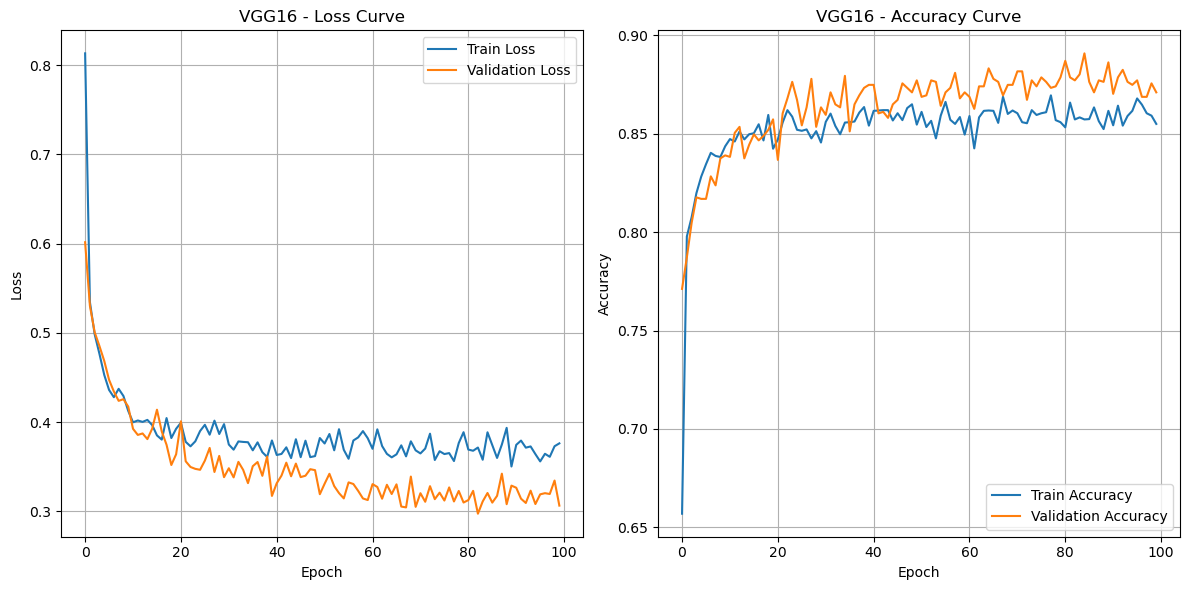

Best F1-Score for VGG16: 0.8895
Final Train F1-Score: 0.8538
Final Validation F1-Score: 0.8676
Validation Sensitivity per Class for VGG16: [0.8166666666666667, 0.6895424836601307, 0.9679012345679012, 0.98]
Validation Confusion Matrix for VGG16:
[[245  49   0   6]
 [ 26 211  40  29]
 [  4   5 392   4]
 [  1   4   1 294]]
--------------------------------------------------
Results for ResNet18:


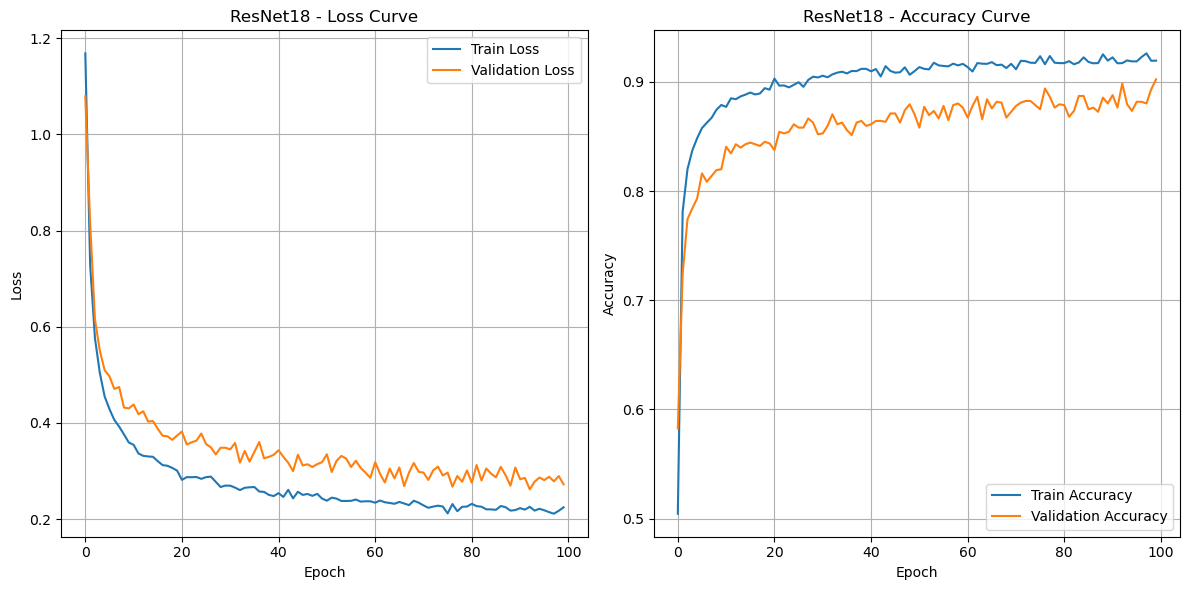

Best F1-Score for ResNet18: 0.9024
Final Train F1-Score: 0.9191
Final Validation F1-Score: 0.9024
Validation Sensitivity per Class for ResNet18: [0.8266666666666667, 0.8366013071895425, 0.9604938271604938, 0.9666666666666667]
Validation Confusion Matrix for ResNet18:
[[248  48   0   4]
 [ 15 256  17  18]
 [  2  11 389   3]
 [  1   9   0 290]]
--------------------------------------------------
Results for AlexNet:


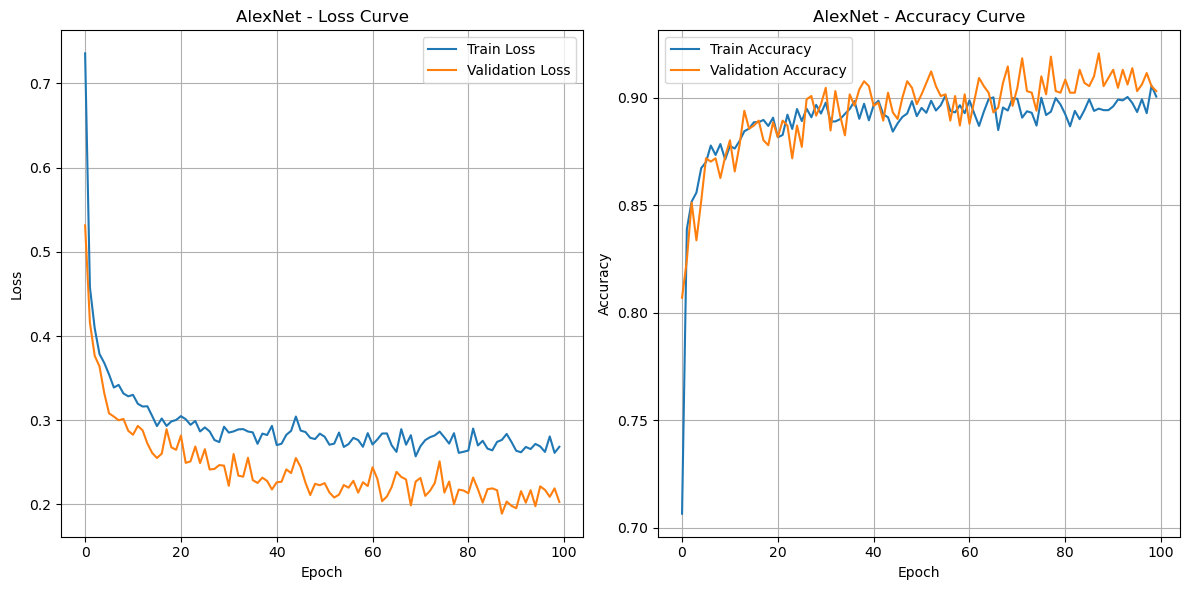

Best F1-Score for AlexNet: 0.9206
Final Train F1-Score: 0.9001
Final Validation F1-Score: 0.9025
Validation Sensitivity per Class for AlexNet: [0.8166666666666667, 0.8300653594771242, 0.9654320987654321, 0.98]
Validation Confusion Matrix for AlexNet:
[[245  47   1   7]
 [ 16 254  12  24]
 [  3   8 391   3]
 [  3   3   0 294]]
--------------------------------------------------


In [14]:
plot_and_display_results(all_results)